In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [207]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields
import itertools
from itertools import chain
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

In [6]:
# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In file_utils.py: default_cache_path = /raid3/xd/.cache/torch/hub


In [7]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [8]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _cxt2str, _item2str
with Timer('child_utils'): from child_frames import *
with Timer('model_utils'): from model_utils import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000041
utils ... done 0:00:00.036111
child_utils ... path = /nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/pattern/text/en/en-verbs.txt
done 0:00:10.981187
child_utils ... done 0:00:00.019491
model_utils ... In model_utils.py: finish import
done 0:00:24.076526


In [9]:
torch.set_grad_enabled(False);

In model_utils.py: finish import


In [10]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [11]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', 'EleutherAI/gpt-neox-20b/cpu']#, 'gpt2-xl', 'gpt2']
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:1]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 1
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 0; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer#, device

EleutherAI/gpt-j-6B/cpu ... done 0:08:53.011342


In [597]:
import openai
openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[2].split()[0]
response = openai.Completion.create(engine='text-davinci-002', prompt='Once upon a time',
    max_tokens=20, echo=True, logprobs=5)
print(response.choices[0].text)

Once upon a time, there was a tribe of smart, resourceful people.

This tribe lived in a land


In [10]:
def get_openai_model(engine):
    def forward(input_ids):#, attention_mask=None):
        text = tokenizer.decode(input_ids[0])
        response = openai.Completion.create(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5)
        return Outputs(logits=response.choices[0].logprobs)
    return forward
    
tokenizer0 = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
engines = ['text-babbage-001', 'text-curie-001', 'text-davinci-001', 'text-davinci-002'][1:] #+ \
#     ['curie', 'curie:2020-05-03', 'curie-instruct-beta', 'text-curie-001'] + \
#     ['davinci', 'davinci:2020-05-03', 'davinci-instruct-beta', 'davinci-instruct-beta:2.0.0', 'text-davinci-001', 'text-davinci-002']
for engine in engines: models[engine] = get_openai_model(engine), tokenizer0

In [13]:
model_name = gpt_model_names[0]
model, tokenizer = models[model_name]
unify(model)
if model_name == 'EleutherAI/gpt-neox-20b/' and model_name + '/cpu' in models:
    unify(models[model_name + '/cpu'][0])

blocks = model.transformer.h
attn0 = blocks[0].attn
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), attn0.num_heads, attn0.embed_dim

In [14]:
_girls = [name for name in girls if max(len(tokenizer.tokenize(name)), len(tokenizer.tokenize(' ' + name))) == 1]
_boys = [name for name in boys if max(len(tokenizer.tokenize(name)), len(tokenizer.tokenize(' ' + name))) == 1]
_boys = sample(_boys, len(_girls))
def persons(): return _boys + _girls

In [ ]:
# I = Identity; M = Mophism; A = Aggregation; C = CMP; G = GroupBy; l = local
patterns = ['M', 'A?', 'IA', 'MA',
    'IlI', 'MlI', 'IlM', 'MlM', 'IlMlI',
    'IlA', 'MlA', 'IlC', 'MlC', 'AlI', 'GIlI']
# NE types: boy girl planet letter number month day
# TreeSet(name_genders), TreeSet(name_prons), # resolve iu in speech,  item[0]
# BijectSet(place_landmarks), BijectSet(sport_players) # count, item[1]

In [16]:
def ith_gen(rels, cxt_len=3):
    hop = 0; cxt = sample(rels[hop][0].codom(), cxt_len)
    query, candidates, ans = None, (cxt, cxt), cxt[1]
    return cxt, query, candidates, ans

In [445]:
tasks = [
    # (lambda: [[EqSet(uppercase).equal], ], ith_gen, partial(_cxt2str, sep=' '), lambda q, _: '', 'Ġ->'), 
    (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], g2c(MlM_gen),
        partial(_cxt2str, sep='. ', item2str=lambda item, vocab: f"The {item[0]} is {item[1]}'s"),
        # lambda query, vocab: f'So does the {query[0]} belong to {query[1]}',
        lambda query, vocab: f'{query[0]} {query[1]}'#f"So is the {query[0]} {query[1]}'s",
    ), 
    (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], MlM_gen,
     # partial(_cxt2str, prefix='There are ', item2str=lambda i, _: f"{i[1]}'s {i[0]}"), lambda q, _: f"So whose {q}", '?' # worse 
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"The {i[0]} is {i[1]}'s"), lambda q, _: f'So the {q} belongs', 'Ġto'
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {wrap_noun(i[1])}'), lambda q, _: f'{q}', "'s"
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]} has {wrap_noun(i[1])}"), lambda q, _: f'{q}', "'s"
    ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
    (lambda: [EqSet(persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f'So {q}', " is"
    ), # c << g. cxt_len=3->2, gpt-j/neox better, davinci-001/002 worse!?
    (lambda: [EqSet(persons).use('equal'), SymSet(person_adjs).use('opposite')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f"So {q} is", " not"
    ), # t: 16-14, somewhat 14-7
    # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [[SymSet(person_adjs).equal], [EqSet(persons).equal]], MlM_gen,
#      partial(cxt2str, item2str=lambda i, _: f'{i[1]} is {i[0]}'), lambda q, _: f'So who is {}', '?'
#     ),  # gpt-neox good
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], g2c(IlMlI_gen),
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} {item[1]}'),
# #         lambda query, vocab: f'{query[0]} and {query[1]} are same?'
# #     ),
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], lMlI_gen,
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} is {item[1]}'),
# #         lambda query, vocab: f'{query} is the same as', # bare query is better for gpt-neox!?
# #     ),
#     (lambda: [[EqSet(persons).equal], [BijectSet(capabilities).proj]], partial(MlM_gen, cxt_len=2),
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {add_a_or_an(i[1])}'), lambda q, _: f'So {q}', 'Ġcan'
#     ),  # even davinci-001 is not very good
#     (lambda: [[EqSet(persons).equal], [BijectSet([(vt.did, vt.does) for vt in verb_tenses]).proj]], MlM_gen,
#      partial(cxt2str, sep='. '), lambda q, _: f'{q}', 'Ġusually'
#     ), # best performance among all tasks by all models. abstract > verbose
    (lambda: [EqSet(persons).use('equal'), TreeSet(country2capital).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q} is', ' from'
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(country2capital).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q} is', ' from'
    ), # t: 19-12 >> 16-10 = 12-7
    # (lambda: [[EqSet(persons).equal], [BijectSet(city2resident).proj]], MlM_gen,
    #  partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q}', 'Ġis'
    # ), # a little worse than capital -> country
]

In [468]:
results = {}; key = None

In [882]:
def result2dict(result): return {k: v for k, v in result.__dict__.items() if k not in ['task', 'data_tuples']}
with gzip.open(f'results_capital2country.pkl.gz', 'wb') as f: pickle.dump({k: result2dict(r) for k, r in results.items()}, f)
# with gzip.open(f'results.pkl.gz', 'rb') as f: results = pickle.load(f)

In [56]:
attn_patterns_by_step = {-1: ['bos->ans0]'], 0: ['bos->ans]'], 1: ['ans]->ans0]', 'ans]->ans0+']}

In [709]:
del make_data_tuple; from child_utils import make_data_tuple

In [864]:
nrows, k_shot = 8, 3; save_results = True
for task, cxt_len, abstract, do_g2c in tqdm(list(itertools.product(tasks[-2:], [1, 2], [0, 1], [False, ]))):
    seed(42)
    args = dict(cxt_len=cxt_len, abstract=abstract)
    if do_g2c: args['do_g2c'] = do_g2c
    res_key = f"{task2str(task)} ({', '.join(f'{k}={v}' for k, v in args.items())})"
    if save_results and key is not None and res_key != key: continue
    if save_results and res_key in results:
        result = results[res_key]; data_tuples = result.data_tuples
    else:
        batch_size = 32; verbose = not save_results or batch_size <= 32
        if verbose: print(f'===== {res_key} =====')
        all_examples, texts, bos_tokens = zip(*[generate(task, verbose=False, plot=False, nrows=nrows, **args)
                                                for i in range(batch_size)])
        result = Result(task, args, all_examples, texts)

        data_tuples, eval_results = zip(*[predict(model, tokenizer, text, examples,
            k_shot=k_shot, bos_token=bos_tokens[0], verbose=verbose)
            for text, examples in zip(texts, all_examples) if any(s in text for s in ['London', 'Seoul', 'Washington'])])
        result.data_tuples = data_tuples
        loss, acc, *_ = zip(*eval_results)
        result.mean_loss, result.mean_acc = np.array(loss).mean(), np.array(join_lists(acc)).mean()
        print(result.mean_loss, result.mean_acc)
        if save_results: results[res_key] = result
    if not save_results: continue

    for node_name in ['node']:#, 'argmax_node']:
        node = getattr(result, node_name, None)
        if node is None: node = add_node_to_result(result, node_name=node_name, label_type=node_name.replace('node', 'labels'))
        node.data.attr = mr(attribute_step)(data_tuples[:4], model, node)
    result.node.data.scores = {ap: mr(get_head_matching_scores)(data_tuples, ap, k_shot=k_shot)
        for ap in attn_patterns_by_step[node.data.step]} if 'g2c' not in res_key else None

100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


In [315]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")  # old full

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=0): 0.032, 1.0
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=1): 0.117, 0.90625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0): 0.594, 0.65625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=1): 1.354, 0.53125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0): 0.793, 0.625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=1): 0.286, 0.8125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0): 2.174, 0.46875
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=1): 1.824, 0.46875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=0): 0.048, 0.875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=1): 0.191, 0.90625
MlM_gen(persons

In [343]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=0): 0.027, 0.9375
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=1): 0.102, 0.90625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0): 1.261, 0.5625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=1): 1.538, 0.46875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0): 0.451, 0.625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=1): 0.349, 0.75
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0): 3.566, 0.3125
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=1): 3.773, 0.25


In [470]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=1, abstract=0): 0.068, 0.8125
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=1, abstract=1): 0.111, 0.84375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0): 0.866, 0.65625
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=1): 1.251, 0.5
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0): 0.093, 0.84375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=1): 0.119, 0.8125
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0): 1.386, 0.4375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=1): 2.561, 0.4375


Angelo lives in Canberra. Angelo is from Australia
Emily lives in Bern. Emily is from Switzerland
Leon lives in Rome. Leon is from Italy
 [-1] root labels┐
                 └[0] top[2] 19-12 attn_labels┐
                                              │                                        ┌[2] top[0, 1] 5-12,8-3
                                              └[1] top[0, 1, 2, 3] 13-13,8-1,12-10,11-0┤
                                                                                       └*[2] top[0, 1, 2, 3] 5-12,8-3,1-7,6-10...
[-1] root labels


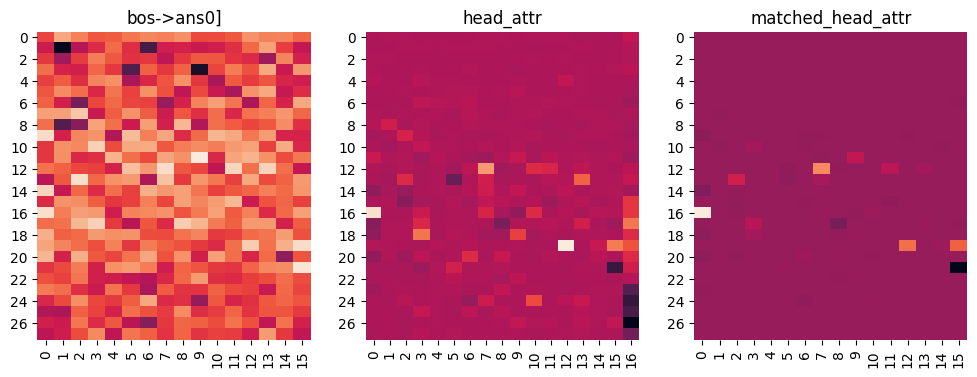

(array([11, 21, 13, 16, 12,  9, 19, 12, 14, 12]),
 array([ 9, 15,  2,  0,  7,  0, 15, 11,  0, 13]),
 array([-0.21577224, -0.45070654, -0.5740944 , -0.59576213, -0.68915856,
       -0.72982705, -0.745999  , -0.956928  , -0.9940366 , -1.0468302 ],
      dtype=float32))
(array([19, 16, 12, 19, 17, 18, 13, 19, 24, 18]),
 array([12,  0,  7, 15, 16,  3, 13, 16, 10,  9]),
 array([1.6328077 , 1.5465269 , 1.0320864 , 0.8404534 , 0.80687124,
       0.8045759 , 0.68991804, 0.59838754, 0.55406755, 0.50006294],
      dtype=float32))
(array([16, 12, 19, 19, 13, 11, 12, 17, 13, 12]),
 array([ 0,  7, 12, 15,  2,  9, 11,  3,  7, 13]),
 array([0.85235643, 0.5181056 , 0.43699065, 0.39859366, 0.19187868,
       0.14302027, 0.12064658, 0.10697585, 0.04785806, 0.04387965],
      dtype=float32))
[0] top[2] 19-12 attn_labels


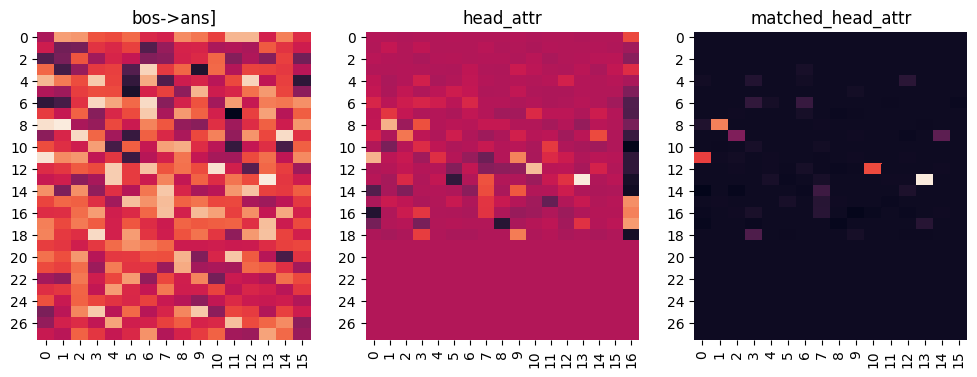

(array([13,  8, 11, 12,  8,  9,  6, 18,  9,  6]),
 array([13,  1,  0, 10,  0, 14,  6,  3,  2,  3]),
 array([-2.1104734, -2.1118917, -2.341813 , -2.3623142, -2.4106543,
       -2.5359712, -2.5639296, -2.565811 , -2.6123538, -2.6466293],
      dtype=float32))
(array([13, 12, 11,  8, 17, 15, 11, 16, 18,  9]),
 array([13, 10,  0,  1, 16, 16,  9, 16,  9,  2]),
 array([1.4362833 , 1.1206292 , 1.0599738 , 1.0442073 , 0.9130223 ,
       0.84071916, 0.766217  , 0.75772417, 0.7288693 , 0.7030485 ],
      dtype=float32))
(array([13,  8, 12, 11,  9,  9, 18, 14,  6,  6]),
 array([13,  1, 10,  0,  2, 14,  3,  7,  6,  3]),
 array([0.17404966, 0.1263583 , 0.10556547, 0.10191982, 0.05157681,
       0.03676775, 0.03060382, 0.02232917, 0.01978488, 0.01676363],
      dtype=float32))
[1] top[0, 1, 2, 3] 13-13,8-1,12-10,11-0


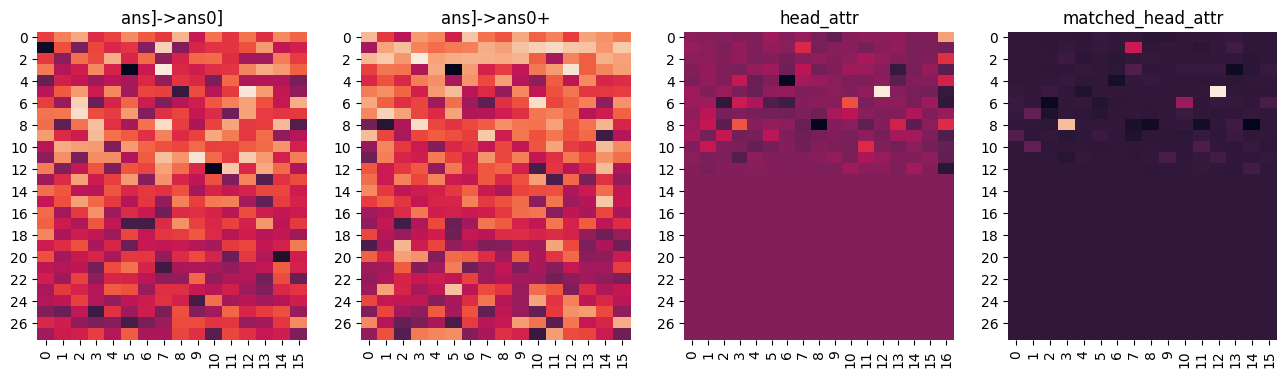

(array([ 3,  5, 11,  7,  8,  1,  6, 11, 12, 11]),
 array([ 7, 12,  9,  2,  7,  7,  2, 12, 11,  7]),
 array([-0.72030103, -0.8439094 , -0.9205216 , -1.0588219 , -1.0695171 ,
       -1.4008708 , -1.4046199 , -1.578186  , -1.6389456 , -1.8323461 ],
      dtype=float32))
(array([2, 3, 6, 8, 1, 7, 1, 1, 2, 9]),
 array([ 3, 12, 10,  3, 11,  1, 10, 15,  1,  7]),
 array([-1.0059502, -1.1935498, -1.3136737, -1.3876293, -1.442794 ,
       -1.5962044, -1.6511365, -1.7942752, -1.8059132, -1.8354278],
      dtype=float32))
(array([ 5,  0,  8,  6,  2,  8, 10,  1,  8,  4]),
 array([12, 16,  3, 10, 16, 16, 11,  7, 13, 16]),
 array([0.81726795, 0.583975  , 0.38171187, 0.3774796 , 0.28694302,
       0.2736831 , 0.2654661 , 0.25668615, 0.23239286, 0.23171113],
      dtype=float32))
(array([ 5,  8,  1,  6,  7, 10,  9,  3, 10, 11]),
 array([12,  3,  7, 10,  1,  1,  0,  7, 11,  9]),
 array([0.08826026, 0.07610155, 0.03723093, 0.02574   , 0.01252321,
       0.01186608, 0.00868085, 0.00799938, 0.00760066, 0.0

In [871]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [843]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

16 0
(0.9464224576950073, 0.9693313837051392)
Berlin->['Germany'] {'ĠBerlin': 34, 'ĠFriedrich': 22, 'ĠGermany': 19, 'ĠReich': 19, 'ĠGerman': 19}
Cairo->['Egypt'] {'ĠCairo': 40, 'Egypt': 39, 'ĠEgypt': 39, 'ĠEgyptian': 38, 'ĠEgyptians': 37}
Ankara->['Turkey'] {'ĠAnkara': 42, 'ĠTurkish': 38, 'ĠErdogan': 37, 'ĠTurkey': 36, 'Turkish': 35}
Athens->['Greece'] {'ĠAthens': 42, 'ĠAthen': 33, 'ĠAthena': 30, 'ĠGreece': 30, 'ĠGreek': 29}
London->['England'] {'ĠLondon': 26, 'London': 26, 'ĠNotting': 25, 'ĠThames': 24, 'ĠBarcl': 19}
Manila->['the Philippines'] {'ĠManila': 34, 'ĠFilipino': 31, 'ĠPhilippines': 31, 'ĠPhilippine': 29, 'ĠFilip': 27}
Ottawa->['Canada'] {'ĠOttawa': 36, 'Ott': 26, 'ĠCanadians': 24, 'ĠCanadian': 24, 'ĠQuebec': 22}
Bern->['Switzerland'] {'Bern': 30, 'ĠBernstein': 30, 'ĠBern': 25, 'bern': 24, 'ĠBernard': 21}
Seoul->['South Korea'] {'ĠSeoul': 39, 'ĠKoreans': 36, 'ĠKorean': 36, 'ĠKorea': 33, 'ĠYong': 29}
Lisbon->['Portugal'] {'ĠLisbon': 40, 'ĠPortuguese': 38, 'ĠPortugal': 37, 'ĠP

16 0
tensor([-10.2562,  -4.6536,  -8.7117, -13.0509])
 ĠTurkey 0.013 {'ĠAnkara': 0.595, 'ĠTurkish': 0.379, 'ĠTurkey': 0.013, 'Turkish': 0.008} 	 Justice lives in Ankara. Justice is from Turkey
 Ġthe 0.0 {'ĠTurkish': 0.875, 'ĠTurks': 0.052, 'ĠTurkey': 0.026, 'Turkish': 0.023} 	 Carl lives in London. Carl is from the United Kingdom
 ĠChina 0.001 {'ĠBeijing': 0.996, 'ĠChinese': 0.003, 'ĠChina': 0.001, 'ĠTian': 0.0} 	 Jacob lives in Beijing. Jacob is from China
 Ġthe 0.0 {'ĠManila': 0.821, 'ĠPhilippines': 0.135, 'ĠFilipino': 0.024, 'ĠPhilippine': 0.02} 	 Laura lives in Manila. Laura is from the Philippines
 ĠSouth 0.0 {'ĠSeoul': 0.746, 'ĠKorean': 0.179, 'ĠKoreans': 0.045, 'ĠKorea': 0.03} 	 Victoria lives in Seoul. Victoria is from South Korea
 ĠPortugal 0.269 {'ĠLisbon': 0.434, 'ĠPortuguese': 0.297, 'ĠPortugal': 0.269, 'ĠPortug': 0.0} 	 Dream lives in Lisbon. Dream is from Portugal
*ĠBrazil 0.698 {'ĠBrazil': 0.698, 'ĠBrazilian': 0.145, 'ĠBraz': 0.106, 'Brazil': 0.049} 	 Alexander lives in 

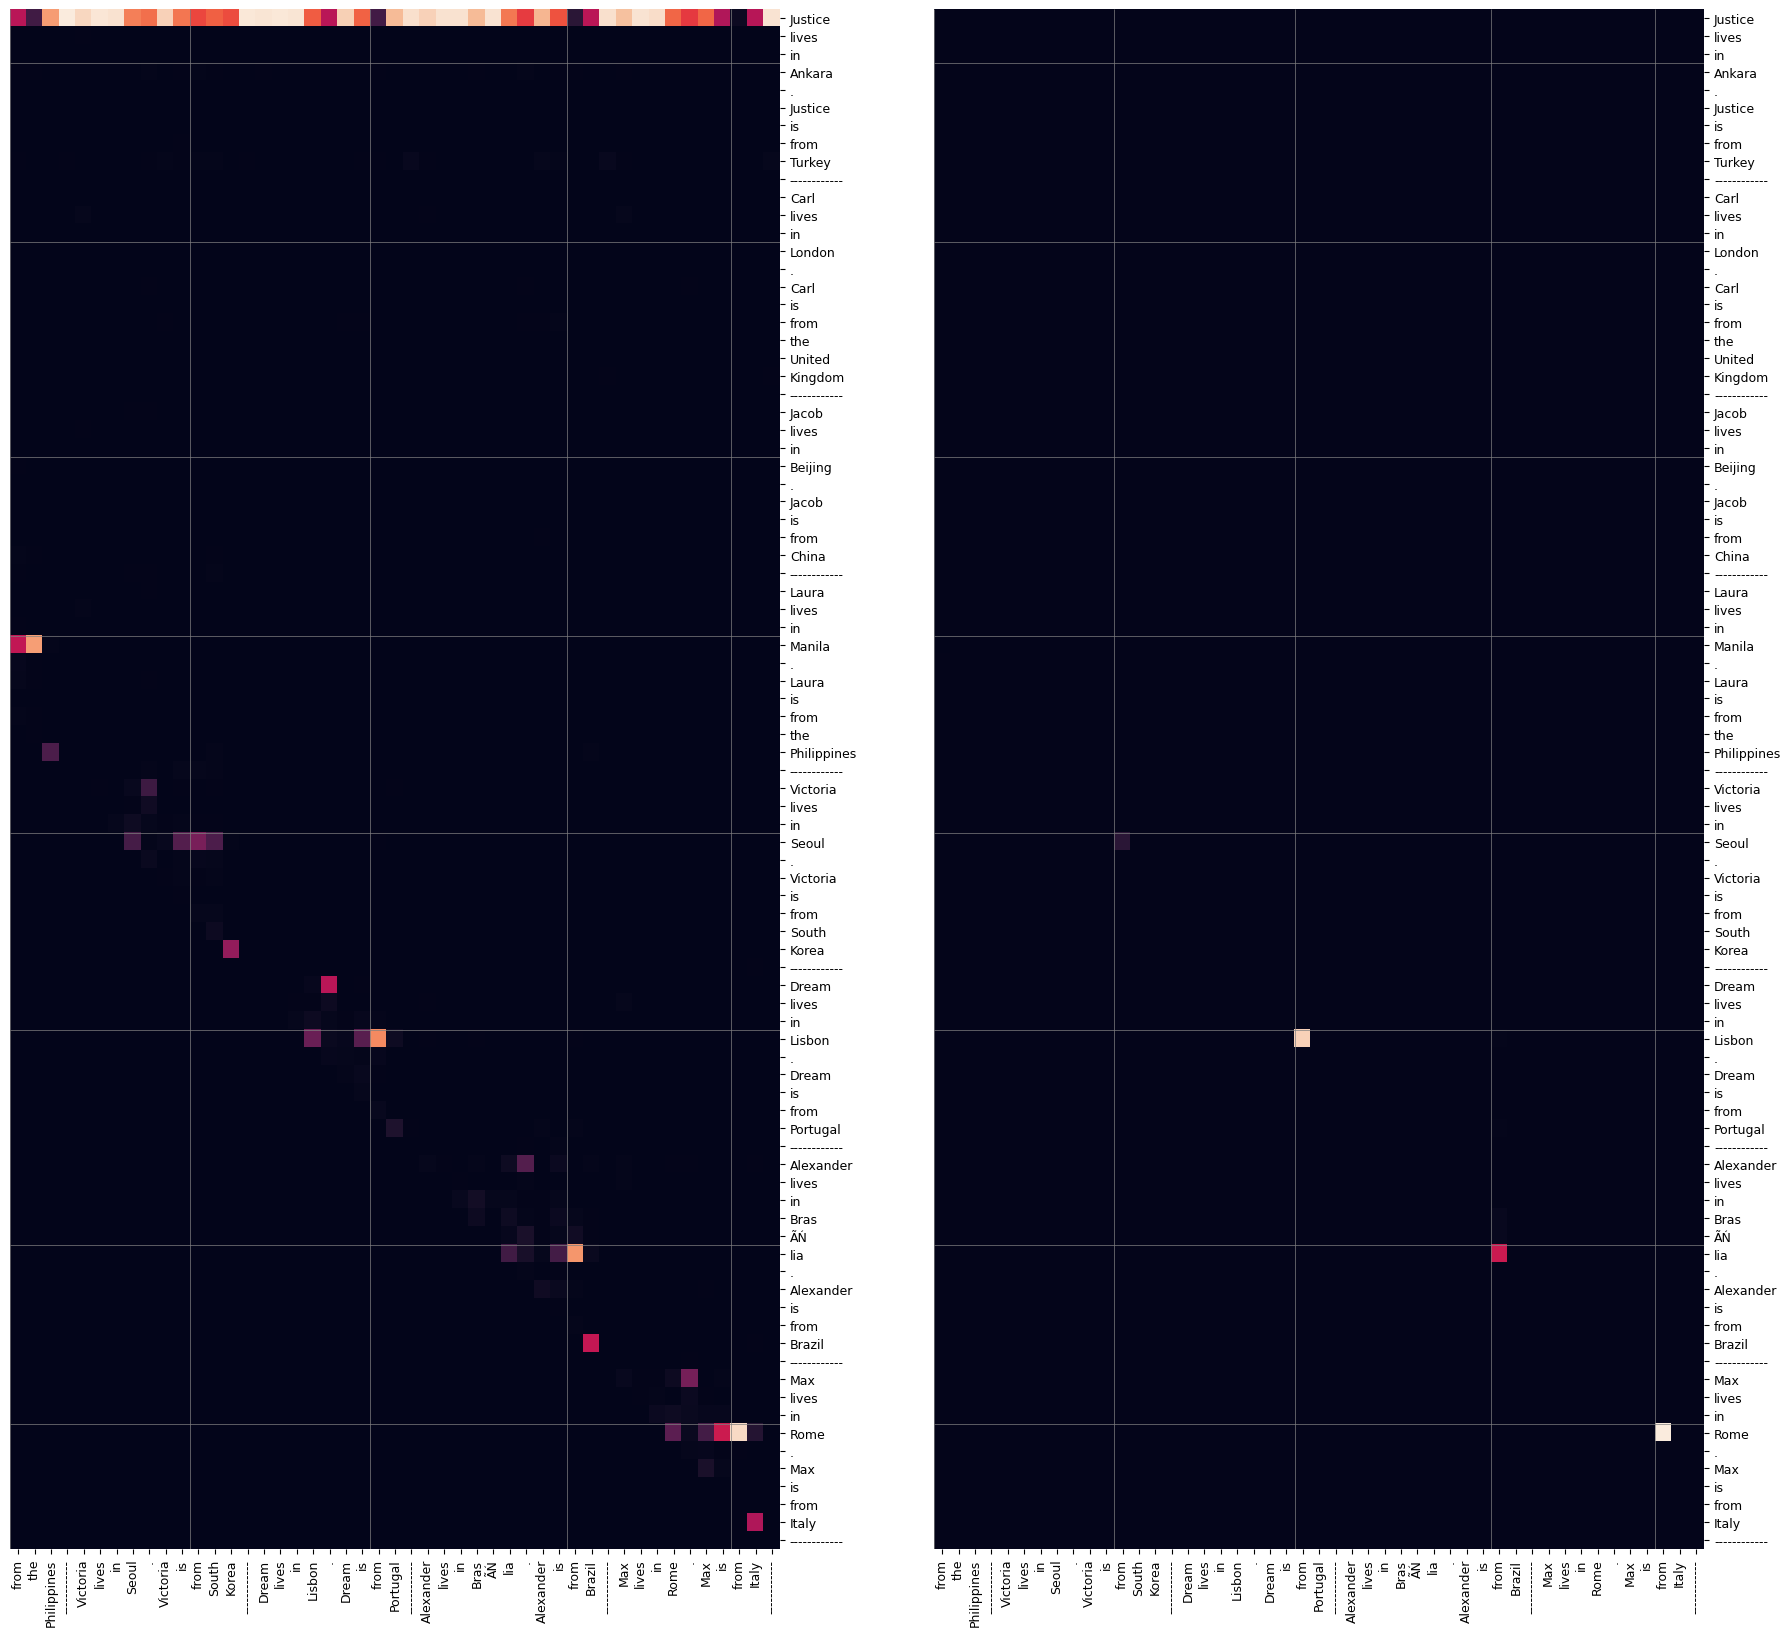

tensor([-10.5722,  -3.1635,  -4.7839,  -7.0222])
 ĠChina 0.008 {'ĠBeijing': 0.957, 'ĠChinese': 0.017, 'ĠTian': 0.011, 'ĠChina': 0.008} 	 Anna lives in Beijing. Anna is from China
*ĠMexico 0.861 {'ĠMexico': 0.861, 'ĠMexican': 0.082, 'Mexico': 0.036, 'Mex': 0.019} 	 Jamie lives in Mexico City. Jamie is from Mexico
 Ġthe 0.0 {'ĠRedskins': 0.422, 'ĠMaryland': 0.3, 'ĠCapitals': 0.103, 'ĠWizards': 0.079} 	 Royal lives in Washington, D.C. Royal is from the United States
 ĠGreece 0.001 {'ĠAthens': 0.999, 'ĠGreece': 0.001, 'ĠAthen': 0.0, 'ĠGreek': 0.0} 	 Roman lives in Athens. Roman is from Greece
 ĠSpain 0.01 {'ĠMadrid': 0.987, 'ĠSpain': 0.01, 'ĠSpanish': 0.002, 'ĠSpani': 0.001} 	 Thomas lives in Madrid. Thomas is from Spain
 ĠPortugal 0.191 {'ĠLisbon': 0.428, 'ĠPortuguese': 0.381, 'ĠPortugal': 0.191, 'ĠPortug': 0.0} 	 Justice lives in Lisbon. Justice is from Portugal
 Ġthe 0.0 {'ĠRedskins': 0.309, 'ĠWashington': 0.294, 'ĠMaryland': 0.269, 'ĠCapitals': 0.083} 	 Roger lives in Washington, D.C. 

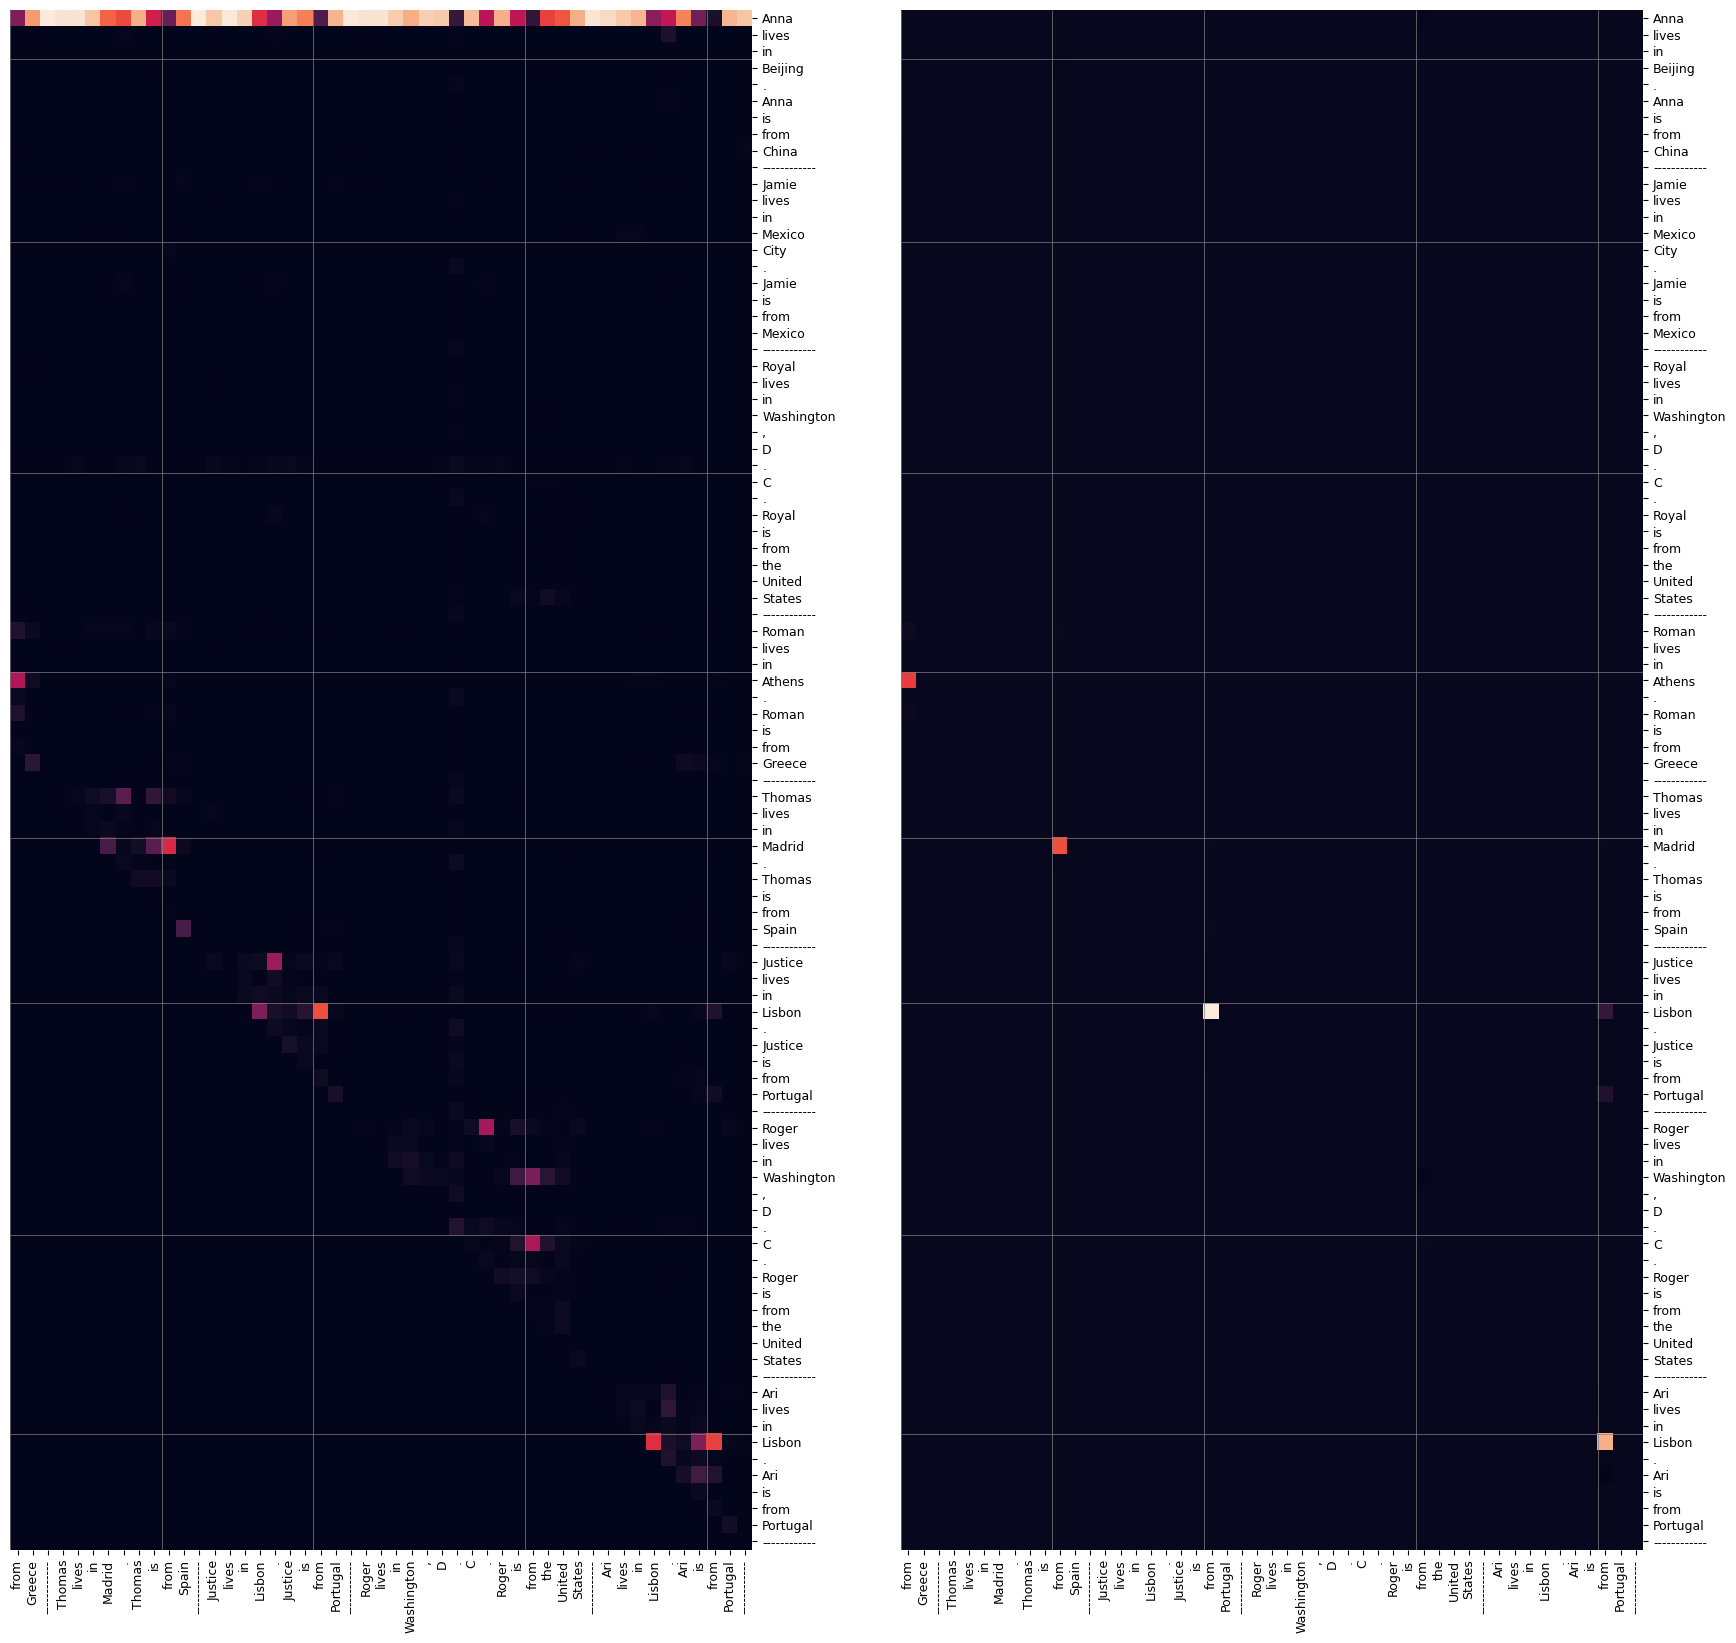

tensor([-10.7878,  -3.0312,  -4.5536,  -6.4872])
 ĠSwitzerland 0.0 {'India': 0.411, 'ĠIndian': 0.331, 'Indian': 0.202, 'ĠIndia': 0.05} 	 India lives in Bern. India is from Switzerland
 ĠJapan 0.049 {'ĠTokyo': 0.91, 'ĠJapan': 0.049, 'ĠJapanese': 0.025, 'Tok': 0.011} 	 Eva lives in Tokyo. Eva is from Japan
*ĠKenya 0.967 {'ĠKenya': 0.967, 'ĠKenyan': 0.033, 'Ken': 0.0, 'ĠKik': 0.0} 	 Collins lives in Nairobi. Collins is from Kenya
 ĠSpain 0.031 {'ĠMadrid': 0.955, 'ĠSpain': 0.031, 'ĠSpanish': 0.01, 'ĠSpani': 0.003} 	 Raven lives in Madrid. Raven is from Spain
 ĠSouth 0.0 {'ĠSeoul': 0.645, 'ĠKorean': 0.259, 'ĠKorea': 0.055, 'ĠKoreans': 0.041} 	 Hunter lives in Seoul. Hunter is from South Korea
 ĠThailand 0.101 {'ĠBangkok': 0.895, 'ĠThailand': 0.101, 'ĠThai': 0.004, 'Bang': 0.0} 	 Rachel lives in Bangkok. Rachel is from Thailand
 ĠFrance 0.225 {'ĠParis': 0.635, 'ĠFrance': 0.225, 'ĠFrench': 0.084, 'Paris': 0.046} 	 Wilson lives in Paris. Wilson is from France
*ĠSwitzerland 0.428 {'ĠSwitzerland

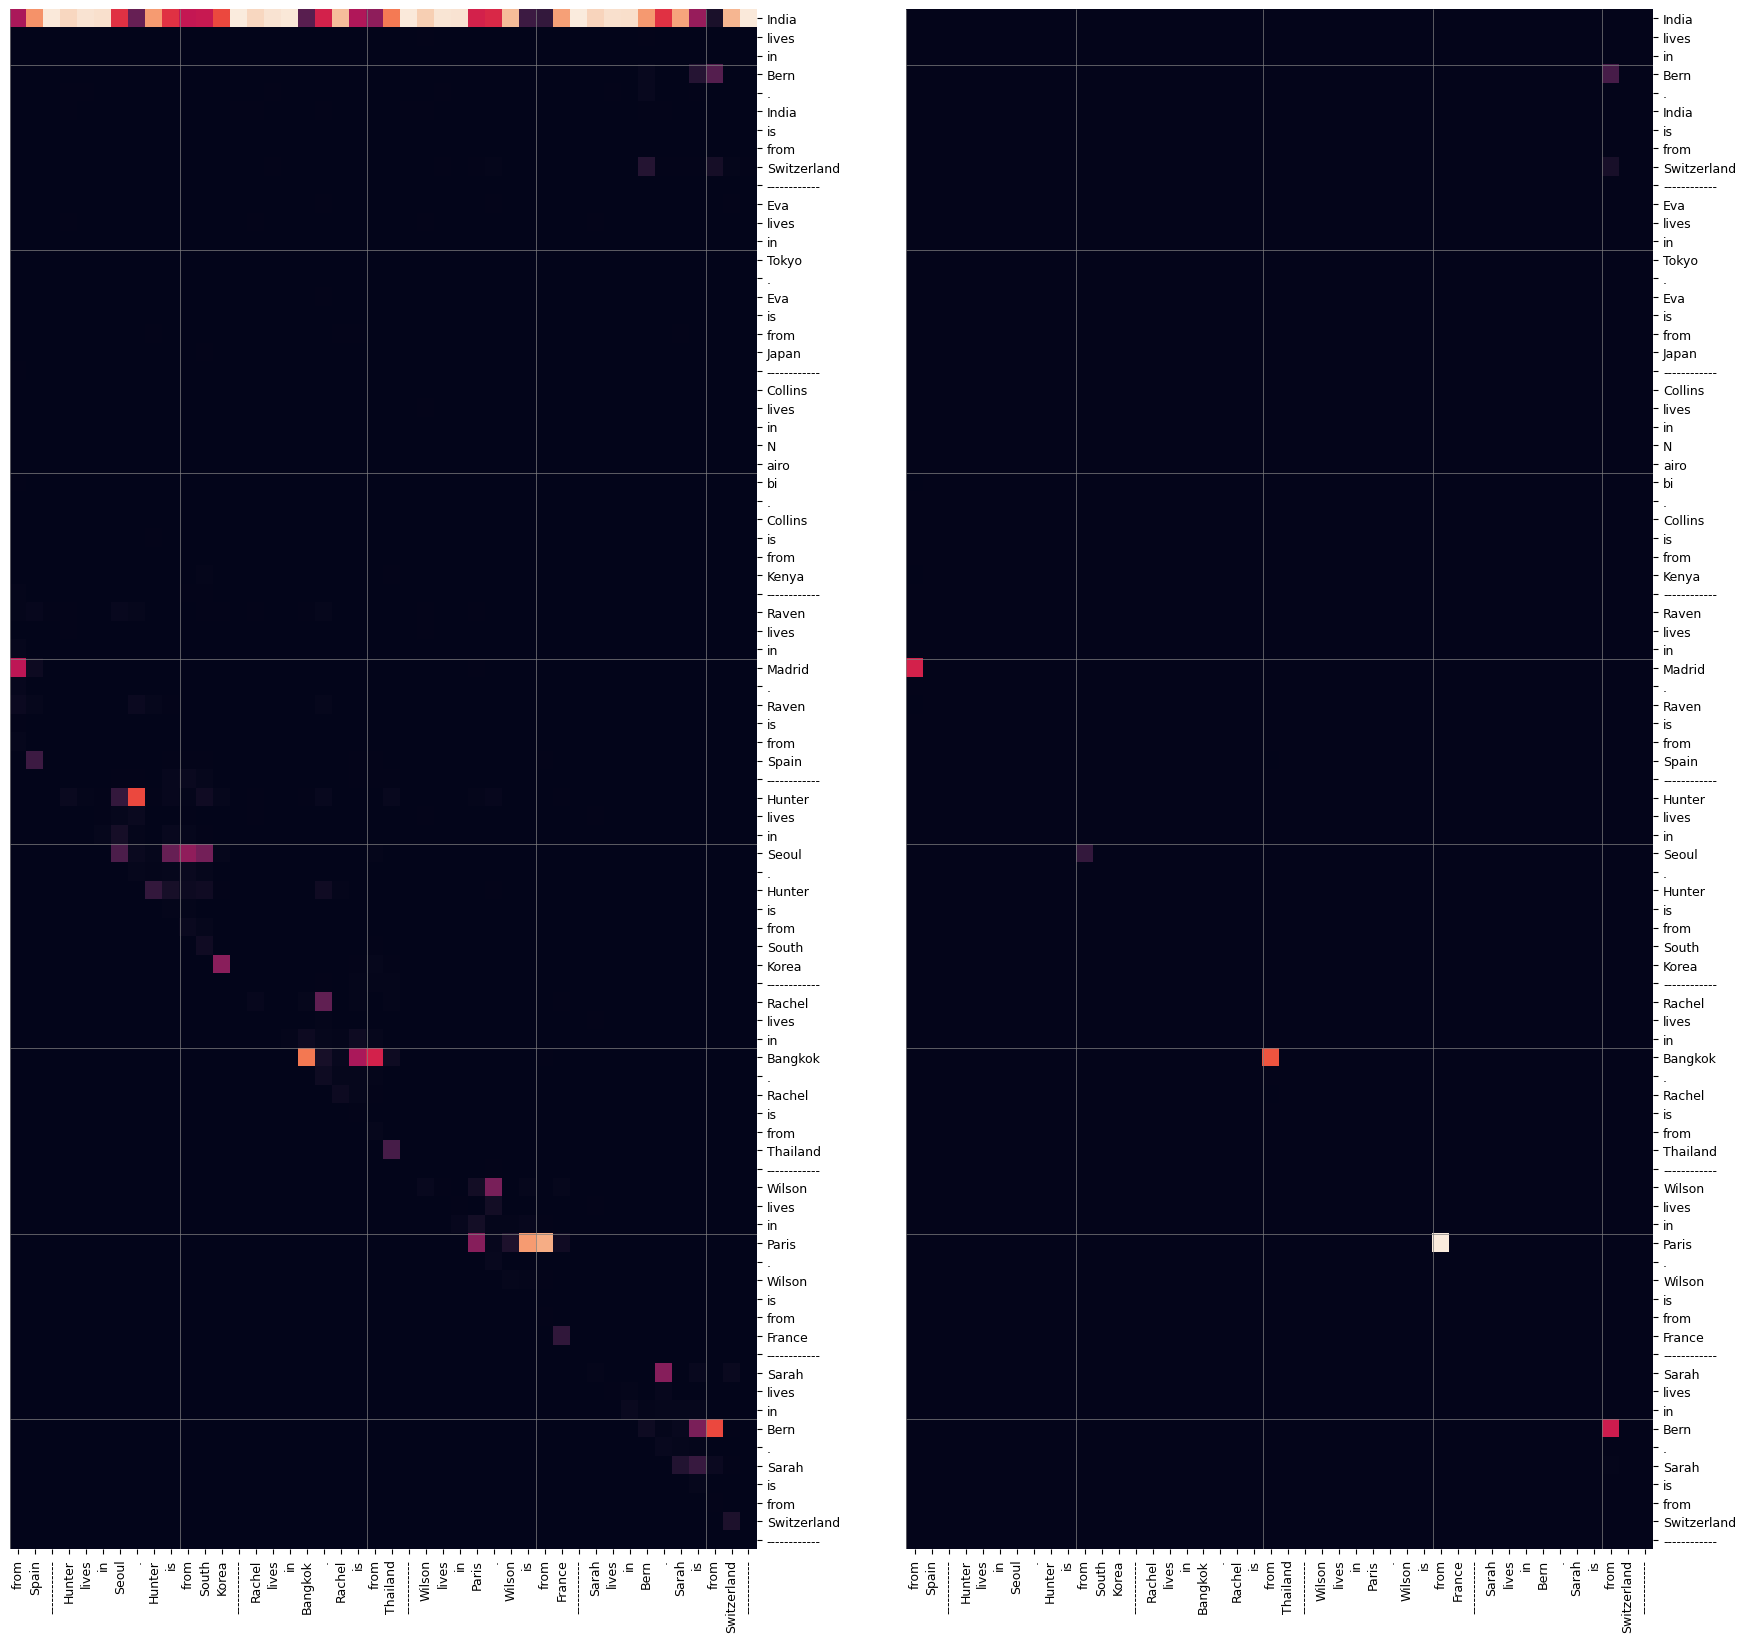

tensor([-10.6916,  -3.4078,  -5.8561,  -8.5677])
 ĠAustralia 0.0 {'ĠAngelo': 1.0, 'Angelo': 0.0, 'angelo': 0.0, 'ĠLuigi': 0.0} 	 Angelo lives in Canberra. Angelo is from Australia
 ĠSwitzerland 0.004 {'Bern': 0.602, 'ĠBernstein': 0.347, 'ĠBern': 0.034, 'bern': 0.011} 	 Emily lives in Bern. Emily is from Switzerland
 ĠItaly 0.003 {'ĠRome': 0.993, 'ĠItaly': 0.003, 'ĠItalian': 0.001, 'ĠRoma': 0.001} 	 Leon lives in Rome. Leon is from Italy
 ĠTurkey 0.008 {'ĠTurkish': 0.536, 'ĠAnkara': 0.446, 'ĠTurkey': 0.008, 'Turkish': 0.007} 	 Ford lives in Ankara. Ford is from Turkey
 ĠRussia 0.001 {'ĠMoscow': 0.978, 'Moscow': 0.012, 'ĠKremlin': 0.006, 'ĠRussian': 0.002} 	 Dallas lives in Moscow. Dallas is from Russia
 ĠPortugal 0.257 {'ĠLisbon': 0.402, 'ĠPortuguese': 0.341, 'ĠPortugal': 0.257, 'ĠPortug': 0.0} 	 Sarah lives in Lisbon. Sarah is from Portugal
 ĠItaly 0.003 {'ĠRome': 0.996, 'ĠItaly': 0.003, 'ĠItalian': 0.001, 'ĠItalians': 0.001} 	 Ocean lives in Rome. Ocean is from Italy
 ĠSouth 0.0 {'ĠSe

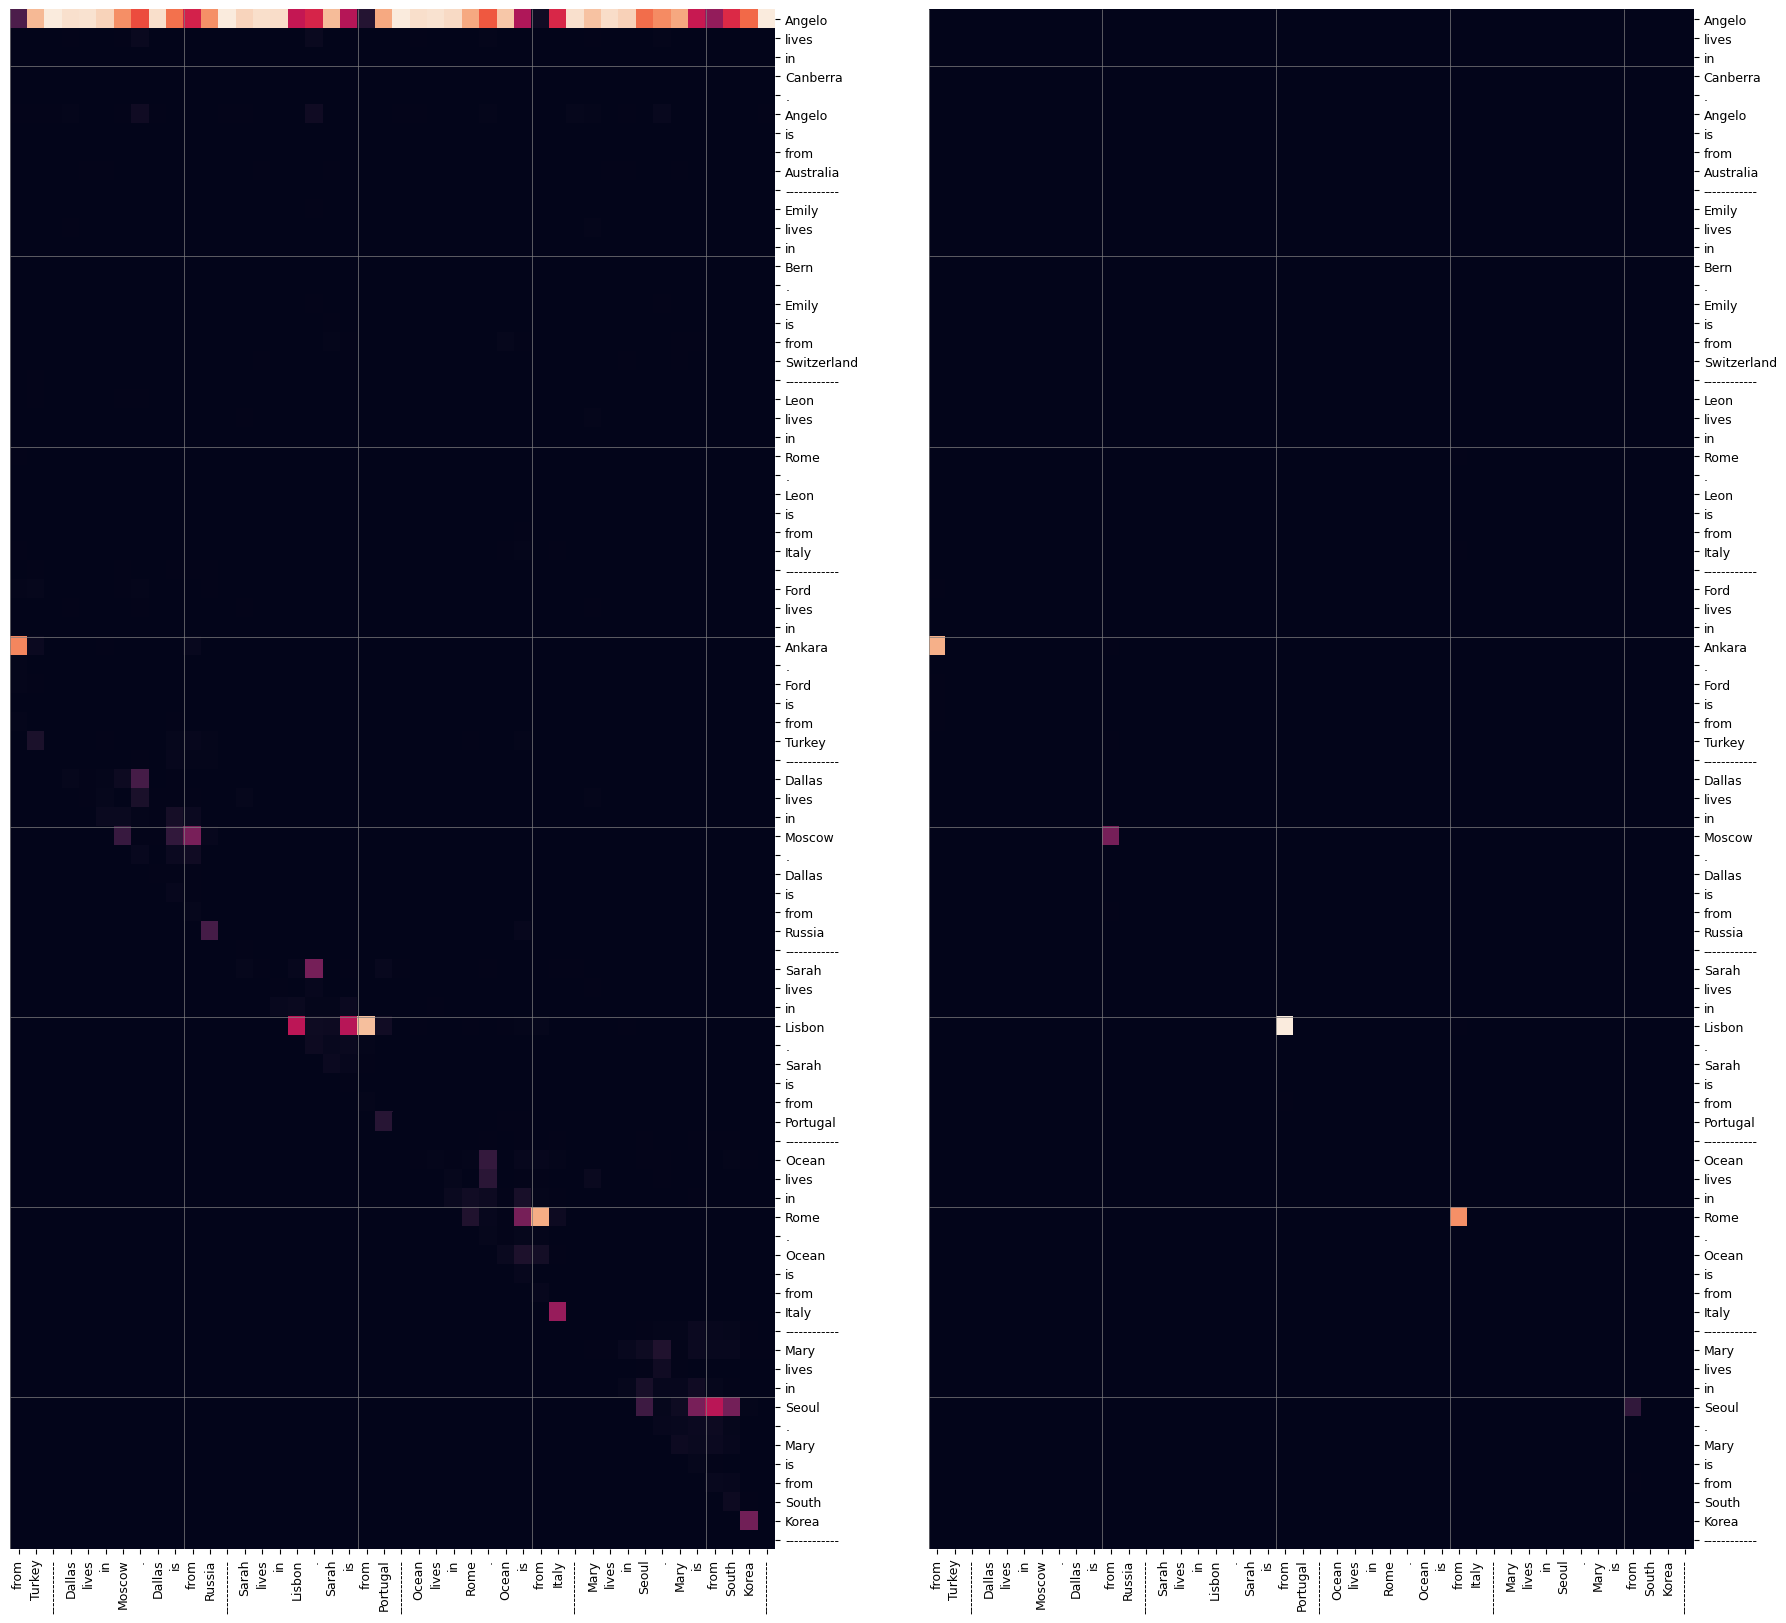

12 7
tensor([-10.3770,  -5.5466, -10.4518, -15.5673])
 ĠTurkey 0.001 {'ĠIsrael': 0.234, 'ĠAnkara': 0.152, 'ĠPalestinian': 0.139, 'ĠSyria': 0.122} 	 Justice lives in Ankara. Justice is from Turkey
 Ġthe 0.0 {'ĠÂ£': 0.974, 'ĠUK': 0.023, 'UK': 0.002, 'ĠBritain': 0.0} 	 Carl lives in London. Carl is from the United Kingdom
 ĠChina 0.015 {'ĠBeijing': 0.751, 'ĠChinese': 0.209, 'Chinese': 0.016, 'ĠChina': 0.015} 	 Jacob lives in Beijing. Jacob is from China
 Ġthe 0.0 {'ĠFilipino': 0.482, 'ĠPhilippine': 0.217, 'ĠPhilippines': 0.202, 'ĠManila': 0.1} 	 Laura lives in Manila. Laura is from the Philippines
 ĠSouth 0.0 {'ĠKorean': 0.697, 'ĠKorea': 0.283, 'ĠSeoul': 0.012, 'ĠKoreans': 0.008} 	 Victoria lives in Seoul. Victoria is from South Korea
*ĠPortugal 0.863 {'ĠPortugal': 0.863, 'ĠPortuguese': 0.087, 'ĠLisbon': 0.05, 'ĠPortug': 0.0} 	 Dream lives in Lisbon. Dream is from Portugal
 ĠBrazil 0.234 {'Brazil': 0.723, 'ĠBrazil': 0.234, 'ĠBrazilian': 0.043, 'ĠBraz': 0.0} 	 Alexander lives in Brasília. 

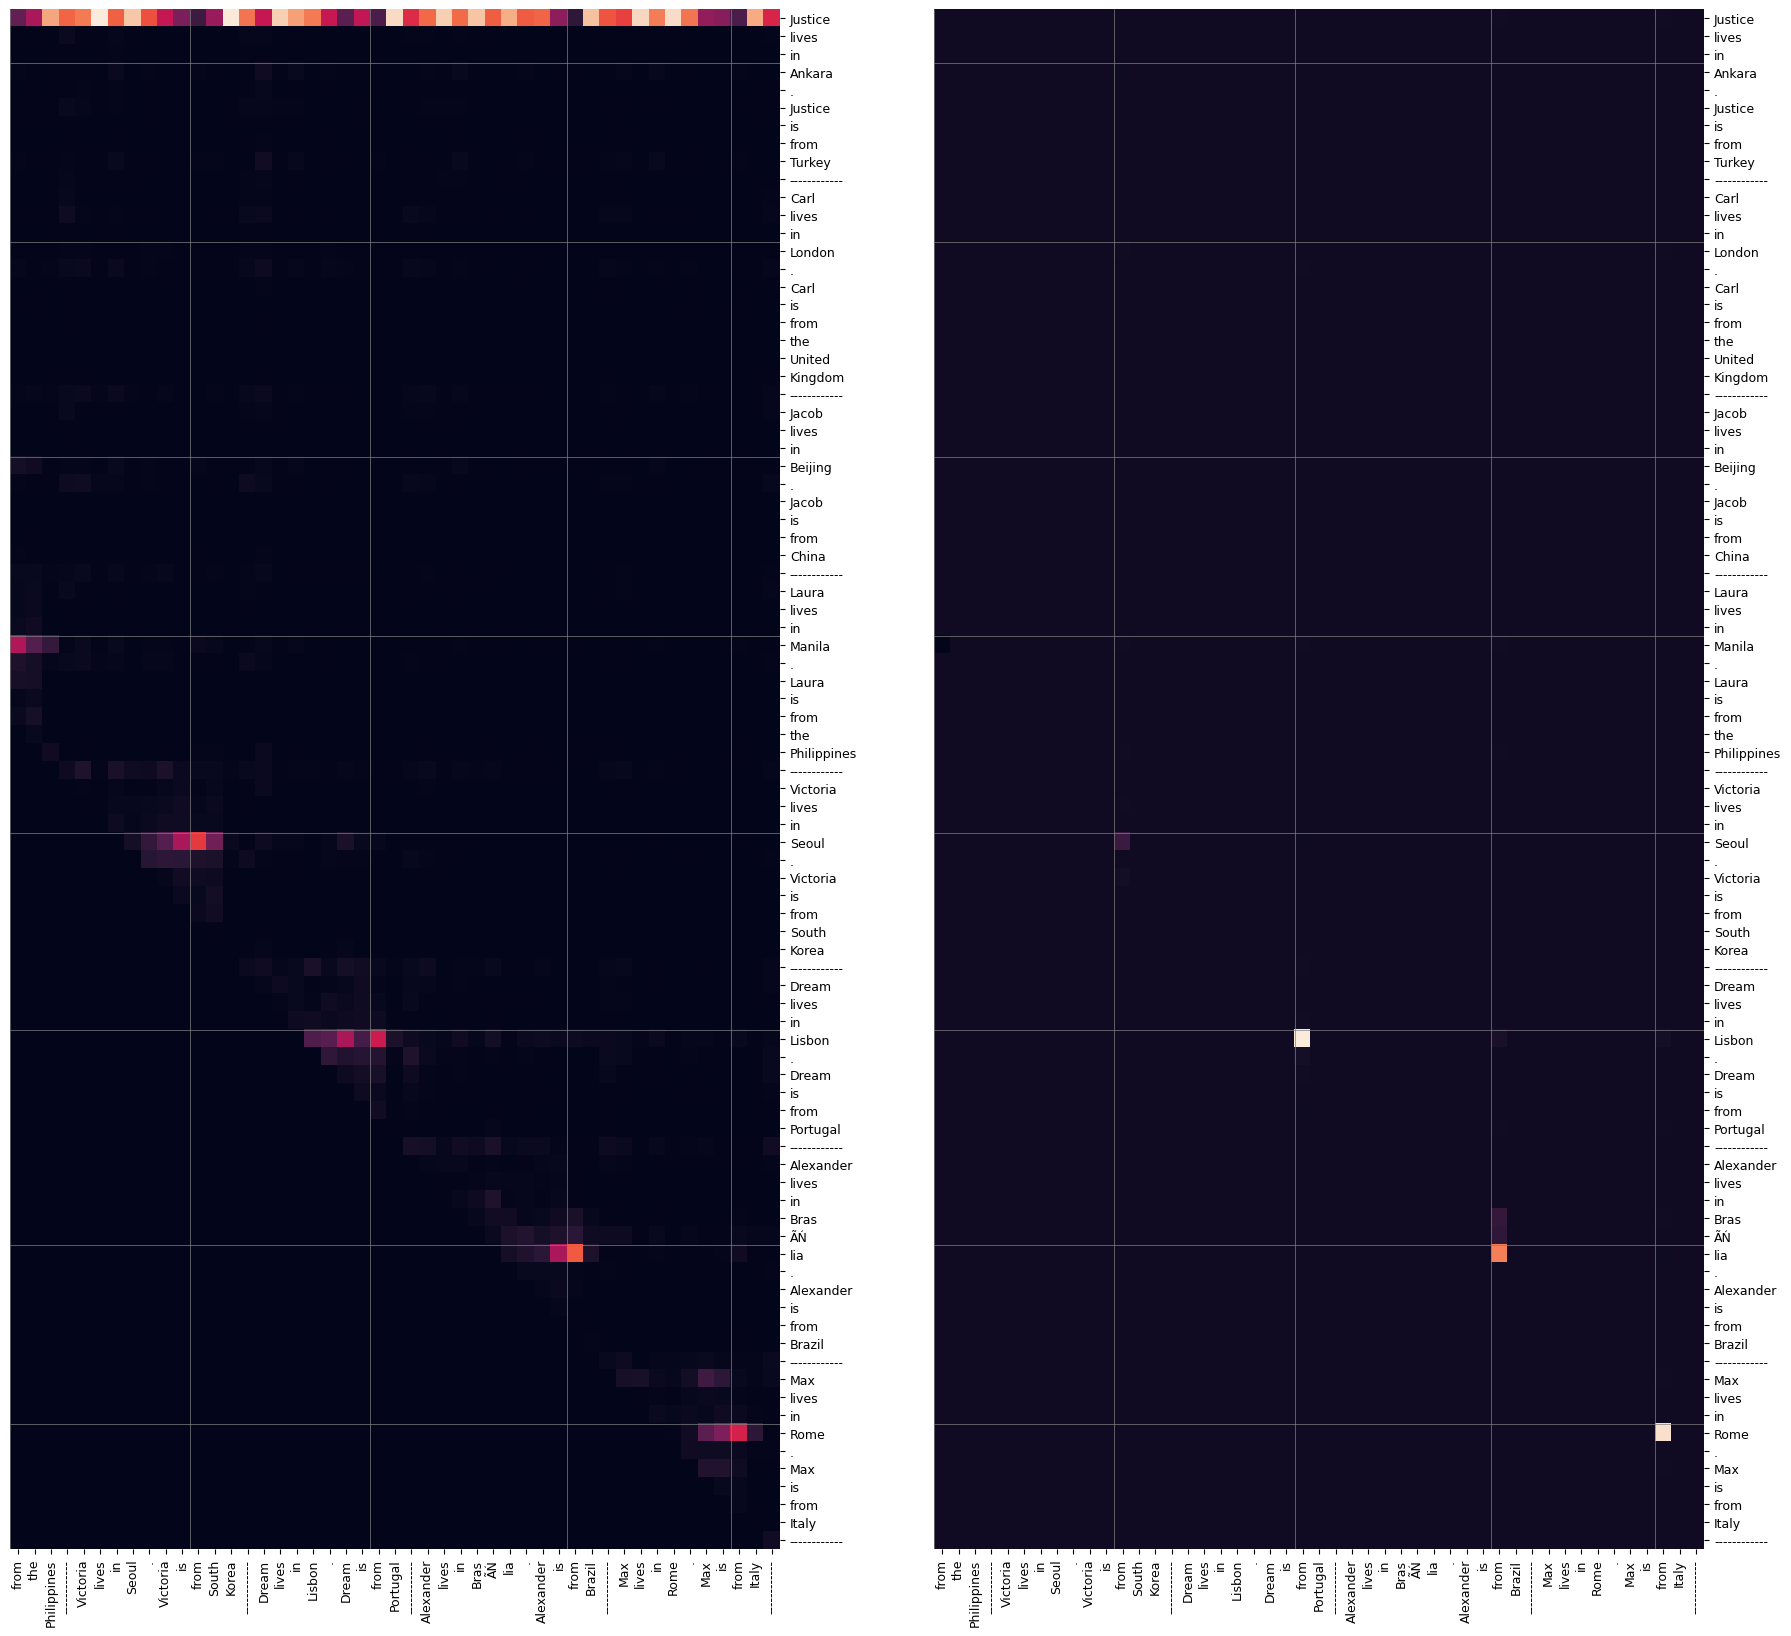

tensor([-10.6527,  -2.6374,  -3.8477,  -5.5959])
 ĠChina 0.001 {'ĠBeijing': 0.96, 'ĠChinese': 0.028, 'ĠYuan': 0.003, 'ĠQian': 0.002} 	 Anna lives in Beijing. Anna is from China
 ĠMexico 0.427 {'Mexico': 0.439, 'ĠMexico': 0.427, 'ĠMexican': 0.121, 'Mex': 0.012} 	 Jamie lives in Mexico City. Jamie is from Mexico
 Ġthe 0.0 {'ĠWashington': 0.922, 'Washington': 0.034, 'ĠMaryland': 0.031, 'ĠBaltimore': 0.008} 	 Royal lives in Washington, D.C. Royal is from the United States
 ĠGreece 0.101 {'ĠAthens': 0.822, 'ĠGreece': 0.101, 'ĠGreeks': 0.042, 'ĠGreek': 0.023} 	 Roman lives in Athens. Roman is from Greece
*ĠSpain 0.952 {'ĠSpain': 0.952, 'Spain': 0.037, 'ĠMadrid': 0.007, 'ĠSpanish': 0.002} 	 Thomas lives in Madrid. Thomas is from Spain
*ĠPortugal 0.804 {'ĠPortugal': 0.804, 'ĠPortuguese': 0.12, 'ĠLisbon': 0.075, 'ĠPortug': 0.0} 	 Justice lives in Lisbon. Justice is from Portugal
 Ġthe 0.0 {'ĠWashington': 0.662, 'ĠMaryland': 0.292, 'ĠBaltimore': 0.024, 'Washington': 0.013} 	 Roger lives in Washi

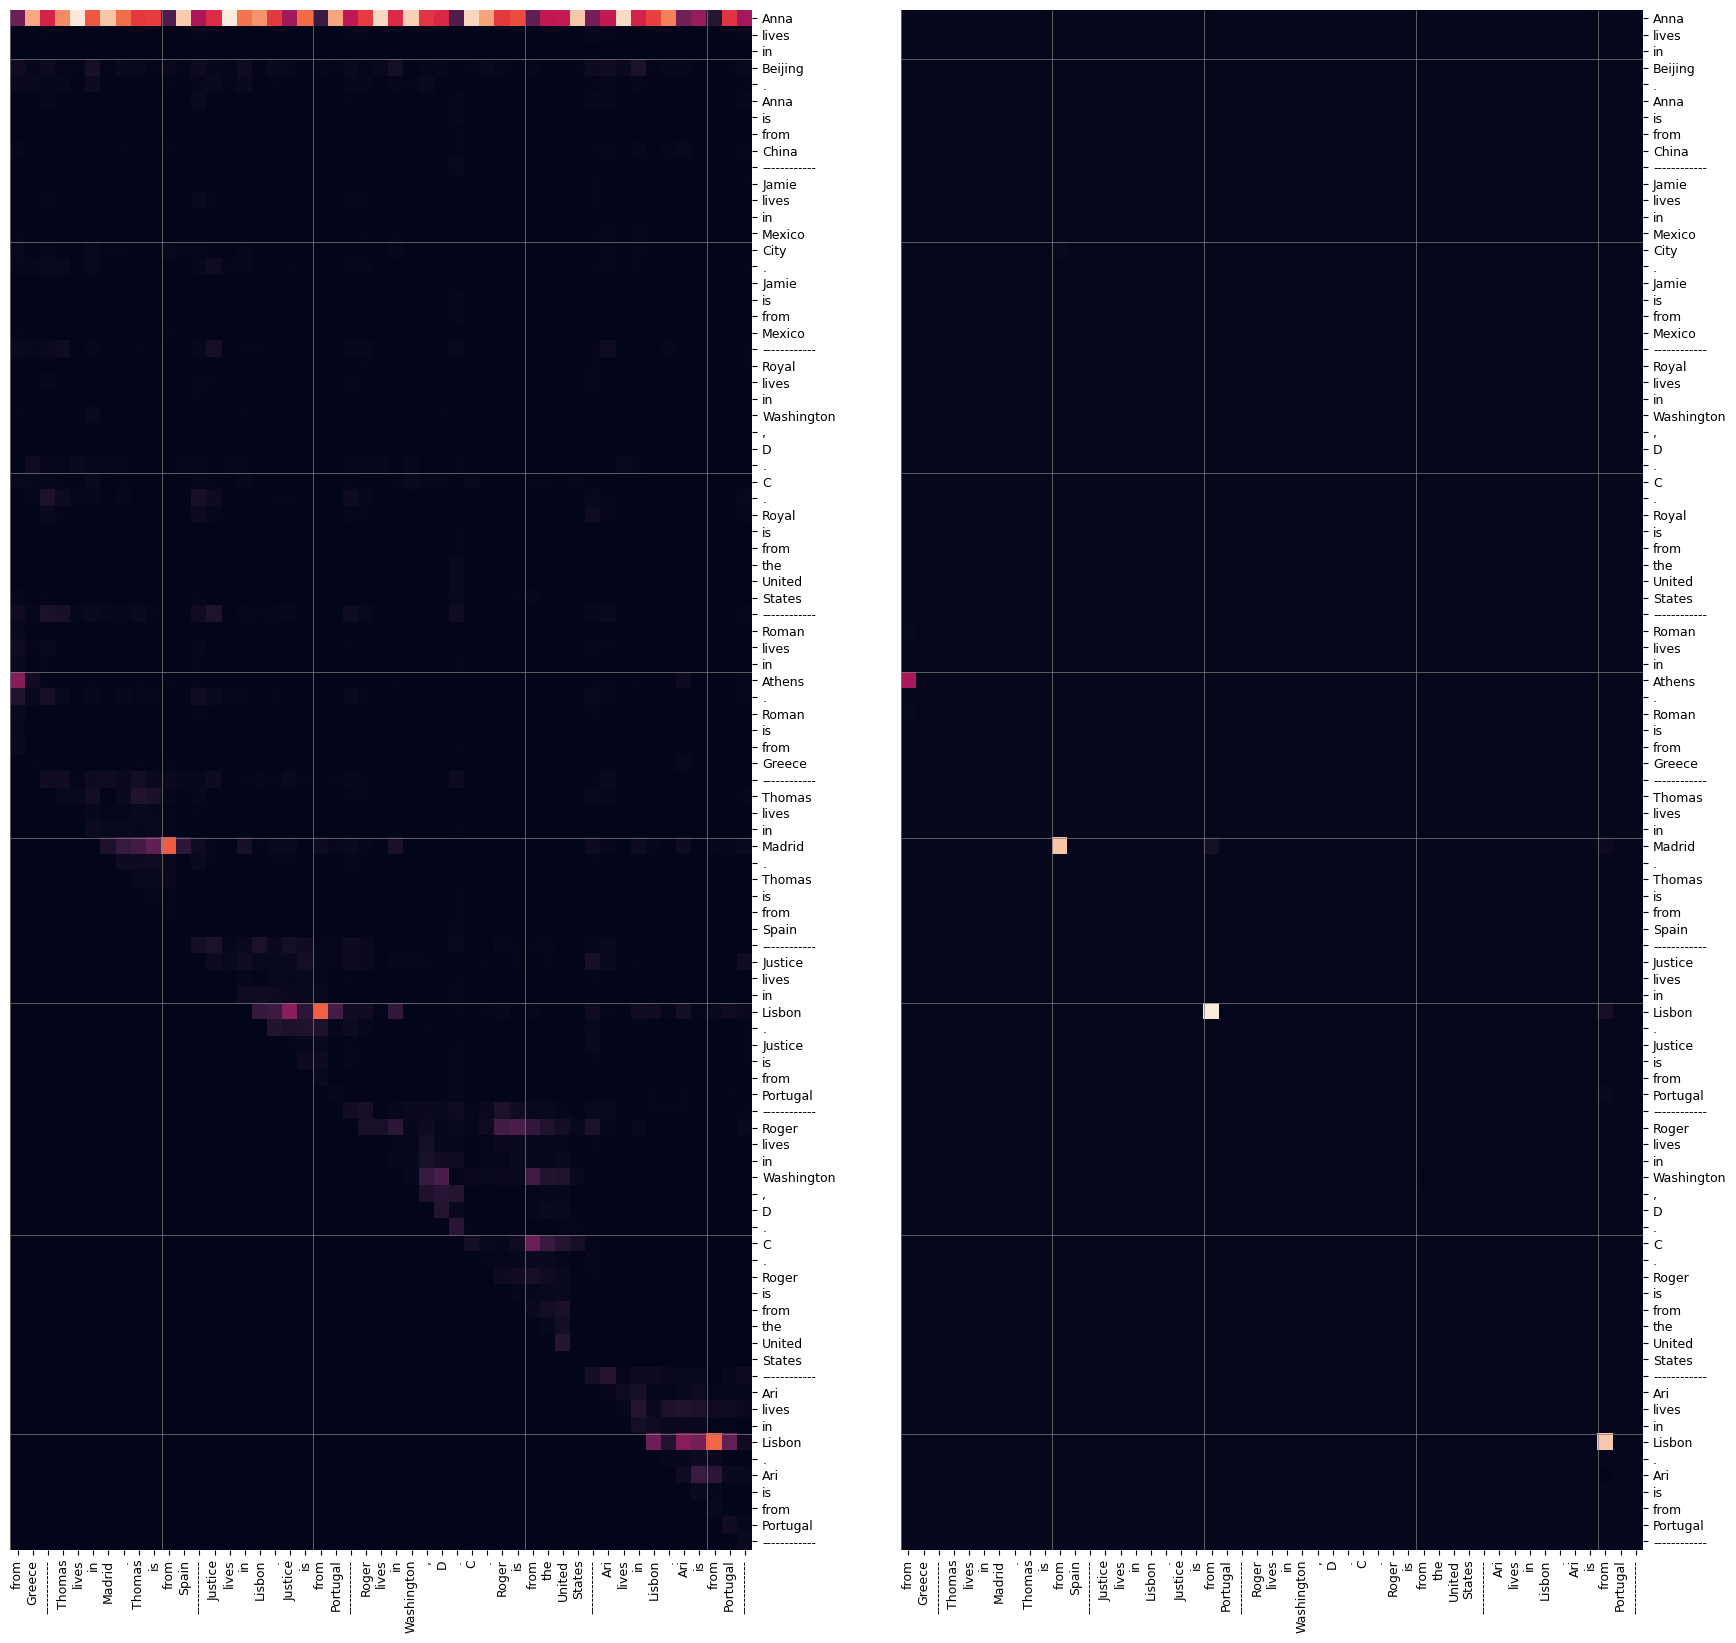

tensor([-10.8277,  -3.3554,  -5.4432,  -7.8336])
 ĠSwitzerland 0.0 {'ĠIndia': 0.879, 'India': 0.073, 'ĠDelhi': 0.024, 'ĠIndian': 0.013} 	 India lives in Bern. India is from Switzerland
 ĠJapan 0.206 {'ĠJapanese': 0.519, 'ĠJapan': 0.206, 'ĠTokyo': 0.163, 'Japan': 0.096} 	 Eva lives in Tokyo. Eva is from Japan
*ĠKenya 0.989 {'ĠKenya': 0.989, 'ĠKenyan': 0.011, 'ĠTanzania': 0.0, 'ĠUganda': 0.0} 	 Collins lives in Nairobi. Collins is from Kenya
*ĠSpain 0.952 {'ĠSpain': 0.952, 'Spain': 0.035, 'ĠSpanish': 0.006, 'ĠMadrid': 0.005} 	 Raven lives in Madrid. Raven is from Spain
 ĠSouth 0.0 {'ĠKorean': 0.696, 'ĠKorea': 0.278, 'ĠSeoul': 0.016, 'ĠKoreans': 0.01} 	 Hunter lives in Seoul. Hunter is from South Korea
 ĠThailand 0.212 {'ĠBangkok': 0.771, 'ĠThailand': 0.212, 'ĠThai': 0.016, 'ĠCambodia': 0.0} 	 Rachel lives in Bangkok. Rachel is from Thailand
*ĠFrance 0.612 {'ĠFrance': 0.612, 'ĠParis': 0.127, 'France': 0.125, 'Paris': 0.099} 	 Wilson lives in Paris. Wilson is from France
*ĠSwitzerland 0.64

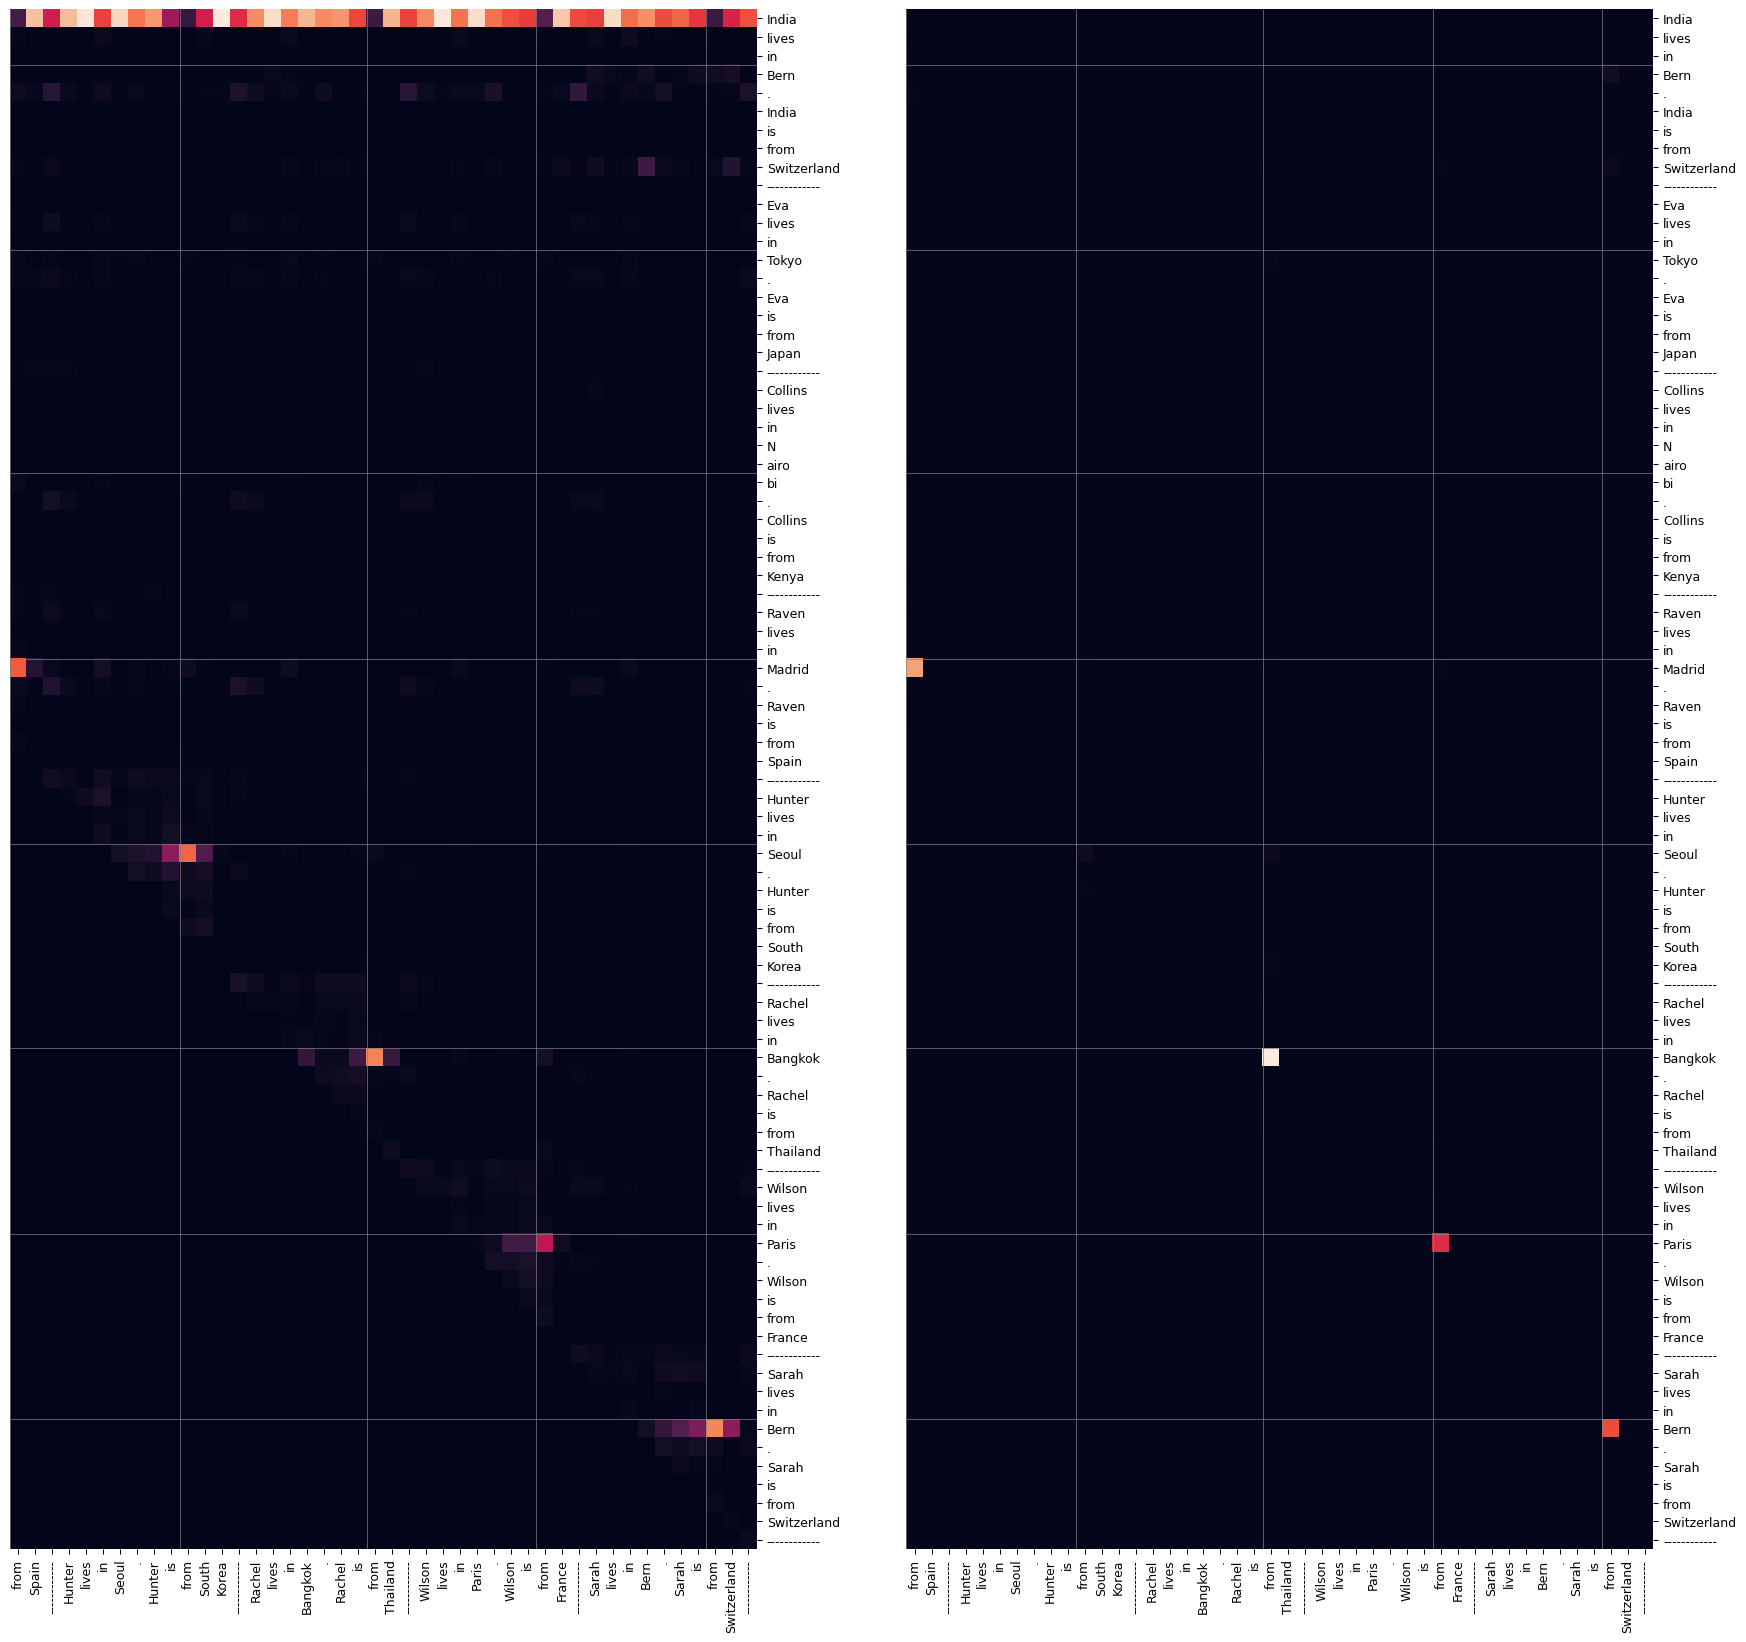

tensor([-10.7588,  -4.1700,  -6.9176, -10.0170])
*ĠAustralia 0.465 {'ĠAustralia': 0.465, 'ĠAustralian': 0.292, 'ĠCanberra': 0.222, 'ĠMelbourne': 0.009} 	 Angelo lives in Canberra. Angelo is from Australia
 ĠSwitzerland 0.285 {'ĠSwiss': 0.714, 'ĠSwitzerland': 0.285, 'ĠZurich': 0.001, 'ĠSchwe': 0.0} 	 Emily lives in Bern. Emily is from Switzerland
*ĠItaly 0.455 {'ĠItaly': 0.455, 'ĠItalian': 0.374, 'Italy': 0.102, 'ĠItalians': 0.039} 	 Leon lives in Rome. Leon is from Italy
 ĠTurkey 0.0 {'ĠTurkish': 0.853, 'ĠAnkara': 0.113, 'ĠIstanbul': 0.02, 'Turkish': 0.007} 	 Ford lives in Ankara. Ford is from Turkey
 ĠRussia 0.011 {'ĠMoscow': 0.848, 'Moscow': 0.096, 'ĠRussian': 0.026, 'ĠRussia': 0.011} 	 Dallas lives in Moscow. Dallas is from Russia
*ĠPortugal 0.775 {'ĠPortugal': 0.775, 'ĠLisbon': 0.126, 'ĠPortuguese': 0.099, 'ĠPortug': 0.0} 	 Sarah lives in Lisbon. Sarah is from Portugal
*ĠItaly 0.565 {'ĠItaly': 0.565, 'ĠItalian': 0.183, 'ĠItalians': 0.114, 'ĠRome': 0.072} 	 Ocean lives in Rome. Ocea

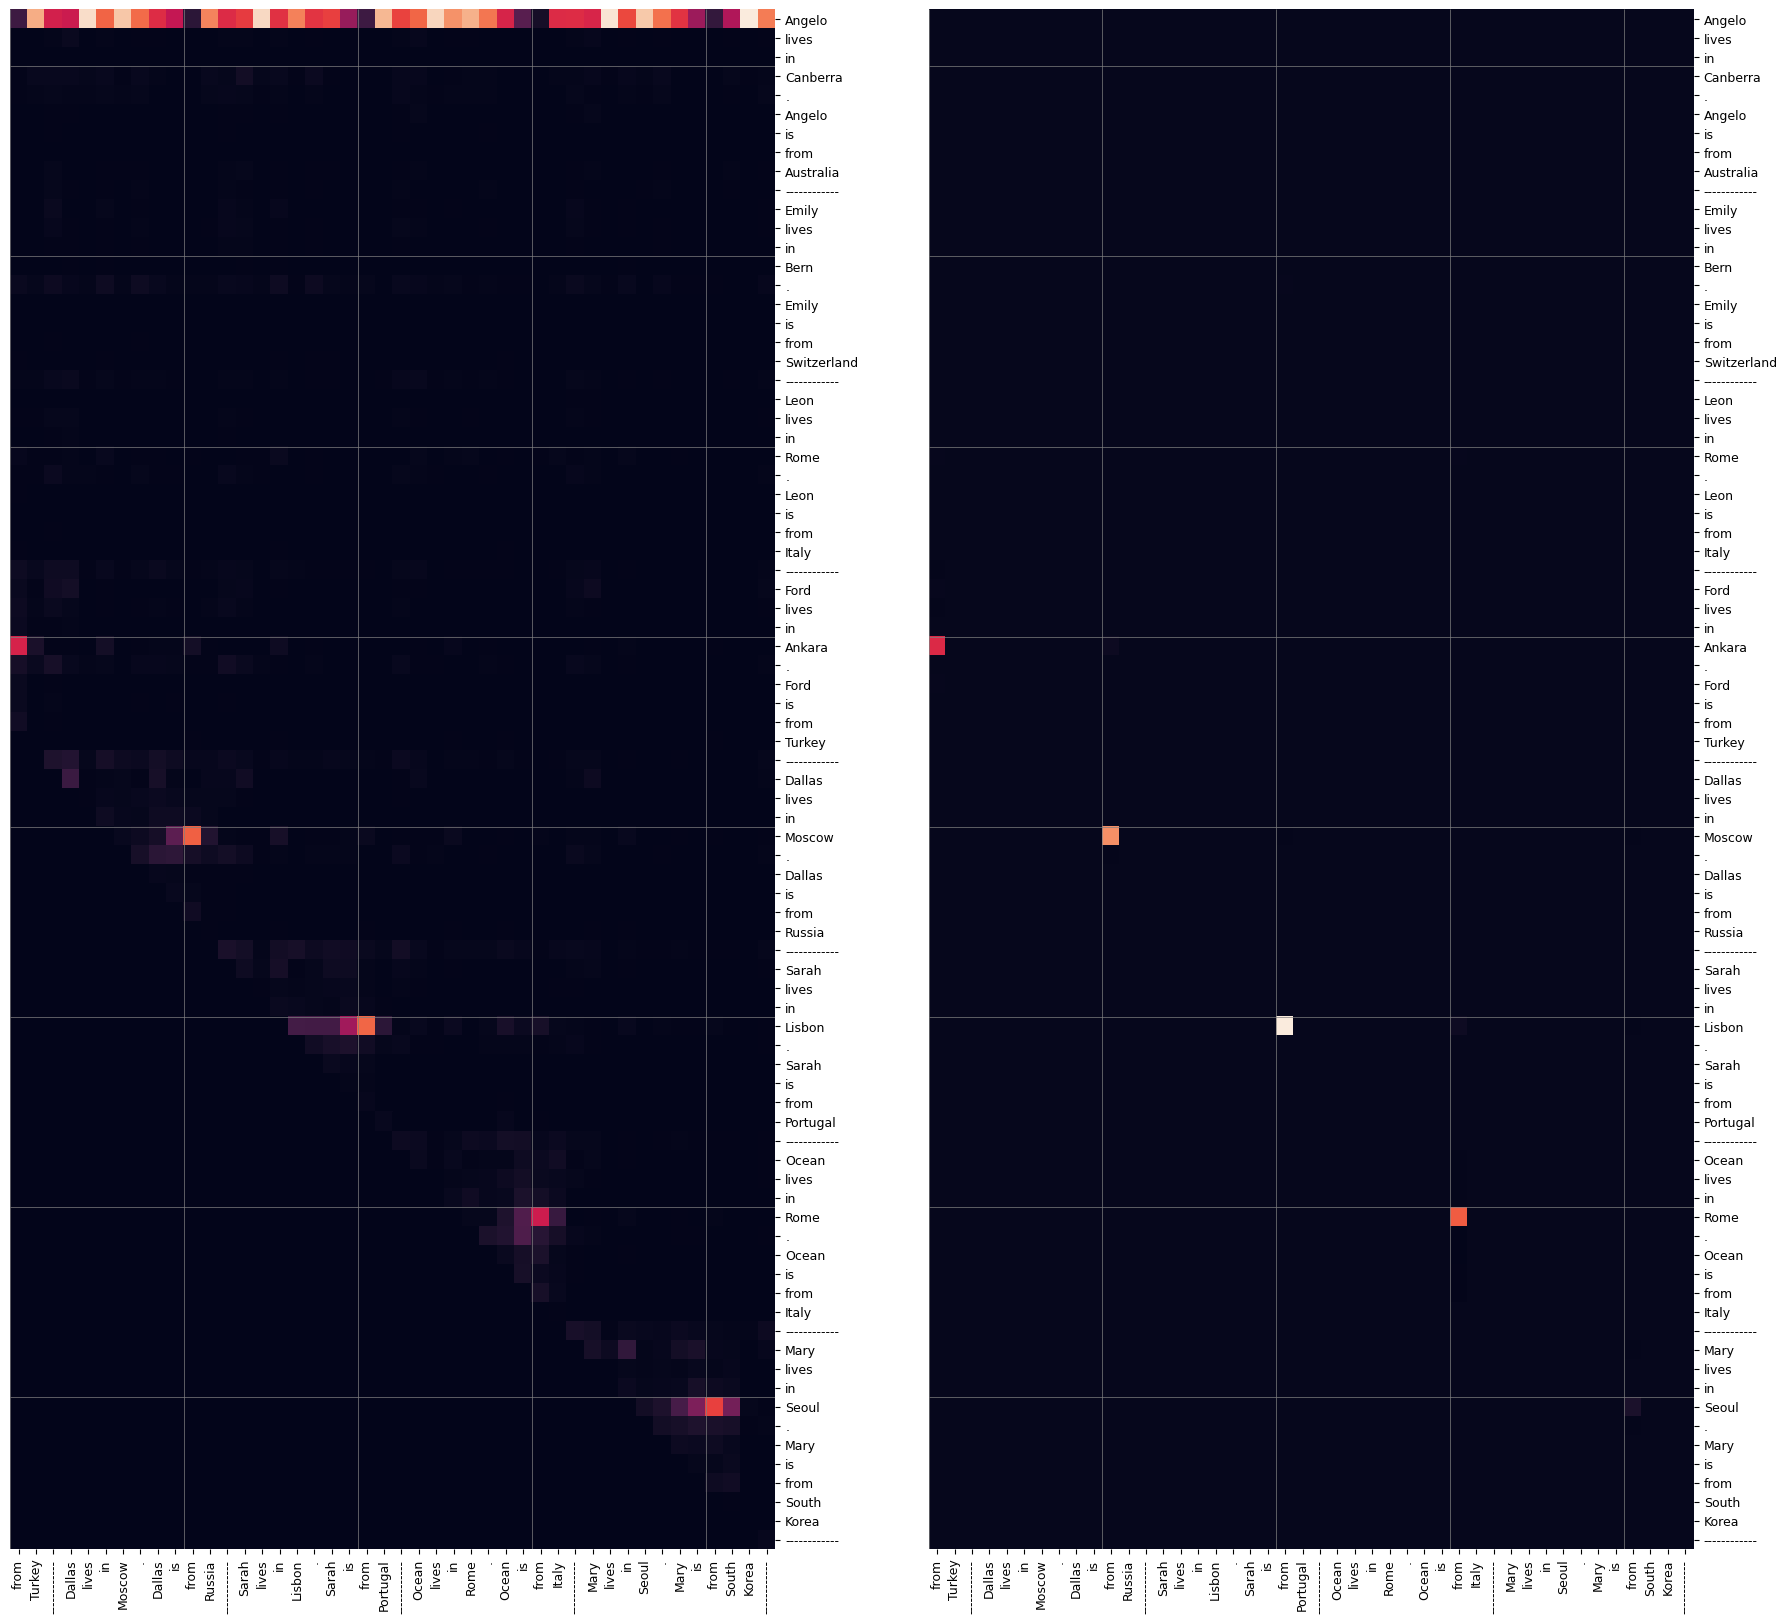

19 12
tensor([-10.3165,  -4.4382,  -8.5525, -12.7915])
 ĠTurkey 0.028 {'ĠTurkish': 0.945, 'ĠTurkey': 0.028, 'ĠAnkara': 0.018, 'Turkish': 0.008} 	 Justice lives in Ankara. Justice is from Turkey
 Ġthe 0.0 {'ĠBritish': 0.847, 'ĠEngland': 0.103, 'ĠUK': 0.022, 'ĠBritain': 0.017} 	 Carl lives in London. Carl is from the United Kingdom
 ĠChina 0.018 {'ĠChinese': 0.979, 'ĠChina': 0.018, 'Chinese': 0.002, 'China': 0.0} 	 Jacob lives in Beijing. Jacob is from China
 Ġthe 0.0 {'ĠPhilippines': 0.864, 'ĠFilipino': 0.114, 'ĠPhilippine': 0.022, 'ĠManila': 0.0} 	 Laura lives in Manila. Laura is from the Philippines
 ĠSouth 0.0 {'ĠKorean': 0.846, 'ĠKorea': 0.142, 'ĠKoreans': 0.011, 'ĠSeoul': 0.001} 	 Victoria lives in Seoul. Victoria is from South Korea
*ĠPortugal 0.614 {'ĠPortugal': 0.614, 'ĠPortuguese': 0.386, 'ĠLisbon': 0.0, 'ĠPortug': 0.0} 	 Dream lives in Lisbon. Dream is from Portugal
 ĠBrazil 0.48 {'ĠBrazilian': 0.492, 'ĠBrazil': 0.48, 'Brazil': 0.028, 'ĠBras': 0.0} 	 Alexander lives in Brasíli

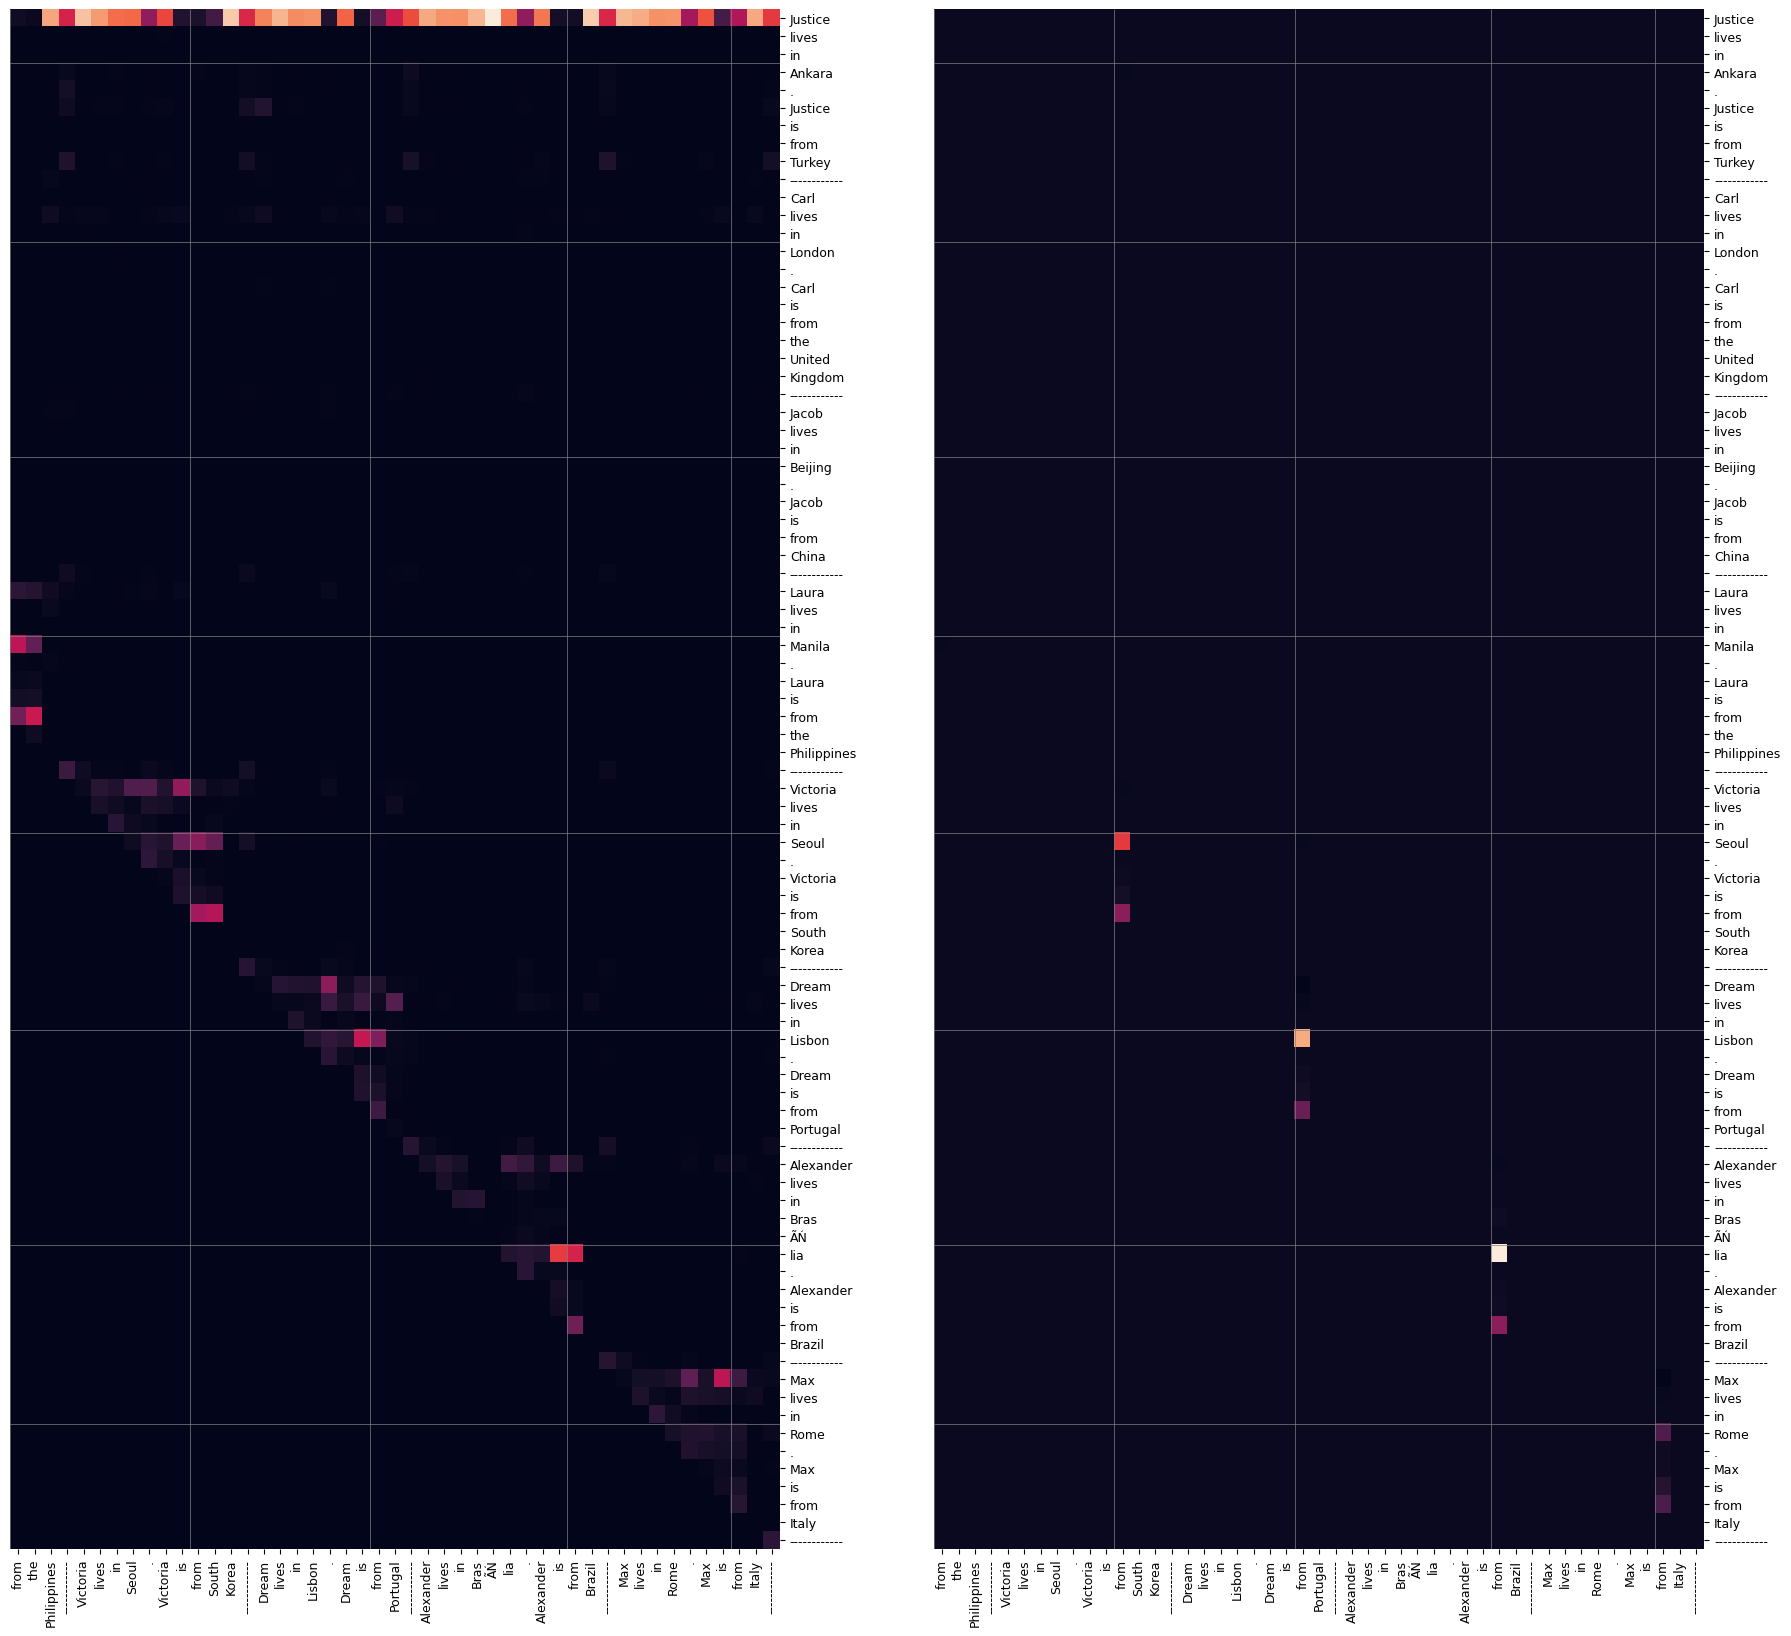

tensor([-10.6084,  -2.8576,  -4.3523,  -6.2969])
 ĠChina 0.0 {'ĠAnna': 0.953, 'Anna': 0.044, 'ĠChinese': 0.003, 'Chinese': 0.0} 	 Anna lives in Beijing. Anna is from China
 ĠMexico 0.111 {'ĠMexican': 0.665, 'Mex': 0.127, 'ĠMexico': 0.111, 'Mexico': 0.095} 	 Jamie lives in Mexico City. Jamie is from Mexico
 Ġthe 0.0 {'ĠRoyal': 0.499, 'Ġroyal': 0.351, 'Royal': 0.144, 'ĠRoyals': 0.004} 	 Royal lives in Washington, D.C. Royal is from the United States
 ĠGreece 0.176 {'ĠGreek': 0.801, 'ĠGreece': 0.176, 'Greek': 0.013, 'ĠGreeks': 0.011} 	 Roman lives in Athens. Roman is from Greece
*ĠSpain 0.563 {'ĠSpain': 0.563, 'Spain': 0.323, 'ĠSpanish': 0.076, 'Spanish': 0.024} 	 Thomas lives in Madrid. Thomas is from Spain
*ĠPortugal 0.829 {'ĠPortugal': 0.829, 'ĠPortuguese': 0.169, 'ĠLisbon': 0.001, 'ĠPortug': 0.0} 	 Justice lives in Lisbon. Justice is from Portugal
 Ġthe 0.0 {'ĠWashington': 0.885, 'Washington': 0.061, 'ĠUS': 0.037, 'ĠUSA': 0.005} 	 Roger lives in Washington, D.C. Roger is from the Unit

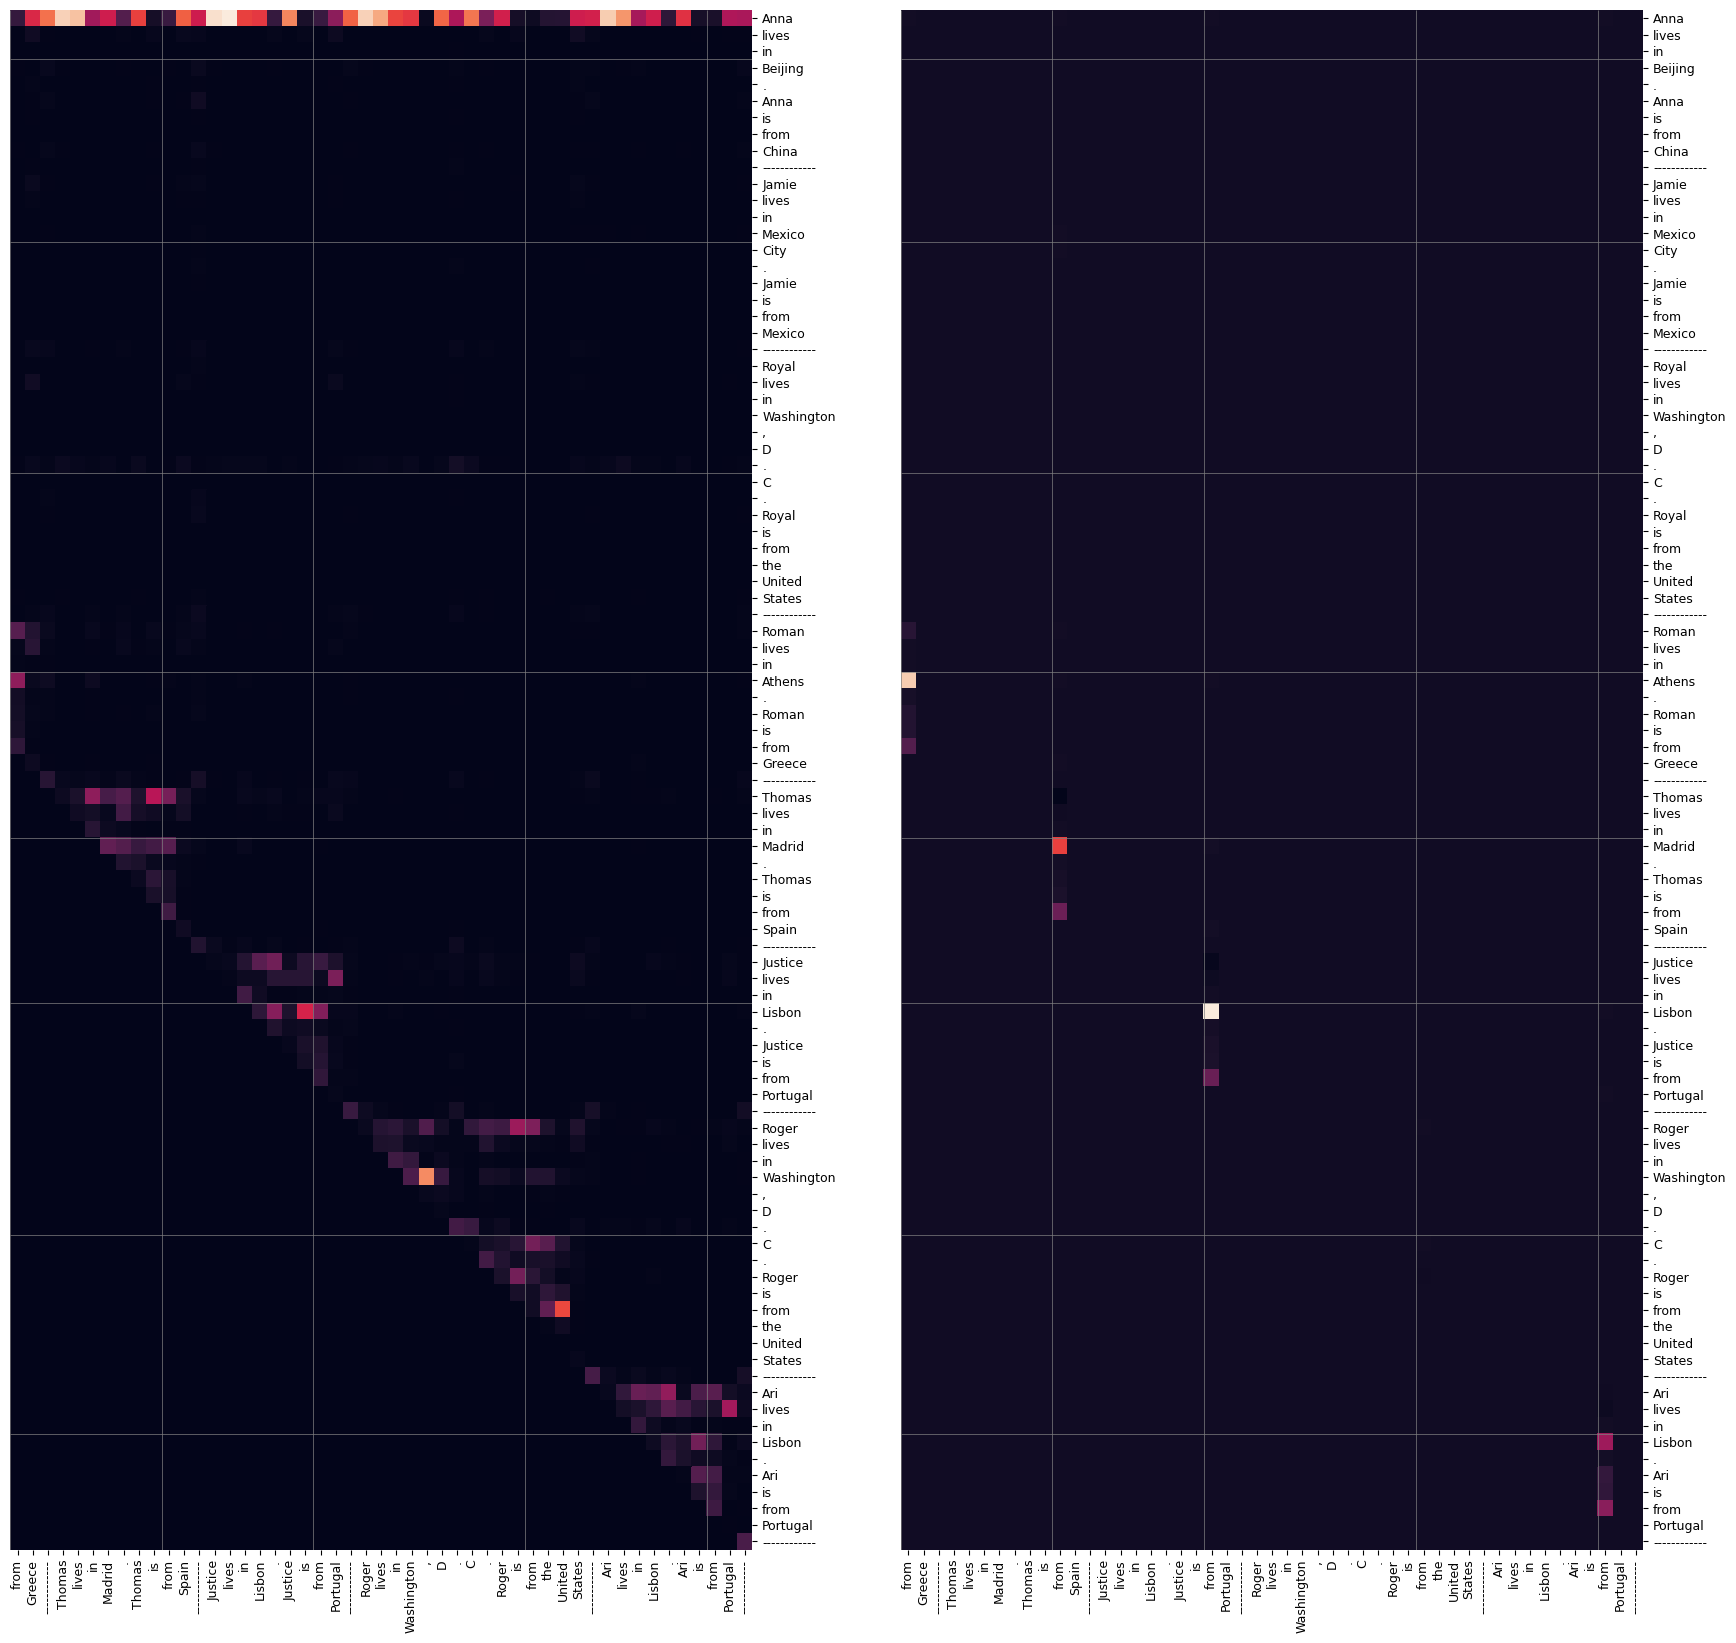

tensor([-10.8724,  -2.7457,  -4.6410,  -6.6507])
 ĠSwitzerland 0.0 {'ĠIndian': 0.7, 'ĠIndia': 0.272, 'India': 0.025, 'Indian': 0.003} 	 India lives in Bern. India is from Switzerland
 ĠJapan 0.068 {'ĠJapanese': 0.926, 'ĠJapan': 0.068, 'Japan': 0.005, 'Japanese': 0.002} 	 Eva lives in Tokyo. Eva is from Japan
 ĠKenya 0.384 {'ĠKenyan': 0.615, 'ĠKenya': 0.384, 'ĠCollins': 0.001, 'ĠAfrican': 0.0} 	 Collins lives in Nairobi. Collins is from Kenya
*ĠSpain 0.475 {'ĠSpain': 0.475, 'ĠSpanish': 0.453, 'Spain': 0.043, 'ĠSpani': 0.016} 	 Raven lives in Madrid. Raven is from Spain
 ĠSouth 0.0 {'ĠKorean': 0.886, 'ĠKorea': 0.107, 'ĠKoreans': 0.006, 'ĠSeoul': 0.0} 	 Hunter lives in Seoul. Hunter is from South Korea
 ĠThailand 0.418 {'ĠThai': 0.581, 'ĠThailand': 0.418, 'ĠBangkok': 0.002, 'ĠAsian': 0.0} 	 Rachel lives in Bangkok. Rachel is from Thailand
 ĠFrance 0.0 {'ĠWilson': 0.972, 'Wilson': 0.027, 'ĠFrench': 0.001, 'ĠFrenchman': 0.0} 	 Wilson lives in Paris. Wilson is from France
 ĠSwitzerland 0.394

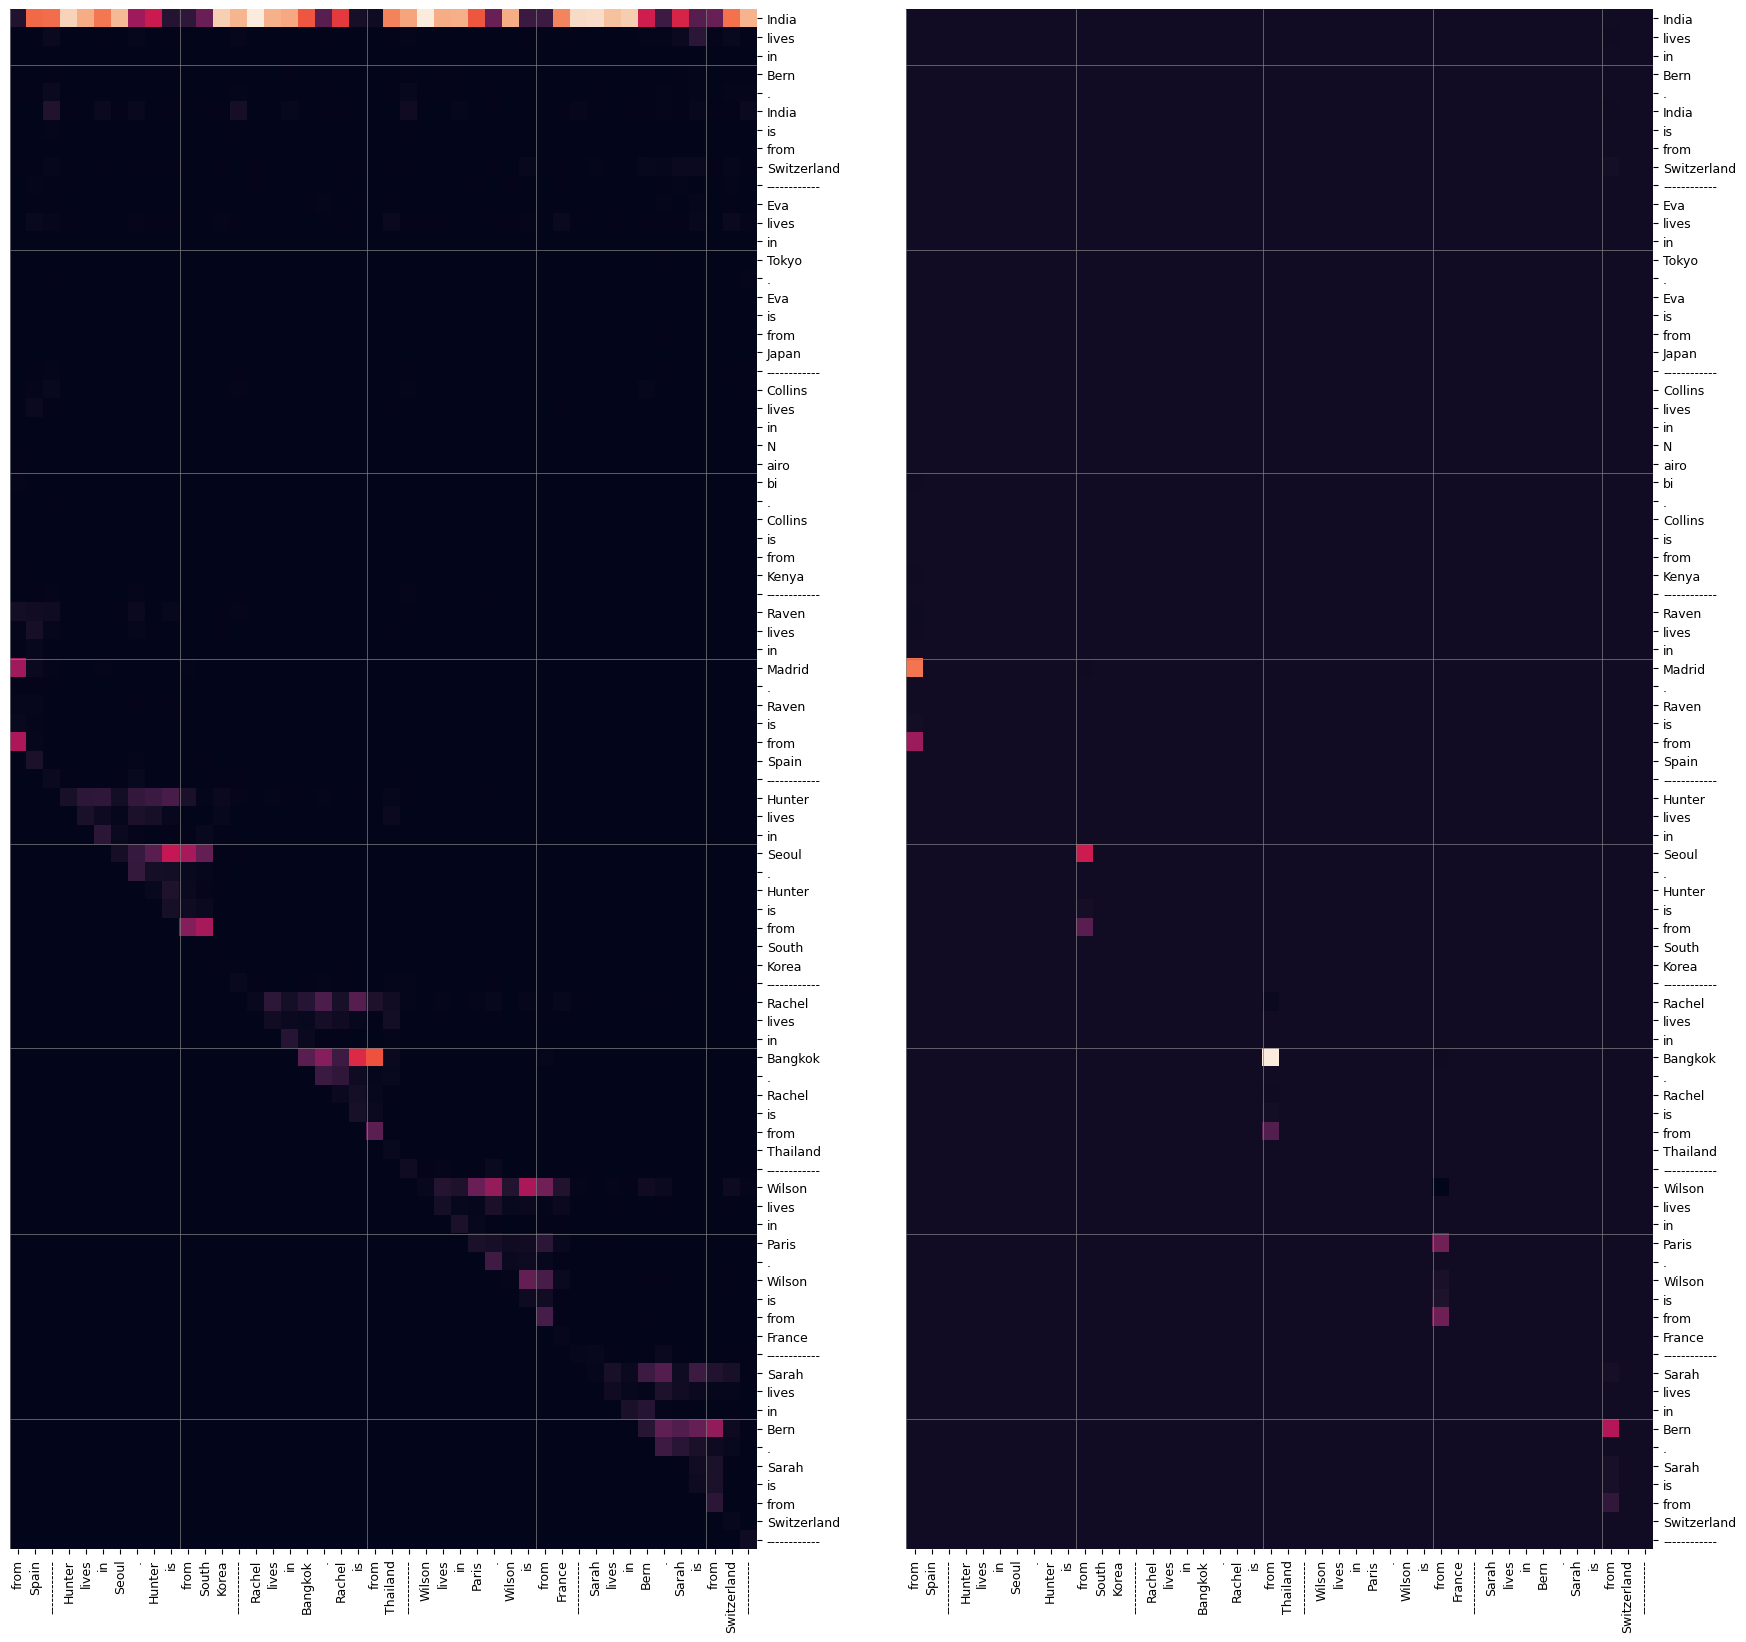

tensor([-10.8346,  -2.5230,  -4.0199,  -5.7525])
 ĠAustralia 0.0 {'ĠItalian': 0.973, 'ĠItalians': 0.014, 'Italian': 0.009, 'ĠItaly': 0.004} 	 Angelo lives in Canberra. Angelo is from Australia
*ĠSwitzerland 0.679 {'ĠSwitzerland': 0.679, 'ĠSwiss': 0.321, 'ĠBern': 0.0, 'ĠZurich': 0.0} 	 Emily lives in Bern. Emily is from Switzerland
 ĠItaly 0.016 {'Leon': 0.43, 'ĠLeon': 0.372, 'ĠLeonardo': 0.11, 'ĠLeone': 0.024} 	 Leon lives in Rome. Leon is from Italy
*ĠTurkey 0.745 {'ĠTurkey': 0.745, 'ĠTurkish': 0.123, 'Turkish': 0.061, 'Turkey': 0.06} 	 Ford lives in Ankara. Ford is from Turkey
 ĠRussia 0.023 {'ĠRussian': 0.95, 'ĠRussians': 0.026, 'ĠRussia': 0.023, 'Russian': 0.001} 	 Dallas lives in Moscow. Dallas is from Russia
*ĠPortugal 0.663 {'ĠPortugal': 0.663, 'ĠPortuguese': 0.337, 'ĠLisbon': 0.0, 'ĠPortug': 0.0} 	 Sarah lives in Lisbon. Sarah is from Portugal
 ĠItaly 0.028 {'ĠRome': 0.899, 'ĠItalian': 0.064, 'ĠItaly': 0.028, 'ĠItalians': 0.009} 	 Ocean lives in Rome. Ocean is from Italy
 ĠSout

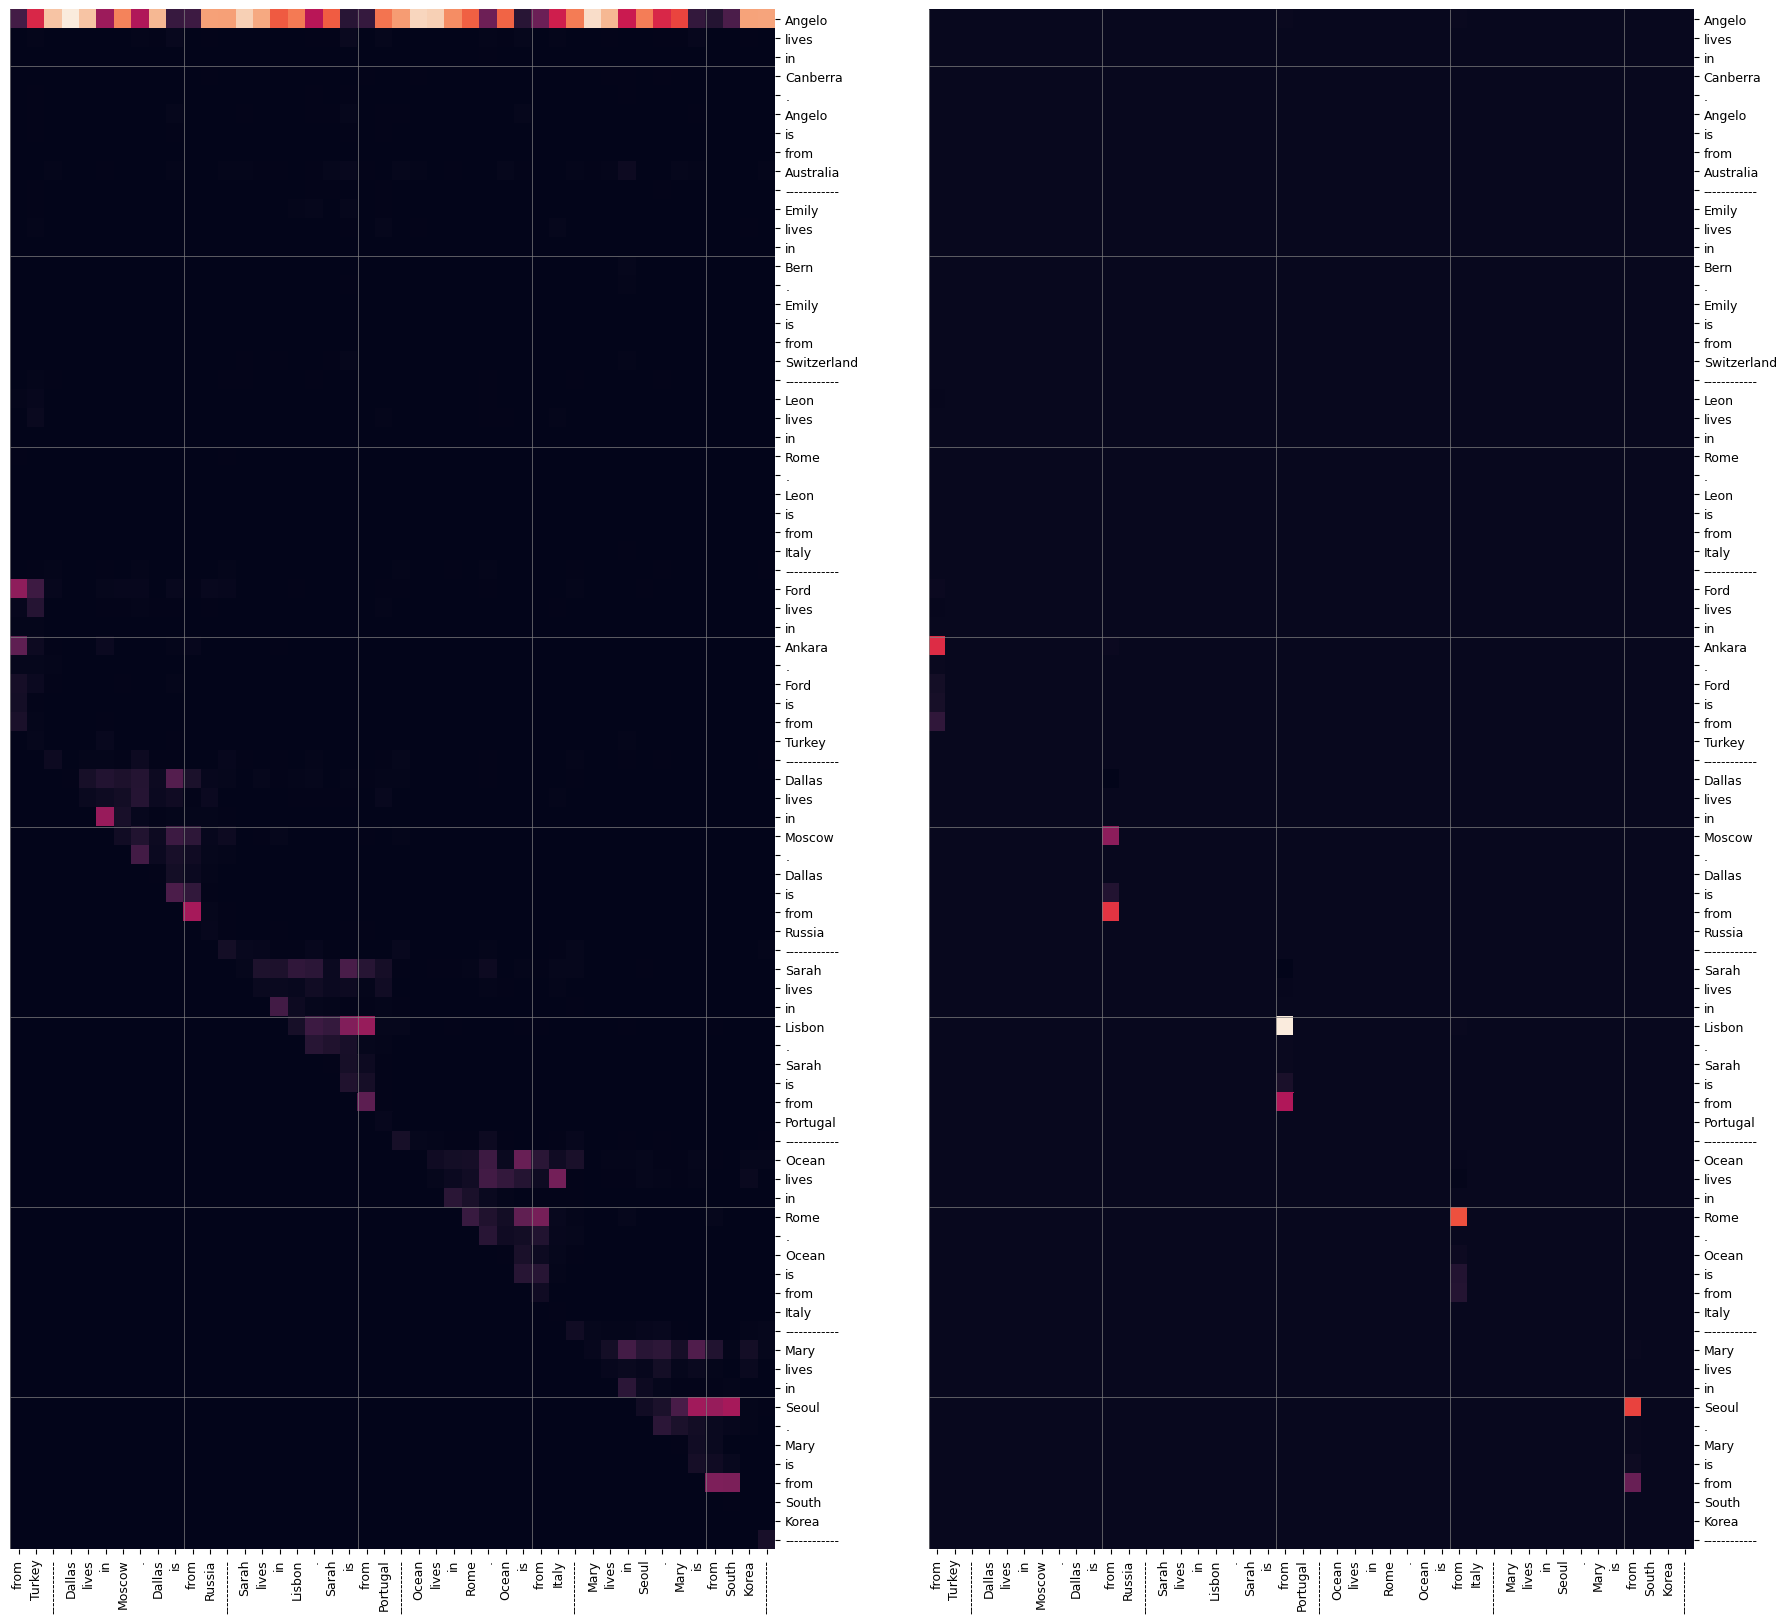

In [474]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2])

In [875]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[2] 19-12 attn_labels┐
                                              └[1] top[0, 1, 2, 3] 13-13,8-1,12-10,11-0┐
                                                                                       └*[2] top[0] 5-12...


Bo lives in Athens. Carl lives in Berlin. Bo is from Athens
Christopher lives in Mexico City. Morgan lives in Ottawa. Morgan is from Ottawa
August lives in Berlin. Ruby lives in Canada. August is from Berlin
 [-1] root labels┐
                 └[0] top[0, 1] 16-0,16-7 attn_labels┐
                                                     └[1] top[0, 1, 2] 8-1,13-13,12-10┐
                                                                                      └*[2] top[0, 1, 2, 3, 4] 6-2,1-7,3-12,8-7,6-10...
[-1] root labels


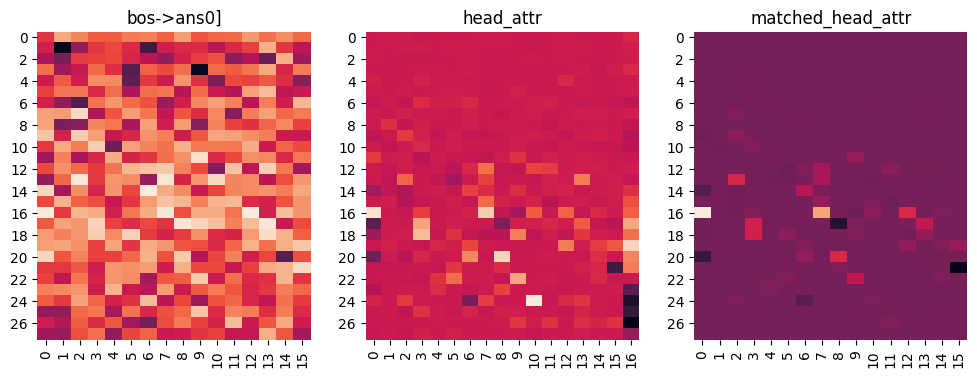

(array([16, 14, 16, 13, 16, 17, 17, 13, 11, 21]),
 array([ 0,  6, 12,  2,  7, 13,  8,  7,  9, 15]),
 array([-1.3288975, -1.3305348, -1.3627592, -1.4088558, -1.4976463,
       -1.499613 , -1.5131693, -1.5281231, -1.6476071, -1.8046031],
      dtype=float32))
(array([24, 16, 20, 19, 16, 18, 17, 22, 17, 20]),
 array([10,  0,  8, 16,  7,  3, 16,  9,  3,  6]),
 array([0.83582604, 0.8029555 , 0.7381003 , 0.73617625, 0.6969557 ,
       0.62472516, 0.5496335 , 0.53898   , 0.5320116 , 0.42316008],
      dtype=float32))
(array([16, 16, 20, 16, 13, 17, 18, 17, 22, 14]),
 array([ 0,  7,  8, 12,  2,  3,  3, 13,  9,  6]),
 array([0.21259774, 0.15587829, 0.07418858, 0.07292817, 0.07134783,
       0.06707115, 0.06559796, 0.05751253, 0.05405492, 0.04663789],
      dtype=float32))
[0] top[0, 1] 16-0,16-7 attn_labels


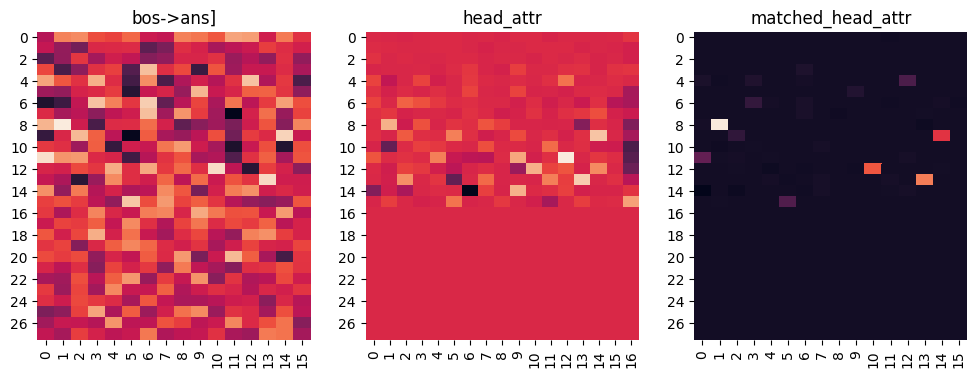

(array([ 8, 11, 12, 13,  9,  6, 15,  6,  4,  3]),
 array([ 1,  0, 10, 13, 14,  6,  5,  3, 12,  6]),
 array([-1.9514141, -2.3488255, -2.4113407, -2.489871 , -2.6965308,
       -2.8692653, -3.103426 , -3.1731105, -3.1838531, -3.2478652],
      dtype=float32))
(array([11, 13,  9, 14,  8, 12, 11, 15, 13, 12]),
 array([12, 13, 14,  9,  1, 10,  9, 16,  2, 14]),
 array([1.2294738 , 1.0032799 , 0.9460625 , 0.81965804, 0.8191863 ,
       0.81483126, 0.7492655 , 0.7142401 , 0.6066006 , 0.5751997 ],
      dtype=float32))
(array([ 8, 13, 12,  9, 11, 15,  4,  6,  9,  5]),
 array([ 1, 13, 10, 14,  0,  5, 12,  3,  2,  9]),
 array([0.11638427, 0.08319264, 0.07308626, 0.06380157, 0.02548152,
       0.01938173, 0.01808166, 0.01033581, 0.00938567, 0.00518399],
      dtype=float32))
[1] top[0, 1, 2] 8-1,13-13,12-10


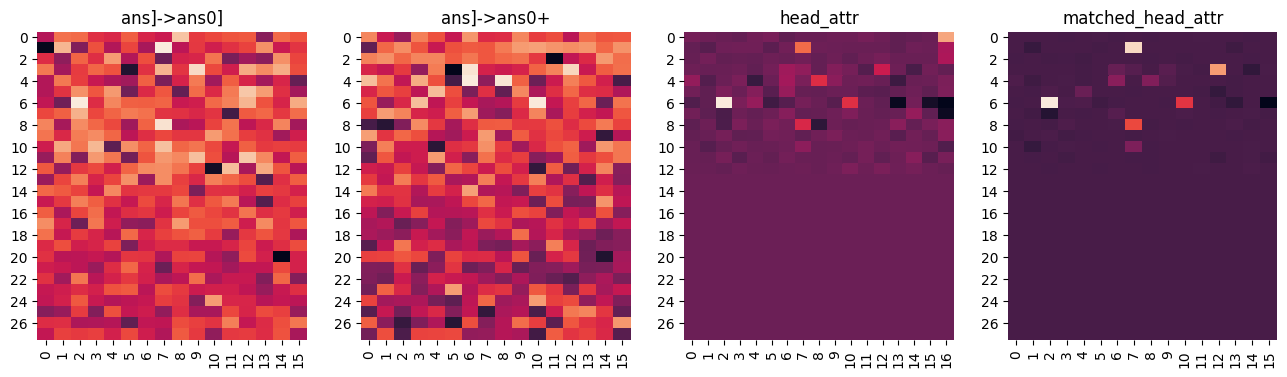

(array([ 6,  1,  8,  3, 11,  5,  0, 10, 11, 12]),
 array([ 2,  7,  7,  9, 12, 12,  8,  7,  9, 11]),
 array([-0.29563287, -0.29856926, -0.5963911 , -0.858142  , -1.4844072 ,
       -1.4849362 , -1.5643399 , -1.6877527 , -1.7045727 , -1.766141  ],
      dtype=float32))
(array([4, 6, 4, 3, 3, 4, 6, 5, 4, 1]),
 array([ 6, 10,  8,  6, 12,  0,  3,  4,  3, 10]),
 array([-0.41375035, -0.46466488, -0.57811064, -0.6015241 , -0.9390356 ,
       -1.5189505 , -1.528825  , -1.5703702 , -1.9797645 , -2.196197  ],
      dtype=float32))
(array([6, 0, 1, 6, 4, 8, 3, 2, 1, 4]),
 array([ 2, 16,  7, 10,  8,  7, 12, 16, 16,  6]),
 array([1.5166017 , 1.1418262 , 0.8637782 , 0.6062534 , 0.5906905 ,
       0.5521585 , 0.47588474, 0.31910214, 0.29902315, 0.26566285],
      dtype=float32))
(array([ 6,  1,  3,  8,  6,  4,  4, 10,  5,  3]),
 array([ 2,  7, 12,  7, 10,  6,  8,  7,  4,  6]),
 array([0.12341819, 0.11587791, 0.09278938, 0.06545615, 0.05880314,
       0.02373844, 0.02093031, 0.01953756, 0.01284882, 0.0

In [876]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [880]:
print(key); node = add_node_to_result(result, topi=[0,1])

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0, 1] 16-0,16-7 attn_labels┐
                                                     └[1] top[0, 1, 2] 8-1,13-13,12-10┐
                                                                                      └*[2] top[0, 1] 6-2,1-7...


[[(6, 2, -0.296)], [(8, 1, -1.951), (13, 13, -2.49), (12, 10, -2.411)], [(16, 0, -1.329), (16, 7, -1.498)]]


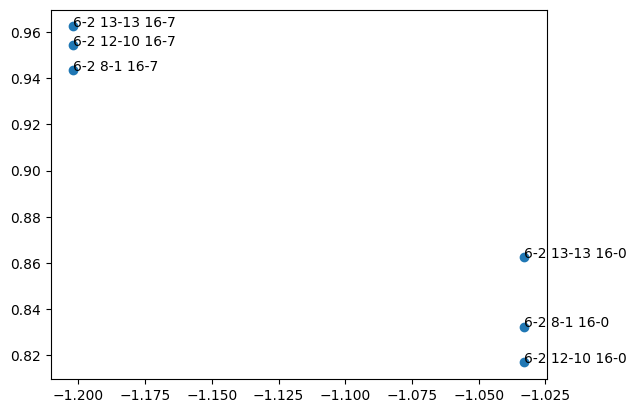

In [881]:
analyze_head_chains(model, get_head2scores(node));

Bo lives in Brasília. Carl lives in Mexico City. Bo is from Brazil
Christopher lives in Bangkok. Morgan lives in Ottawa. Morgan is from Canada
August lives in Beijing. Ruby lives in Moscow. August is from China
                 ┌[0] top[0, 1, 3] 16-0,12-7,19-12 attn_labels┐
                 │                                            └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                 │                                                                                             └[2] top[0, 1, 3] 5-12,3-12,1-7
 [-1] root labels┤
                 └[0] top[0, 1, 3] 16-0,12-7,19-12 argmax_attn_labels┐
                                                                     └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                                                                                                                      └*[2] top[0, 1, 2] 5-12,1-7,3-12...
[-1] root labels


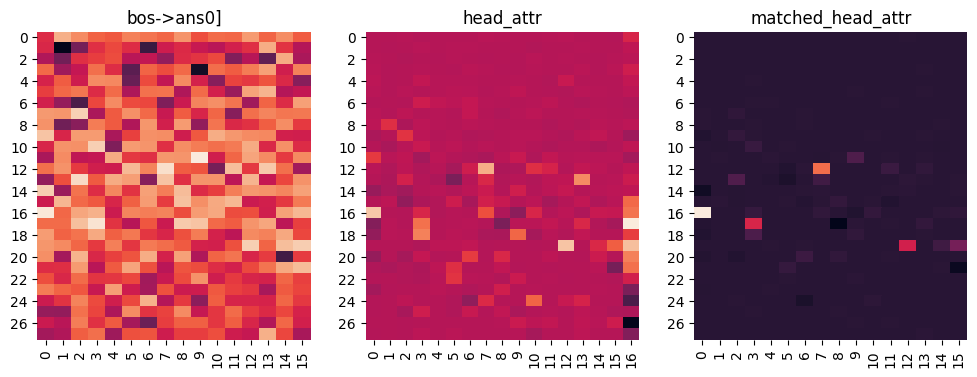

(array([11, 16, 17, 12, 13,  7, 10, 19, 19, 14]),
 array([ 9,  0,  3,  7,  2,  2,  3, 12, 15,  0]),
 array([-1.1805654, -1.2904716, -1.437311 , -1.5688195, -1.6804394,
       -2.0120149, -2.0358503, -2.0490222, -2.0688548, -2.0724943],
      dtype=float32))
(array([17, 16, 19, 19, 12, 13, 20, 18, 16, 21]),
 array([16,  0, 12, 16,  7, 13, 16,  3, 16, 16]),
 array([0.8685818 , 0.7155201 , 0.7043894 , 0.6862899 , 0.6186234 ,
       0.4928573 , 0.4540257 , 0.45271584, 0.40817076, 0.4015888 ],
      dtype=float32))
(array([16, 12, 17, 19, 19, 13, 11, 18, 13, 19]),
 array([ 0,  7,  3, 12, 15,  2,  9,  3,  7, 14]),
 array([0.19686891, 0.12885363, 0.0947455 , 0.09076821, 0.04233965,
       0.02215736, 0.02180293, 0.02030192, 0.01336572, 0.0123677 ],
      dtype=float32))
[0] top[0, 1, 3] 16-0,12-7,19-12 argmax_attn_labels


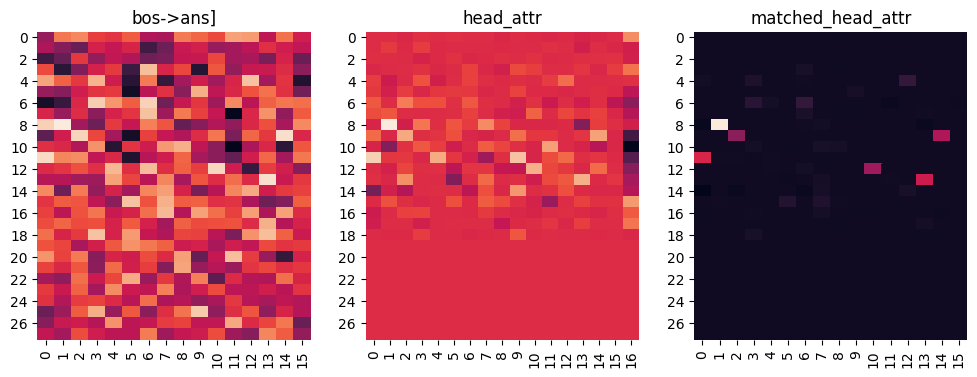

(array([ 8, 13,  9, 11, 12,  9,  6,  8,  6, 25]),
 array([ 1, 13, 14,  0, 10,  2,  6,  0,  3,  9]),
 array([-1.7855884, -2.0952206, -2.130491 , -2.2637904, -2.3503032,
       -2.4313354, -2.5269203, -2.5658863, -2.6493416, -2.7442076],
      dtype=float32))
(array([ 8, 11, 11, 12, 13, 11,  9,  9, 10, 15]),
 array([ 1,  0,  9, 10, 13,  4,  2, 14, 11, 16]),
 array([125.75547 , 104.74787 ,  95.36834 ,  82.49108 ,  82.20734 ,
        78.589676,  76.4427  ,  72.20157 ,  71.51051 ,  67.07172 ],
      dtype=float32))
(array([ 8, 11, 13,  9, 12,  9,  6,  4,  6, 15]),
 array([ 1,  0, 13, 14, 10,  2,  6, 12,  3,  5]),
 array([21.088987 , 10.889139 , 10.115046 ,  8.576027 ,  7.8647203,
        6.720792 ,  2.117462 ,  2.078264 ,  1.4833612,  1.1182349],
      dtype=float32))
[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10


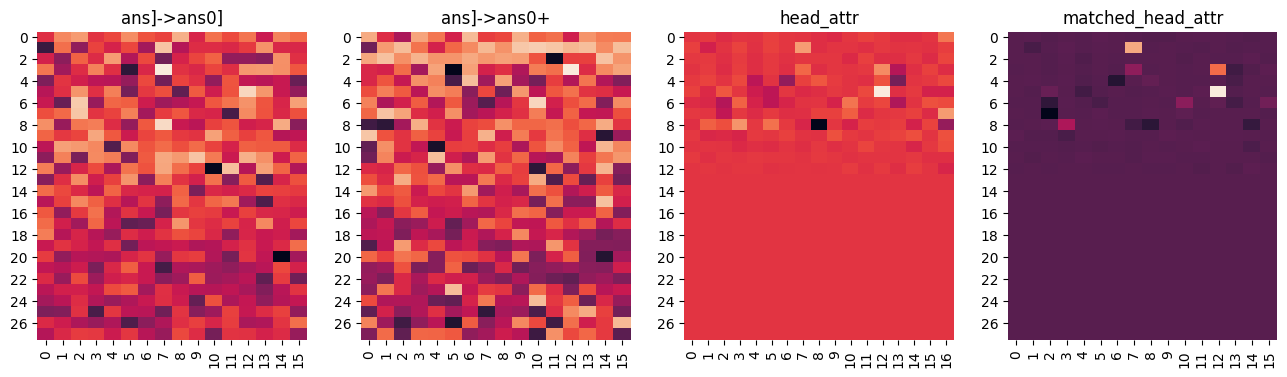

(array([ 3,  8,  5,  6,  7,  1, 11, 12, 11,  0]),
 array([ 7,  7, 12,  2,  2,  7,  9, 11, 12,  8]),
 array([-0.61562794, -1.1192677 , -1.2378955 , -1.5842346 , -1.7106717 ,
       -1.7589614 , -1.7813857 , -1.8983191 , -2.3354354 , -2.3577268 ],
      dtype=float32))
(array([ 3,  6,  1,  1,  9,  1,  2,  7,  2, 15]),
 array([12, 10, 10,  9,  0, 11, 14,  1,  1, 14]),
 array([-1.4686711, -1.9352639, -2.1320124, -2.2571776, -2.260981 ,
       -2.2744708, -2.32167  , -2.3365078, -2.3607073, -2.3668222],
      dtype=float32))
(array([5, 1, 7, 8, 3, 0, 6, 8, 3, 6]),
 array([12,  7, 16,  3, 12, 16, 10,  5,  7,  3]),
 array([187.65778 ,  97.962555,  96.05014 ,  90.71257 ,  80.564354,
        60.32404 ,  59.1686  ,  55.56412 ,  47.260704,  41.657387],
      dtype=float32))
(array([5, 1, 3, 8, 3, 6, 6, 5, 4, 6]),
 array([12,  7, 12,  3,  7, 10, 15,  2,  8, 12]),
 array([14.483035  , 11.292467  ,  8.700681  ,  3.7441878 ,  2.4364793 ,
        2.2838955 ,  1.201804  ,  0.7948787 ,  0.55621827,  0.3

In [802]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [677]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 16-0,12-7,19-12 attn_labels┐
                 │                                            └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                 │                                                                                             └[2] top[0, 1, 3] 5-12,3-12,1-7
 [-1] root labels┤
                 └[0] top[0, 1, 3] 16-0,12-7,19-12 argmax_attn_labels┐
                                                                     └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                                                                                                                      └*[2] top[0, 1, 2] 5-12,1-7,3-12...


[[(5, 12, -1.238)], [(8, 1, -1.786), (11, 0, -2.264), (13, 13, -2.095), (9, 14, -2.13), (12, 10, -2.35)], [(16, 0, -1.29), (12, 7, -1.569), (19, 12, -2.049)]]


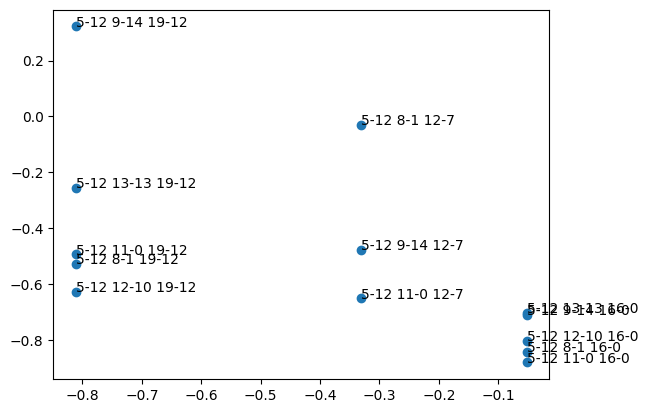

[(((5, 12), (8, 1), (16, 0)), -0.8428910970687866, -0.051999927),
 (((5, 12), (8, 1), (12, 7)), -0.030665799975395203, -0.33099997),
 (((5, 12), (8, 1), (19, 12)), -0.5285608768463135, -0.811),
 (((5, 12), (11, 0), (16, 0)), -0.8814032077789307, -0.051999927),
 (((5, 12), (11, 0), (12, 7)), -0.6516086459159851, -0.33099997),
 (((5, 12), (11, 0), (19, 12)), -0.4943164885044098, -0.811),
 (((5, 12), (13, 13), (16, 0)), -0.7047533988952637, -0.051999927),
 (((5, 12), (13, 13), (19, 12)), -0.25689059495925903, -0.811),
 (((5, 12), (9, 14), (16, 0)), -0.7109839916229248, -0.051999927),
 (((5, 12), (9, 14), (12, 7)), -0.4771130084991455, -0.33099997),
 (((5, 12), (9, 14), (19, 12)), 0.3221599757671356, -0.811),
 (((5, 12), (12, 10), (16, 0)), -0.8043627142906189, -0.051999927),
 (((5, 12), (12, 10), (19, 12)), -0.628407895565033, -0.811)]

In [806]:
analyze_head_chains(model, get_head2scores(node))

Joy is hardworking. So Joy's not lazy
Anne is harsh. So Anne's not gentle
Morgan is rational. So Morgan's not irrational
 [-1] root labels┐
                 └[0] top[0] 16-14 attn_labels┐
                                              └*[1] top[0, 1] 8-1,12-10
[-1] root labels


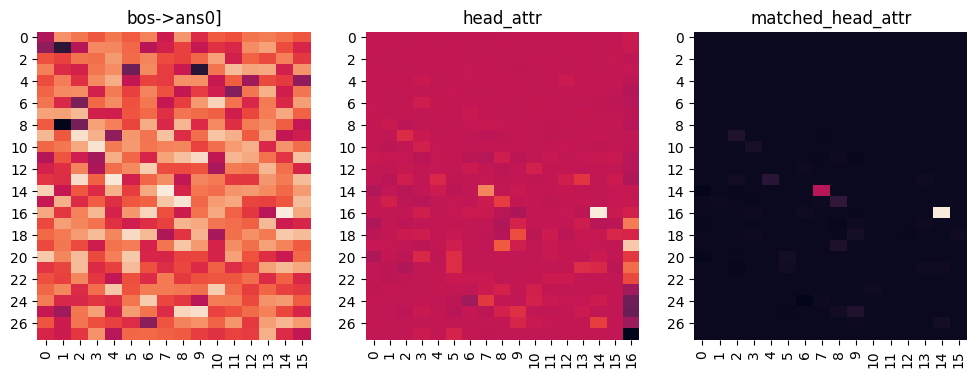

(array([16, 14, 13, 15, 10,  9, 25, 13, 11, 18]),
 array([14,  7,  4,  8,  3,  2,  9,  2,  9,  5]),
 array([-0.22404538, -0.26426464, -0.32291535, -0.47671288, -0.52815974,
       -0.5657489 , -0.6306189 , -0.758794  , -0.7767543 , -0.8513253 ],
      dtype=float32))
(array([16, 19, 14, 17, 21, 19, 18, 22, 26, 15]),
 array([14, 16,  7, 16, 16,  8,  9, 16, 14,  8]),
 array([1.7829967 , 1.4742178 , 0.92033106, 0.8625574 , 0.7433384 ,
       0.6010051 , 0.5150038 , 0.48811558, 0.40587863, 0.3955037 ],
      dtype=float32))
(array([16, 14, 15, 13, 25,  9, 19, 10, 18, 26]),
 array([14,  7,  8,  4,  9,  2,  8,  3,  9, 14]),
 array([7.9581943 , 3.4826114 , 0.8296476 , 0.6714766 , 0.47457597,
       0.46025598, 0.40867478, 0.27440712, 0.25377205, 0.2051951 ],
      dtype=float32))
[0] top[0] 16-14 attn_labels


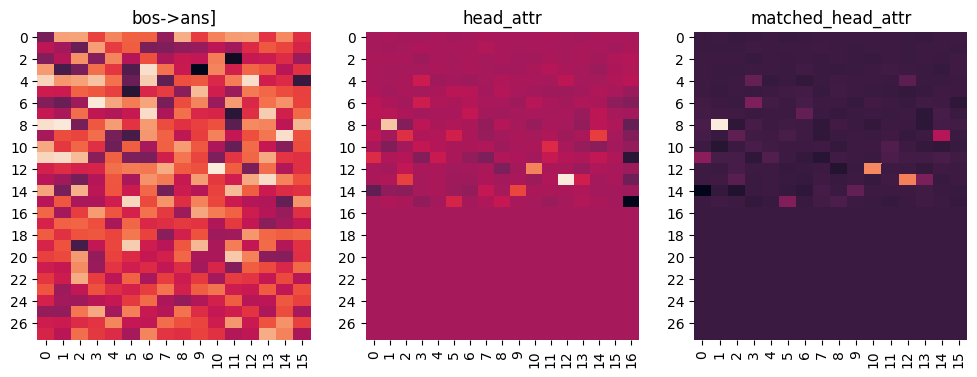

(array([12,  6,  8,  8,  3,  4,  9,  7, 13, 11]),
 array([10,  3,  1,  0,  6, 12, 14,  6, 13,  1]),
 array([-2.0619197, -2.147152 , -2.1584582, -2.3844886, -2.3936834,
       -2.3952484, -2.4289227, -2.4505653, -2.4905105, -2.51614  ],
      dtype=float32))
(array([13,  8, 12, 14, 13,  9,  9, 11, 10, 15]),
 array([12,  1, 10,  9,  2, 14,  2,  0, 11,  5]),
 array([2.1855073 , 1.794246  , 1.2097158 , 0.75793827, 0.69399714,
       0.6832046 , 0.5568255 , 0.5192549 , 0.5060235 , 0.4414171 ],
      dtype=float32))
(array([ 8, 12, 13,  9, 11, 15,  6, 13,  4,  7]),
 array([ 1, 10, 12, 14,  0,  5,  3, 13,  3,  6]),
 array([0.83126277, 0.58669394, 0.5659246 , 0.28127885, 0.19405212,
       0.16885033, 0.15801533, 0.15140642, 0.10328428, 0.0972256 ],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


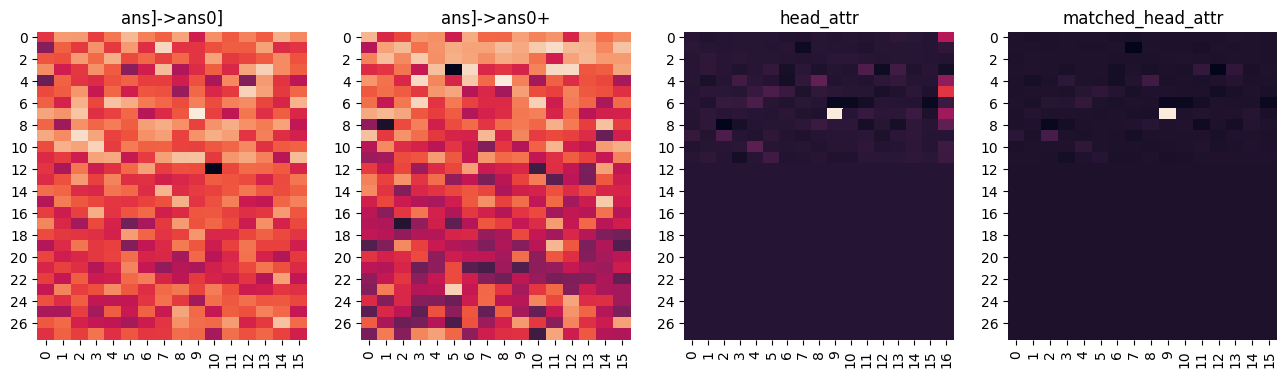

(array([ 7,  9,  1, 10,  5,  3,  7,  6, 26, 11]),
 array([ 9,  2,  7,  3, 12, 13,  2,  4, 14,  9]),
 array([-0.4647833 , -0.91090393, -1.0842161 , -1.2195952 , -1.2474614 ,
       -1.2913882 , -1.6618898 , -1.7153547 , -1.7185242 , -1.7532122 ],
      dtype=float32))
(array([ 4,  1,  4,  3,  3,  3,  6, 23,  6,  1]),
 array([ 8, 11,  3, 12,  6, 11,  3,  5, 10, 10]),
 array([-0.65721524, -1.0485238 , -1.0864106 , -1.0934249 , -1.1174902 ,
       -1.1213977 , -1.1998528 , -1.3498194 , -1.3556361 , -1.5138632 ],
      dtype=float32))
(array([ 7,  5,  0,  7,  4,  4,  8, 10,  3,  9]),
 array([ 9, 16, 16, 16, 16,  8, 16,  4, 11,  2]),
 array([2.318398  , 1.2229468 , 0.9039402 , 0.7549218 , 0.6695328 ,
       0.3926266 , 0.37536943, 0.3501625 , 0.26363483, 0.26055413],
      dtype=float32))
(array([ 7,  9,  4,  3,  6,  3, 10,  5,  4,  9]),
 array([ 9,  2,  8, 11,  4, 13,  4,  5,  3,  0]),
 array([1.1945882 , 0.13914141, 0.11671253, 0.07705309, 0.07432283,
       0.06705794, 0.06301634, 0.06115

In [359]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [370]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


Christopher is passive. Morgan is rich. So Morgan's rich
August is knowledgeable. Ruby is thin. So August's knowledgeable
Ryan is popular. Robin is quiet. So Ryan's popular
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 12-10,8-1┐
                                                                     └*[2] top[0, 1, 2, 3, 4] 6-2,8-7,3-12,1-7,6-10...
[-1] root labels


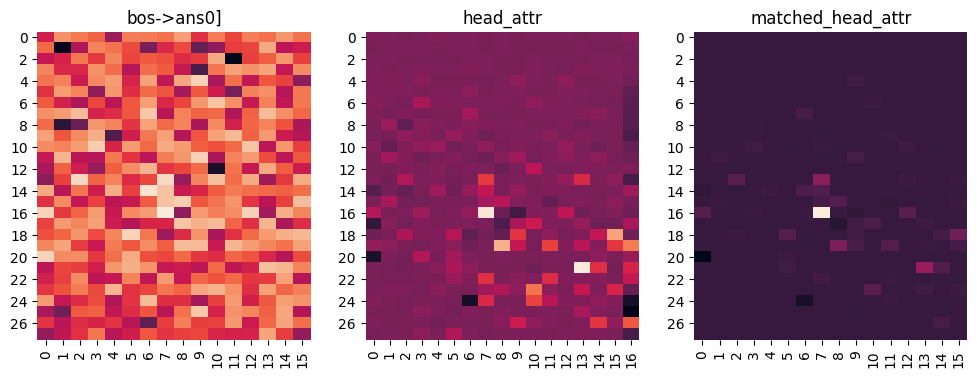

(array([16, 14, 13, 13, 16, 18, 20,  4, 16, 11]),
 array([ 7,  6,  7,  2,  0,  5,  0,  9, 12,  9]),
 array([-0.8131221, -1.1140809, -1.3658707, -1.4227219, -1.550431 ,
       -1.5607324, -1.5697958, -1.5797439, -1.6435707, -1.6617503],
      dtype=float32))
(array([21, 16, 19, 18, 19, 23, 26, 24, 19, 13]),
 array([13,  7,  8, 15, 16, 10, 16, 10, 11,  7]),
 array([0.75155824, 0.7355008 , 0.5843423 , 0.5458761 , 0.4470967 ,
       0.42752582, 0.36593425, 0.31886303, 0.31549644, 0.30079457],
      dtype=float32))
(array([16, 21, 13, 19, 18, 23, 13, 16, 18, 16]),
 array([ 7, 13,  7,  8, 15, 10,  2, 12,  5,  0]),
 array([0.32617354, 0.09005119, 0.07675026, 0.06296989, 0.05223418,
       0.0355777 , 0.03315381, 0.03299941, 0.02903952, 0.02850244],
      dtype=float32))
[0] top[0] 16-7 attn_labels


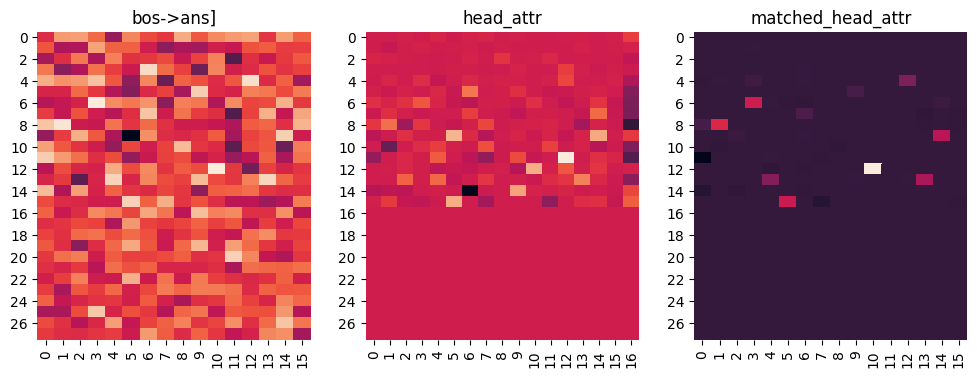

(array([ 6, 12,  8,  4,  3, 13, 13, 15, 20,  9]),
 array([ 3, 10,  1, 12,  6, 13,  4,  5, 11, 14]),
 array([-2.0432267, -2.0723977, -2.266554 , -2.484486 , -2.6210263,
       -2.802127 , -2.9011645, -2.9306583, -2.9438295, -3.0412364],
      dtype=float32))
(array([11,  9, 12, 15,  9, 14, 13,  5,  8,  7]),
 array([12,  5, 10,  5, 14,  9, 13,  6,  1, 14]),
 array([0.7693001 , 0.5414798 , 0.51048654, 0.5035944 , 0.49987787,
       0.47721595, 0.35205713, 0.31638402, 0.29327953, 0.2701404 ],
      dtype=float32))
(array([12,  8,  6, 15,  9, 13, 13,  4,  7,  8]),
 array([10,  1,  3,  5, 14, 13,  4, 12,  6,  0]),
 array([0.06426188, 0.03040393, 0.02753537, 0.02687275, 0.02388206,
       0.02136313, 0.01450619, 0.0135276 , 0.00445843, 0.00352038],
      dtype=float32))
[1] top[0, 1] 12-10,8-1


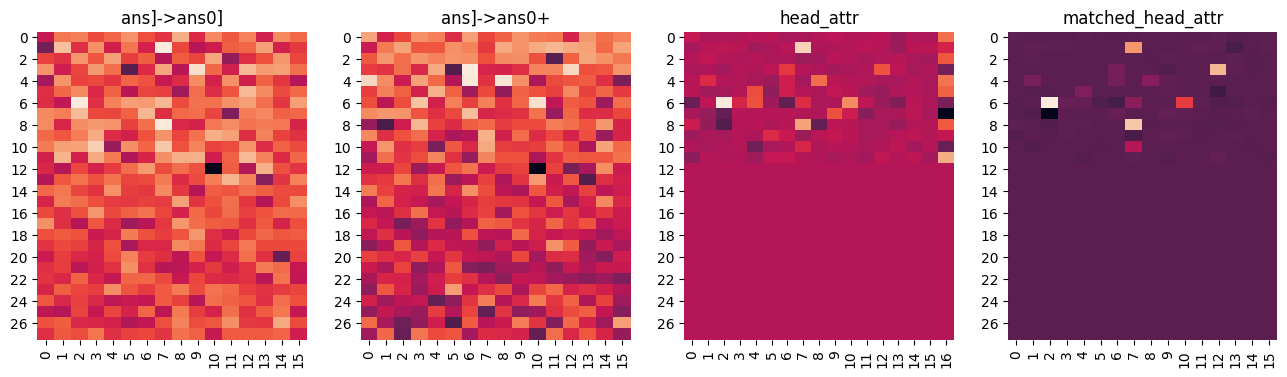

(array([ 1,  6,  8,  3, 10, 10,  1,  7, 11,  5]),
 array([ 7,  2,  7,  9,  3,  7,  1,  2, 12, 12]),
 array([-0.10544297, -0.12014531, -0.1850719 , -0.5820397 , -1.184849  ,
       -1.4089417 , -1.7394853 , -1.8467633 , -1.9650996 , -1.9652803 ],
      dtype=float32))
(array([3, 4, 4, 6, 3, 4, 6, 7, 8, 1]),
 array([ 6,  6,  8, 10, 12,  0,  3,  6,  3, 11]),
 array([-0.21864541, -0.33301038, -0.4052481 , -0.5228414 , -0.7983227 ,
       -0.841054  , -1.346777  , -1.532387  , -1.7368424 , -1.7376413 ],
      dtype=float32))
(array([ 6,  1, 11,  8,  6,  4,  0,  4,  5,  8]),
 array([ 2,  7, 16,  7, 10, 16, 16,  8, 16, 16]),
 array([0.6271033 , 0.5563282 , 0.44647613, 0.4140543 , 0.35706034,
       0.29953283, 0.2877331 , 0.2827124 , 0.25118467, 0.24094087],
      dtype=float32))
(array([ 6,  8,  3,  1,  6, 10,  6,  4,  5,  4]),
 array([ 2,  7, 12,  7, 10,  7,  7,  8,  4,  1]),
 array([0.06739227, 0.05882639, 0.05555389, 0.04800212, 0.03118702,
       0.01840849, 0.00964398, 0.00909121, 0.007

In [417]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [385]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3,4])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 12-10,8-1┐
                                                                     └*[2] top[0, 1, 2, 3, 4] 6-2,8-7,3-12,1-7,6-10...


Christopher is irresponsible. Morgan is poor. So Morgan's not rich
August is hot. Ruby is small. So August's not cold
Ryan is unconscious. Robin is quiet. So Ryan's not conscious
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └[2] top[0] 7-9
 [-1] root labels┤
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...
[-1] root labels


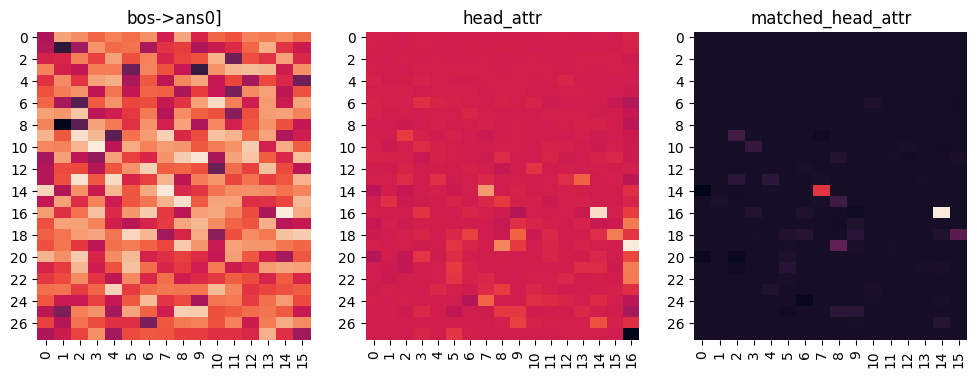

(array([10, 16, 14, 11, 13, 15,  9, 13,  6, 18]),
 array([ 3, 14,  7,  9,  2,  8,  2,  4, 10,  5]),
 array([-1.0614762, -1.0834801, -1.1901063, -1.2660172, -1.3361347,
       -1.4233662, -1.436903 , -1.563286 , -1.590735 , -1.712683 ],
      dtype=float32))
(array([19, 16, 14, 19, 21, 18, 22, 17, 24, 18]),
 array([16, 14,  7,  8, 16, 15, 16, 16,  7,  9]),
 array([0.9225615 , 0.85220003, 0.5222215 , 0.44205382, 0.4086256 ,
       0.3954818 , 0.39397603, 0.38965353, 0.2994766 , 0.2949795 ],
      dtype=float32))
(array([16, 14, 19, 18,  9, 15, 10, 13, 25, 13]),
 array([14,  7,  8, 15,  2,  8,  3,  4,  8,  2]),
 array([0.2883979 , 0.15885401, 0.05732693, 0.05438753, 0.03474189,
       0.03422713, 0.02544804, 0.01949975, 0.01885692, 0.01821908],
      dtype=float32))
[0] top[0] 16-14 attn_labels


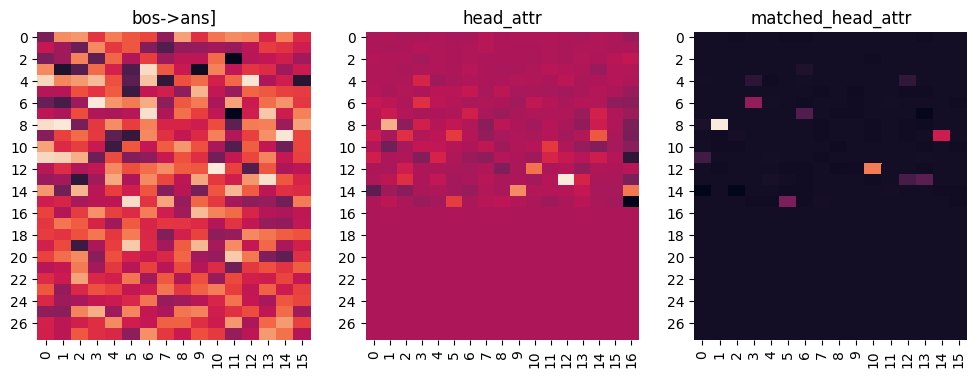

(array([12,  6,  8,  4,  9, 13,  7,  8, 15,  3]),
 array([10,  3,  1, 12, 14, 13,  6,  0,  5,  6]),
 array([-2.002304 , -2.0551844, -2.0881045, -2.1751802, -2.1937742,
       -2.2998815, -2.337555 , -2.3848898, -2.4324052, -2.4835942],
      dtype=float32))
(array([13,  8, 14, 14, 12,  9, 15,  9, 10,  9]),
 array([12,  1,  9, 16, 10, 14,  5,  5, 11,  2]),
 array([0.79002386, 0.57762516, 0.45729977, 0.40136495, 0.37706846,
       0.31034058, 0.22494863, 0.21906604, 0.21601075, 0.19114912],
      dtype=float32))
(array([ 8, 12,  9,  6, 15, 13,  7, 13, 11,  4]),
 array([ 1, 10, 14,  3,  5, 13,  6, 12,  0, 12]),
 array([0.07158036, 0.05091322, 0.03460147, 0.02411781, 0.01975619,
       0.01408757, 0.01208335, 0.01073118, 0.00910435, 0.00616032],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


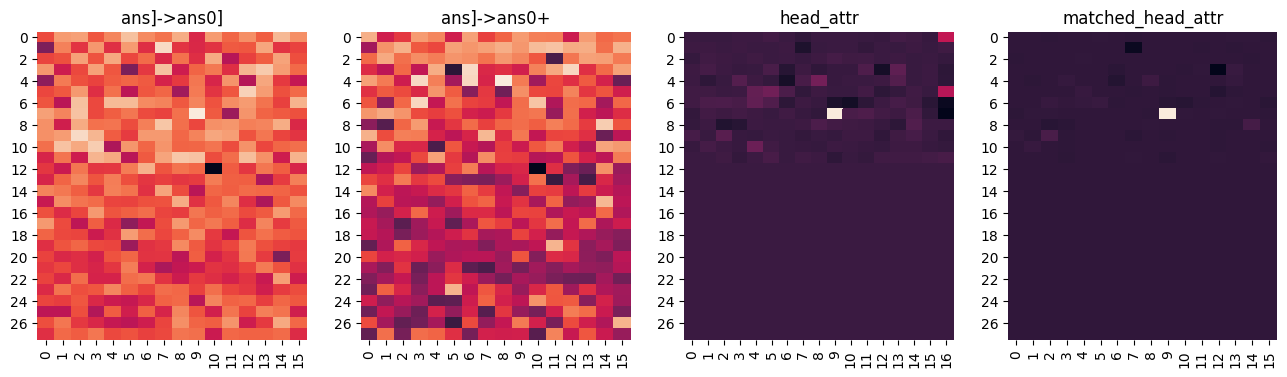

(array([ 7,  1,  9,  5, 10,  3, 11,  8, 10,  7]),
 array([ 9,  7,  2, 12,  3, 13,  8,  7,  1,  2]),
 array([-0.48755345, -1.1073177 , -1.1164478 , -1.4089204 , -1.5828502 ,
       -1.7160457 , -1.7882301 , -1.8945122 , -1.9793423 , -1.9846205 ],
      dtype=float32))
(array([4, 3, 4, 6, 3, 4, 8, 6, 1, 1]),
 array([ 8,  6,  3,  3, 12,  6, 14, 10, 11, 10]),
 array([-0.82827485, -1.2663082 , -1.30692   , -1.324405  , -1.331464  ,
       -1.3490177 , -1.6154763 , -1.8305976 , -1.8823582 , -2.0159717 ],
      dtype=float32))
(array([ 7,  0,  5,  4,  5, 10,  5,  6,  3,  9]),
 array([ 9, 16, 16,  8,  5,  4,  4,  4, 13,  2]),
 array([1.396103  , 0.53617567, 0.48715025, 0.23154691, 0.21675475,
       0.199749  , 0.16530544, 0.16239291, 0.14587918, 0.12329111],
      dtype=float32))
(array([ 7,  9,  8,  4,  3,  6,  6,  5, 10,  4]),
 array([ 9,  2, 14,  8, 13,  5,  2,  4,  1, 13]),
 array([0.16704938, 0.01277332, 0.01098615, 0.00688249, 0.00492415,
       0.00444001, 0.00388898, 0.00366408, 0.003

In [421]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [412]:
print(key); node = add_node_to_result(result, topi=[0,])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └[2] top[0] 7-9
 [-1] root labels┤
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


London has a burger. London's food
Jamie has a pizza. Jamie's food
Joy has a pistol. Joy's weapon
 [-1] root labels┐
                 └[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels┐
                                                             └[1] top[0, 1] 8-1,12-10┐
                                                                                     └*[2] top[0, 1] 5-12,7-2...
[-1] root labels


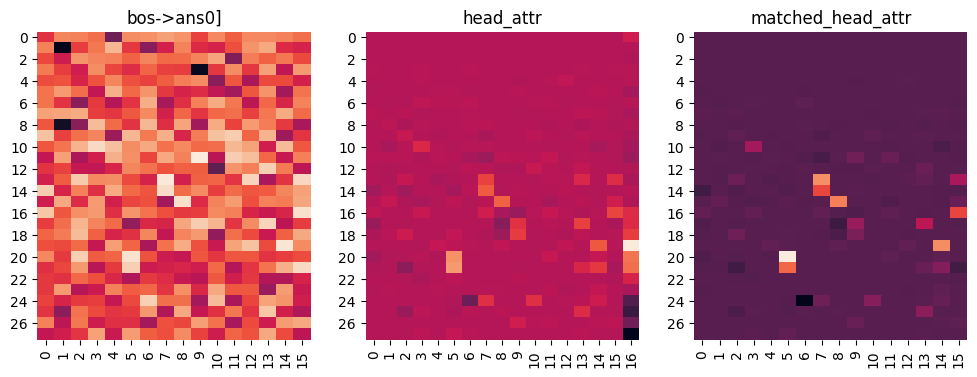

(array([11, 13, 19, 20, 16, 15, 14, 10, 21, 13]),
 array([ 9,  7, 14,  5, 15,  8,  7,  3, 15, 15]),
 array([-0.4349876, -0.5271155, -0.6725031, -0.7400898, -0.7721441,
       -0.7932828, -0.9576964, -1.026036 , -1.0345848, -1.0595406],
      dtype=float32))
(array([19, 21, 20, 20, 21, 15, 14, 19, 16, 13]),
 array([16,  5,  5, 16, 16,  8,  7, 14, 15,  7]),
 array([1.651996  , 1.029985  , 0.96665406, 0.78627765, 0.7544155 ,
       0.67617255, 0.62602866, 0.6084214 , 0.5003369 , 0.4799834 ],
      dtype=float32))
(array([20, 13, 19, 15, 21, 14, 16, 17, 13, 10]),
 array([ 5,  7, 14,  8,  5,  7, 15, 13, 15,  3]),
 array([1.3061308 , 0.9105848 , 0.9047116 , 0.85237265, 0.7648076 ,
       0.65368176, 0.64798385, 0.40298358, 0.3184108 , 0.2960562 ],
      dtype=float32))
[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels


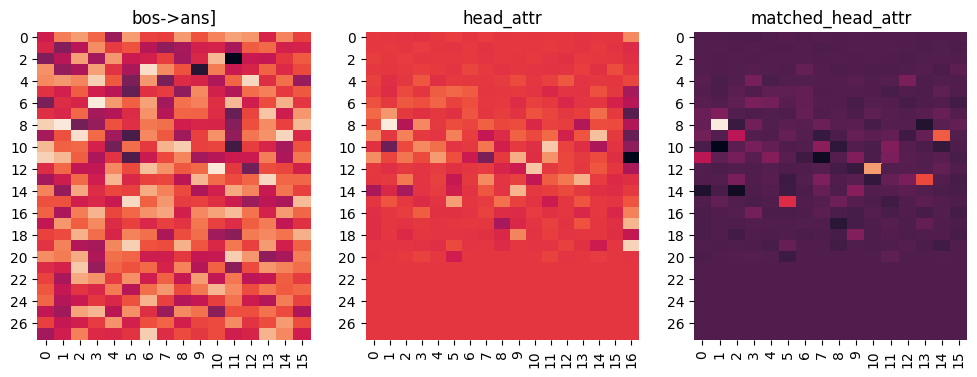

(array([ 6,  8, 12,  9,  3, 15, 13,  4,  9, 11]),
 array([ 3,  1, 10,  2,  6,  5, 13, 12, 14,  0]),
 array([-2.0047698, -2.0751946, -2.0947797, -2.3899155, -2.4032595,
       -2.5390391, -2.571194 , -2.5823462, -2.6415858, -2.7976642],
      dtype=float32))
(array([ 8, 19, 10, 12,  9, 14, 17, 13, 11, 15]),
 array([ 1, 16, 11, 10, 14,  9, 16, 13,  9,  5]),
 array([0.9747391 , 0.82241213, 0.7610413 , 0.7319919 , 0.7036818 ,
       0.64335304, 0.6406404 , 0.6252868 , 0.5944871 , 0.51662207],
      dtype=float32))
(array([ 8, 12,  9, 13, 15, 11,  9, 10, 14, 11]),
 array([ 1, 10, 14, 13,  5,  0,  2,  7,  9,  4]),
 array([0.46970972, 0.34943622, 0.26638612, 0.24318929, 0.20347148,
       0.15300176, 0.15045455, 0.08416142, 0.07752506, 0.07396084],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


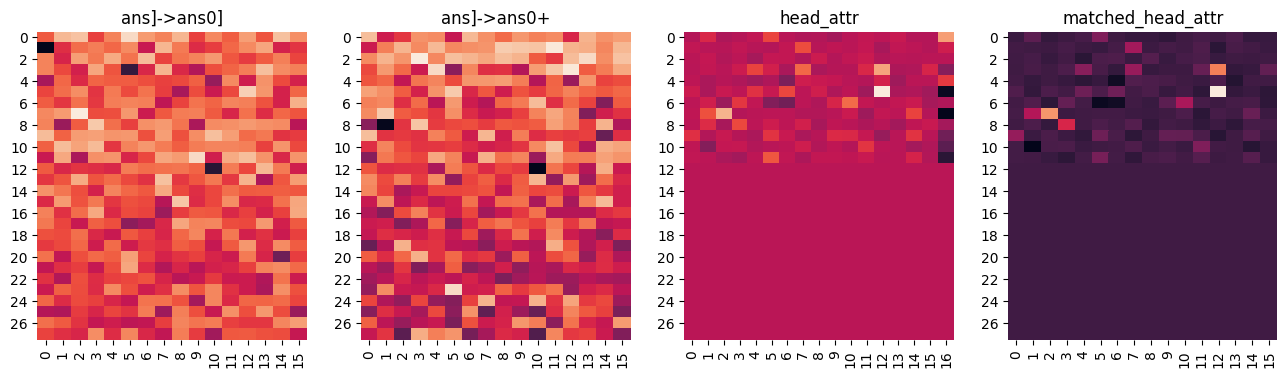

(array([ 7,  0, 11,  5,  8, 15,  0, 13,  0,  9]),
 array([ 2,  5,  9, 12,  3,  8,  2,  7, 14, 10]),
 array([-0.3700801 , -0.91300535, -0.93113196, -1.226944  , -1.4634625 ,
       -1.5716724 , -1.6603969 , -1.7137558 , -1.7353265 , -1.74996   ],
      dtype=float32))
(array([ 2,  1,  3, 23,  3,  2,  1,  7,  5,  1]),
 array([ 3, 11, 12,  5,  4, 13,  8,  1,  5,  9]),
 array([-0.34843445, -0.4046321 , -0.4277269 , -0.78305674, -0.78762954,
       -0.81143206, -1.1962155 , -1.2218091 , -1.2308171 , -1.3081578 ],
      dtype=float32))
(array([ 5,  7,  3,  0,  6,  3, 11,  7,  1,  8]),
 array([12,  2, 12, 16, 10,  7,  5,  1,  7,  3]),
 array([1.2855846 , 0.9356196 , 0.85248685, 0.8200028 , 0.5468836 ,
       0.5278702 , 0.44569322, 0.41489646, 0.39586794, 0.38460428],
      dtype=float32))
(array([5, 7, 3, 8, 7, 6, 1, 3, 9, 3]),
 array([12,  2, 12,  3,  1, 10,  7,  7,  0,  4]),
 array([0.61430156, 0.4553765 , 0.41683966, 0.2716534 , 0.20253491,
       0.18628792, 0.17362618, 0.15562657, 0.150

In [139]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [142]:
print(key); node = add_node_to_result(result, topi=[1, 2])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
 [-1] root labels┐
                 └[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels┐
                                                             └[1] top[0, 1] 8-1,12-10┐
                                                                                     └*[2] top[1, 2] 7-2,3-12...


Bo has a bear. Carl has a pineapple. Bo's bear
Christopher has wine. Morgan has spaghetti. Morgan's spaghetti
August has black. Ruby has a lime. August's black
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └*[1] top[0] 12-10
[-1] root labels


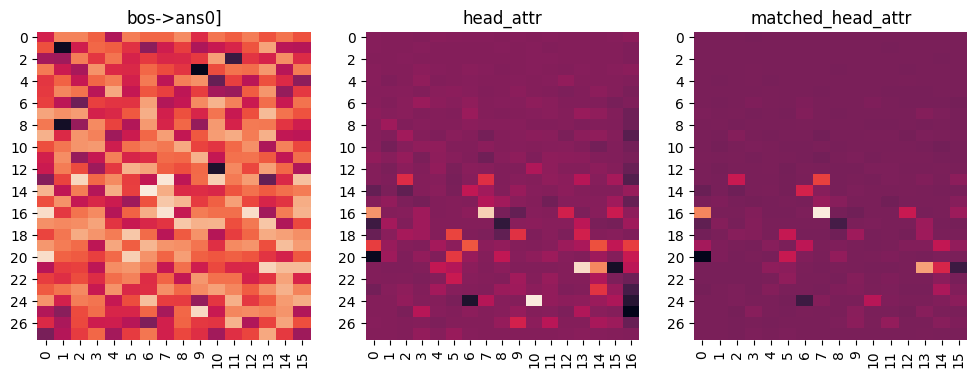

(array([14, 13, 16, 16, 20, 16, 25, 13, 21, 20]),
 array([ 6,  7,  7, 12,  0,  0,  9,  2, 13,  5]),
 array([-0.76847124, -0.91620743, -1.0253844 , -1.1890159 , -1.2004476 ,
       -1.2044504 , -1.3372848 , -1.4165361 , -1.4887413 , -1.6328306 ],
      dtype=float32))
(array([24, 21, 16, 16, 21, 19, 19, 18, 19, 19]),
 array([10, 13,  7,  0, 14,  6, 14,  5,  0, 16]),
 array([0.961745  , 0.89983845, 0.8550615 , 0.6408211 , 0.60438335,
       0.45135754, 0.433631  , 0.3990986 , 0.37840158, 0.37788907],
      dtype=float32))
(array([16, 21, 16, 13, 21, 14, 16, 13, 20, 18]),
 array([ 7, 13,  0,  7, 14,  6, 12,  2,  5,  5]),
 array([0.83389354, 0.604429  , 0.5320444 , 0.35702586, 0.27561784,
       0.26199418, 0.2219705 , 0.22174115, 0.22023506, 0.21290773],
      dtype=float32))
[0] top[0] 16-7 attn_labels


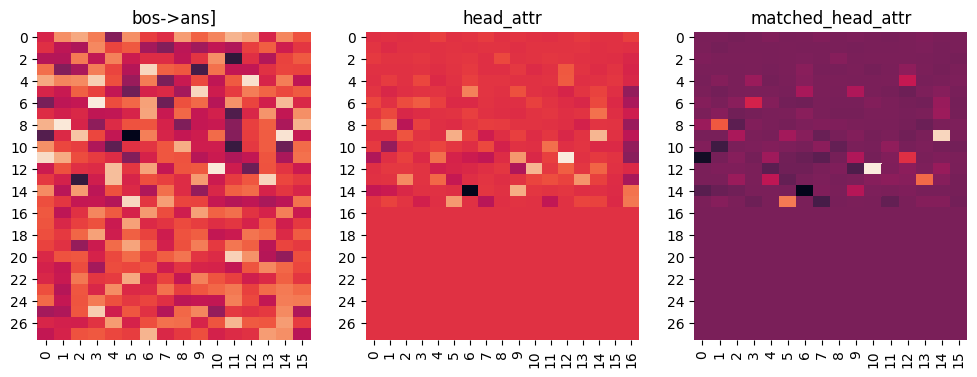

(array([ 6, 12,  8,  9,  4, 11, 15,  5,  3, 13]),
 array([ 3, 10,  1, 14, 12,  0,  5,  9,  6, 13]),
 array([-2.123184 , -2.2026026, -2.2260034, -2.3891857, -2.4952831,
       -2.658862 , -2.81563  , -2.8529582, -2.8708003, -2.9066348],
      dtype=float32))
(array([11, 12,  9,  9, 14, 15, 11, 13, 13,  5]),
 array([12, 10, 14,  5,  9,  5,  9, 13,  2,  6]),
 array([0.94266975, 0.6408508 , 0.6386491 , 0.59435934, 0.59105384,
       0.4876091 , 0.47970265, 0.4581871 , 0.40486157, 0.3693422 ],
      dtype=float32))
(array([12,  9, 15, 13,  8, 11,  6,  4, 13, 14]),
 array([10, 14,  5, 13,  1, 12,  3, 12,  4,  9]),
 array([0.2909516 , 0.26730826, 0.17317939, 0.1576349 , 0.14327697,
       0.10633796, 0.09084104, 0.07399539, 0.0668023 , 0.0574955 ],
      dtype=float32))
[1] top[0] 12-10


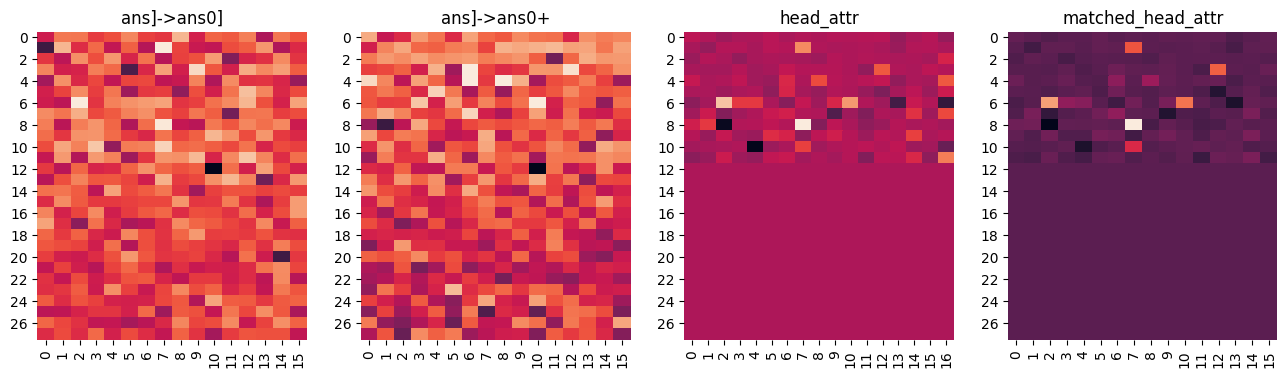

(array([ 1,  6,  8,  3, 10, 10, 11,  5, 11,  6]),
 array([ 7,  2,  7,  9,  7,  3, 12, 12,  9, 12]),
 array([-0.12368098, -0.13077638, -0.26115006, -0.78683645, -0.9868426 ,
       -1.4075432 , -1.4351188 , -1.6455195 , -1.8874338 , -1.9593313 ],
      dtype=float32))
(array([ 4,  6,  4,  3,  3,  4,  7,  5,  6, 23]),
 array([ 6, 10,  8,  6, 12,  0,  6,  4,  3,  5]),
 array([-0.31093156, -0.31979668, -0.3385723 , -0.34999603, -0.6376282 ,
       -0.84697556, -0.95705634, -1.0610068 , -1.3670614 , -1.6841705 ],
      dtype=float32))
(array([ 8,  6,  6,  1, 11,  4,  3,  4,  7, 10]),
 array([ 7,  2, 10,  7, 16, 16, 12,  8, 16,  7]),
 array([0.63601977, 0.5212428 , 0.40400568, 0.3651063 , 0.33129334,
       0.24795131, 0.24558514, 0.21417469, 0.21101579, 0.1912424 ],
      dtype=float32))
(array([ 8,  6,  6,  3,  1, 10,  4,  6,  7,  4]),
 array([ 7,  2, 10, 12,  7,  7,  8,  3,  6,  6]),
 array([0.29616523, 0.22044423, 0.18283053, 0.16659595, 0.15712117,
       0.11983133, 0.05907141, 0.04806

In [150]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [151]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0] 12-10┐
                                                              └*[2] top[0, 1, 2, 3, 4] 8-7,6-2,6-10,3-12,1-7...


In [177]:
def plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0]):
    for l, h in zip(*np.array(topk_md(get_matched_head_attr(node.data), 10)[:2])[:, topi]):
        print(l, h)
        for data_tuple in data_tuples:
            plot_attn_attr(data_tuple, model, tokenizer, node, l, h, k_shot=k_shot,
                attn_patterns=attn_patterns_by_step[node.data.step])

12 10
tensor([-3.6134, -2.5552, -2.4820, -2.8550])


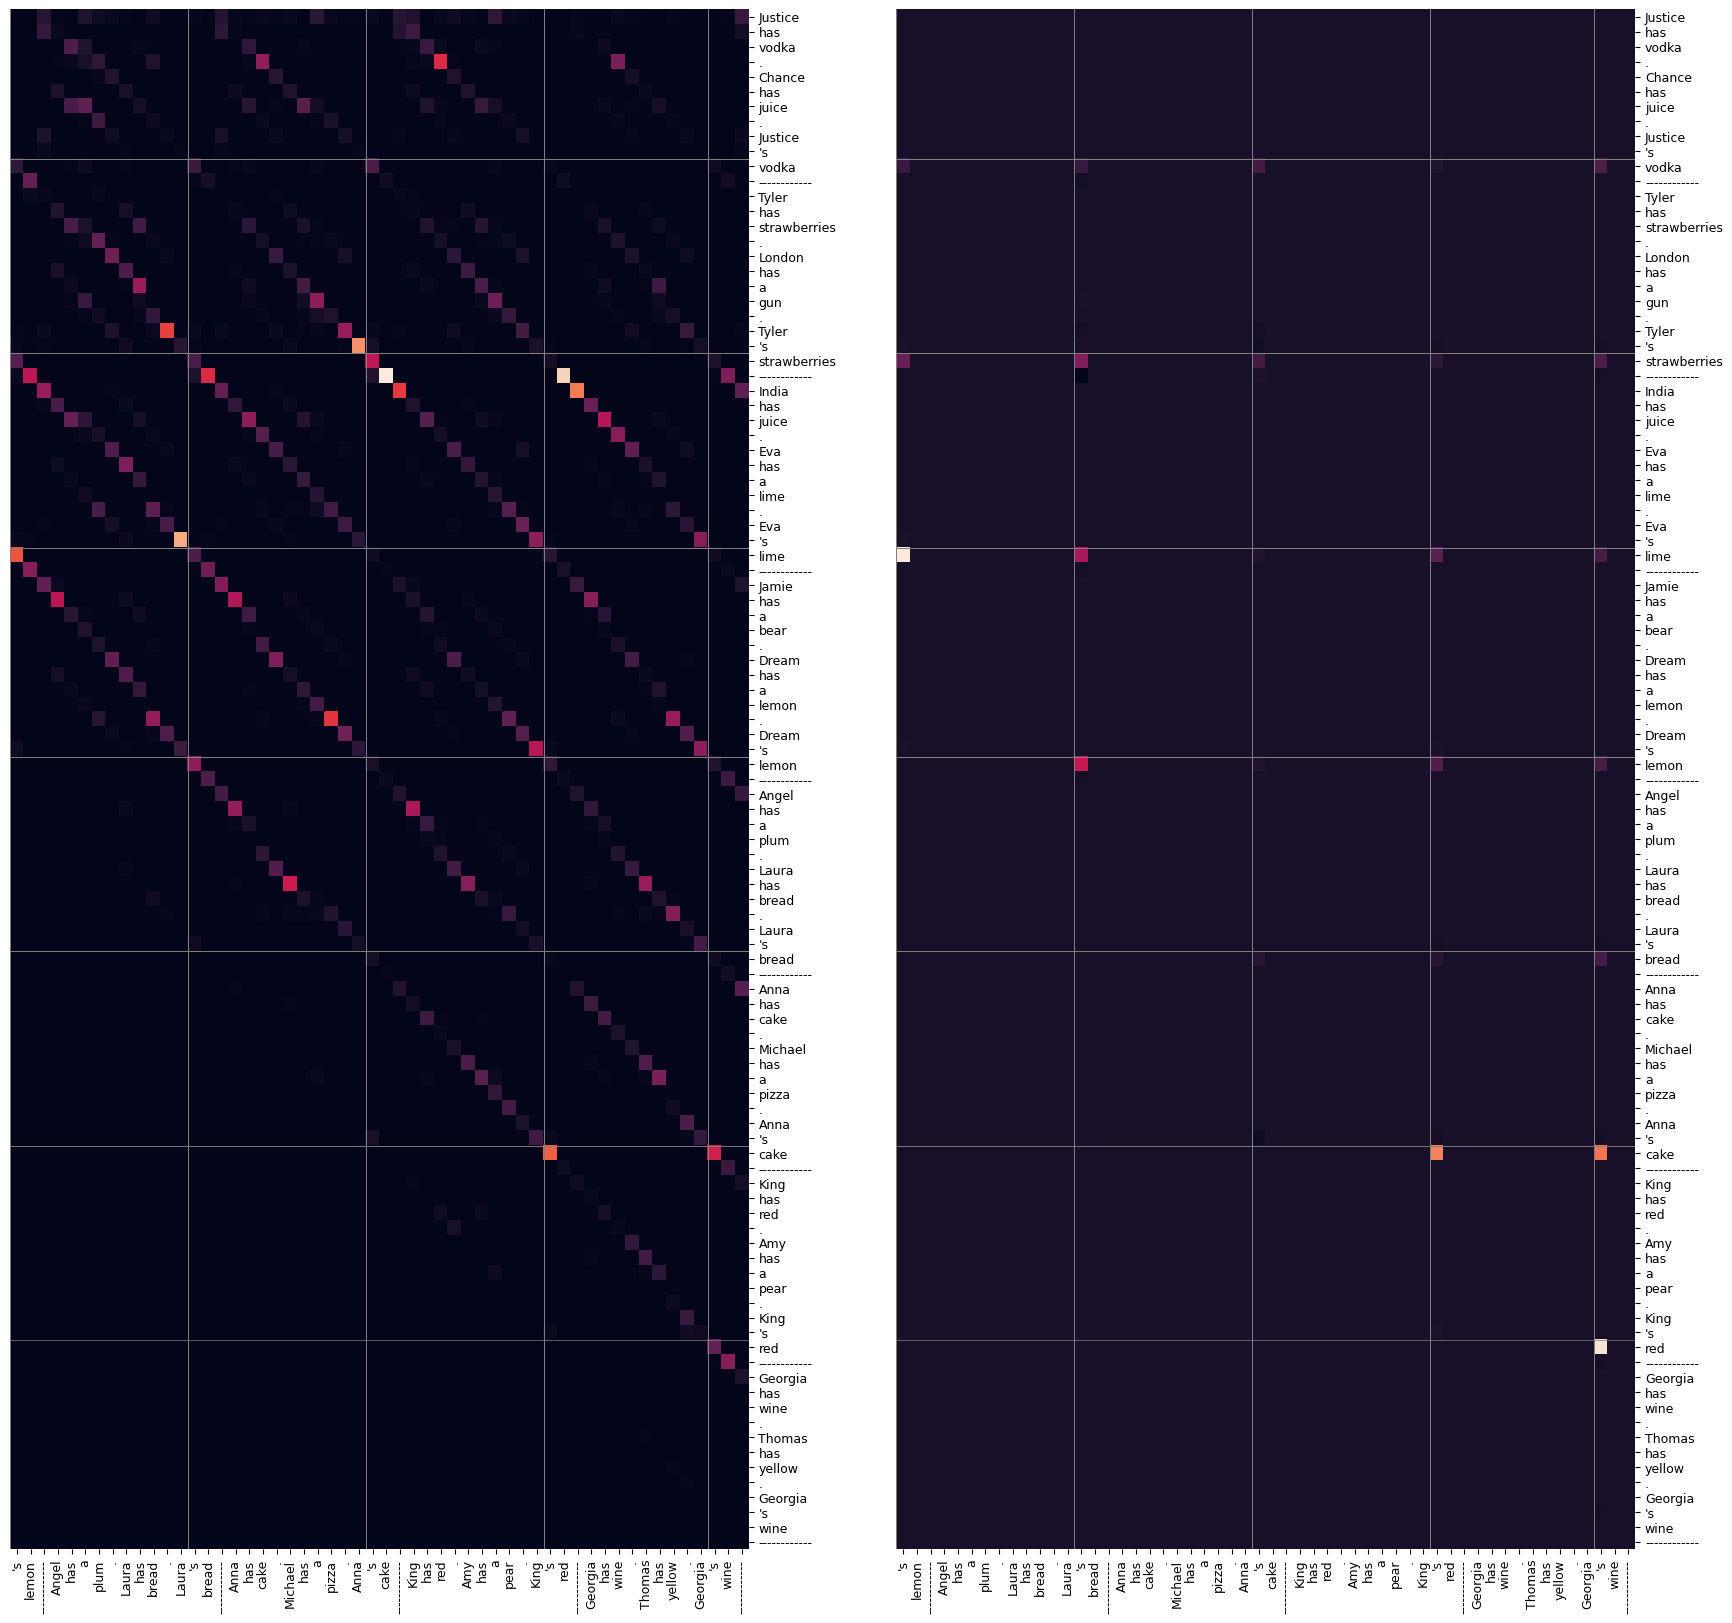

In [179]:
plot_attn_attrs(data_tuples[:1], model, tokenizer, node.parent.parent, topi=[0])  # step 1 intermediary head 12-10

16 7
tensor([-10.5445,  -2.6744,  -1.1017,  -1.0407])
 Ġvodka 0.222 {'ĠJuice': 0.294, 'Ġvodka': 0.222, 'Ġjuice': 0.137, 'j': 0.105} 	 Justice has vodka. Chance has juice. Justice's vodka
 Ġstrawberries 0.0 {'Ġvodka': 0.808, 'Ġjuice': 0.184, 'ĠJuice': 0.006, 'Ġjuices': 0.001} 	 Tyler has strawberries. London has a gun. Tyler's strawberries
 Ġlime 0.253 {'Ġa': 0.7, 'Ġlime': 0.253, 'ĠLime': 0.015, 'Ġgun': 0.012} 	 India has juice. Eva has a lime. Eva's lime
 Ġlemon 0.065 {'Ġlime': 0.9, 'Ġlemon': 0.065, 'ĠLime': 0.03, 'Ġcitrus': 0.002} 	 Jamie has a bear. Dream has a lemon. Dream's lemon
*Ġbread 0.717 {'Ġbread': 0.717, 'ĠBread': 0.28, 'bread': 0.003, 'Ġfood': 0.0} 	 Angel has a plum. Laura has bread. Laura's bread
*Ġcake 0.309 {'Ġcake': 0.309, 'cake': 0.246, 'ĠMichael': 0.179, 'Michael': 0.126} 	 Anna has cake. Michael has a pizza. Anna's cake
*Ġred 0.966 {'Ġred': 0.966, 'ĠRED': 0.019, 'Red': 0.005, 'ĠRed': 0.005} 	 King has red. Amy has a pear. King's red
 Ġwine 0.396 {'wine': 0.575, 'Ġwi

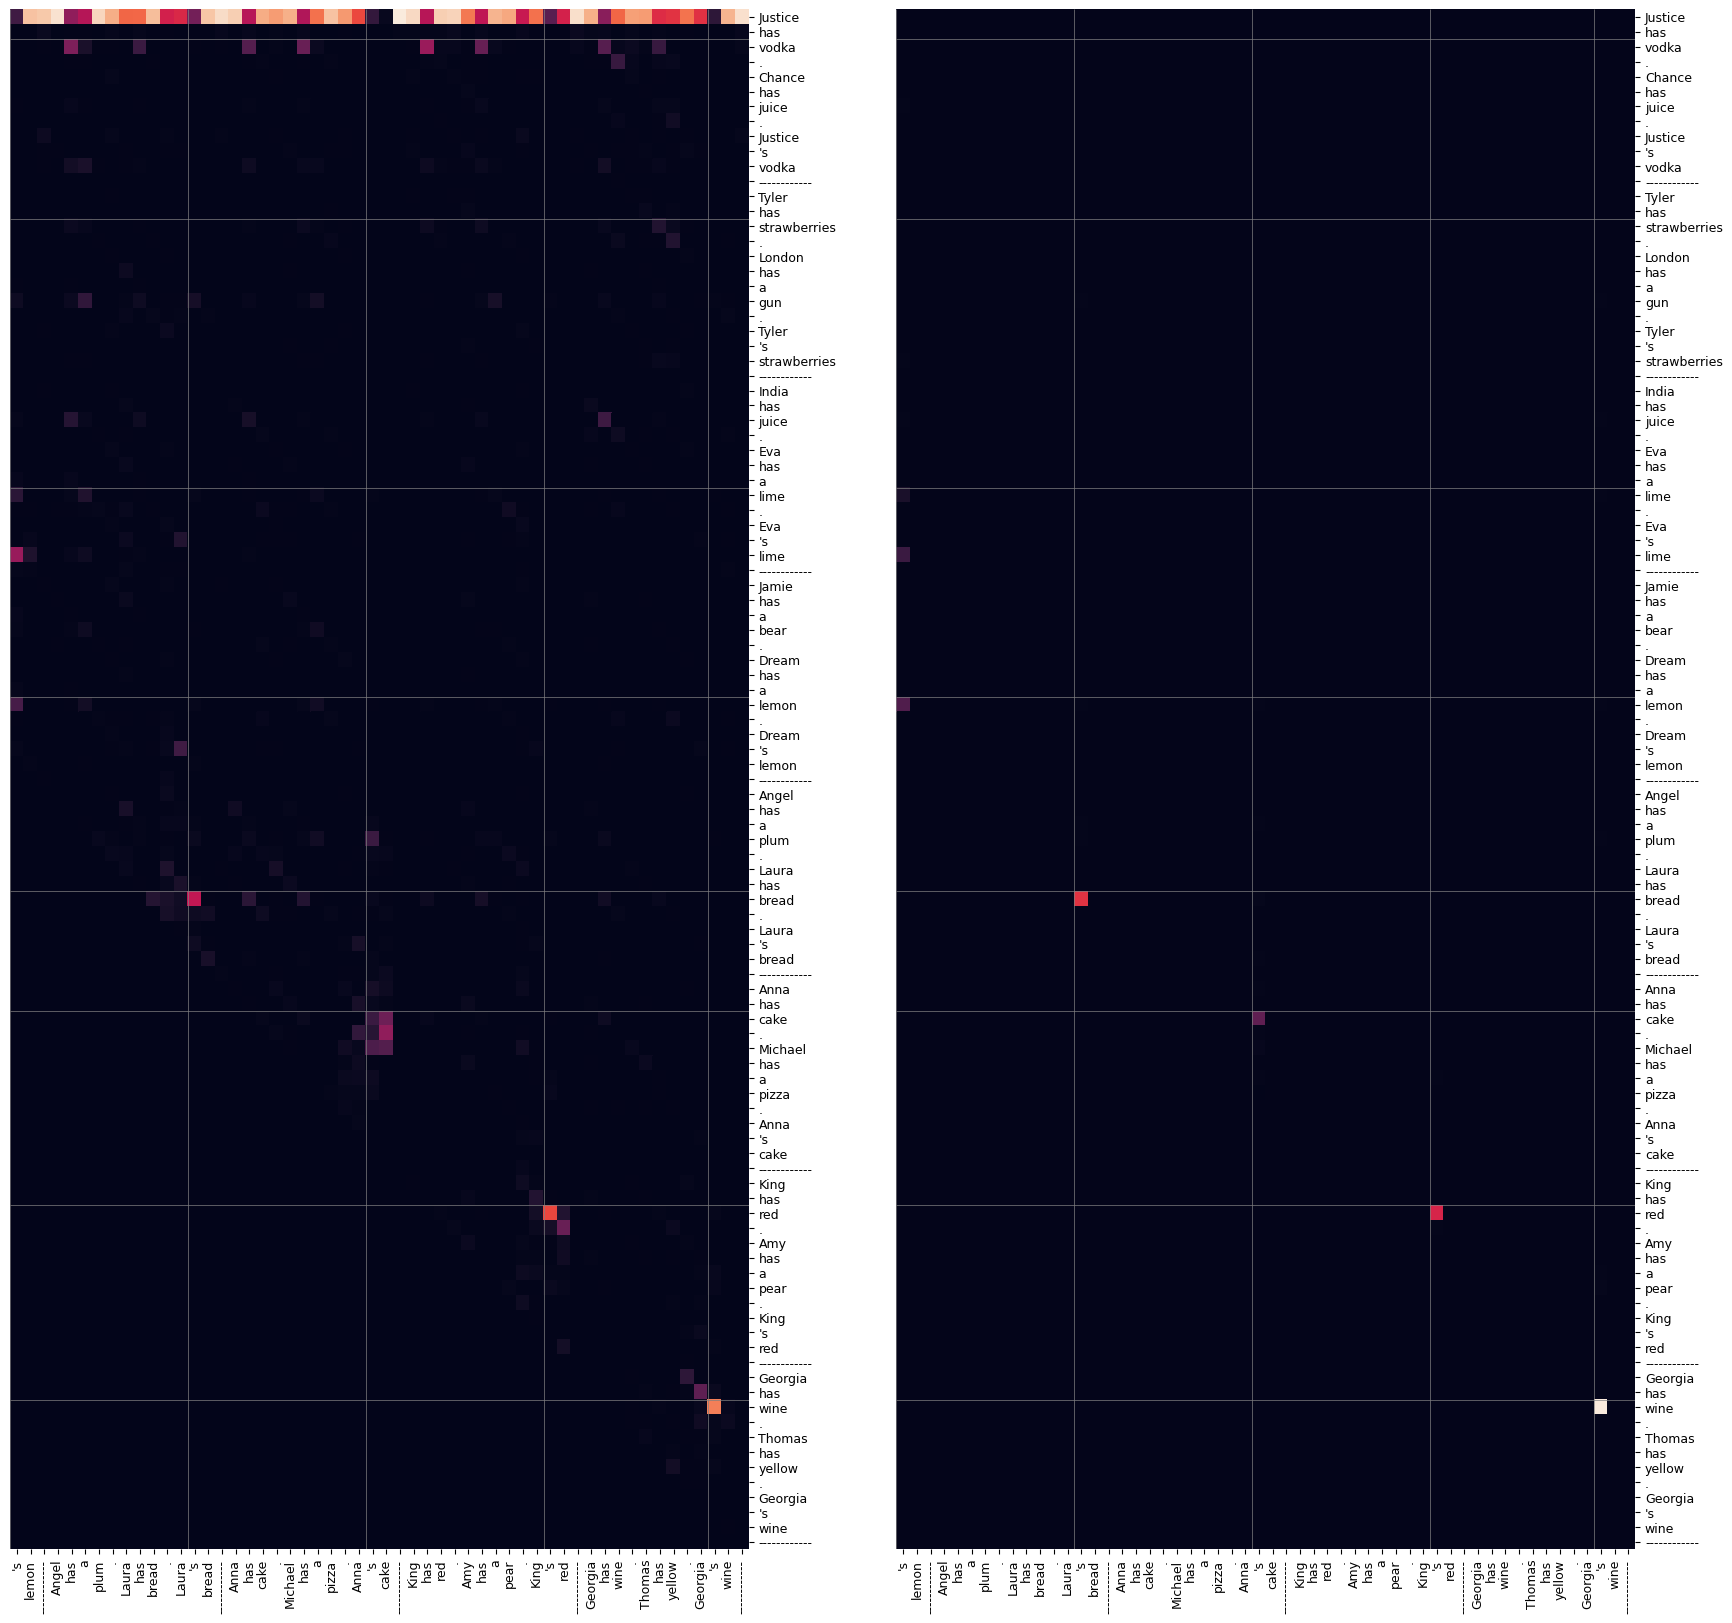

In [180]:
plot_attn_attrs(data_tuples[:1], model, tokenizer, node.parent.parent.parent, topi=[0])  # step 0 predicgting head 16-7

In [255]:
for head, prod in iweightprod(model, [(7, 2), (12, 10), [(21, 5), (20, 5), (15, 8)]], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=True):
    print(head, plot_eigv(prod, plot=False))

(21, 5) (0.7073339819908142, 0.8719903230667114)
(20, 5) (-0.3651812970638275, 0.8842065334320068)
(15, 8) (0.8265929222106934, 0.9204588532447815)


In [254]:
for head, prod in iweightprod(model, [(8, 7), (12, 10), [(21, 5), (20, 5), (15, 8)]], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=True):
    print(head, plot_eigv(prod, plot=False))

(21, 5) (0.9540624618530273, 0.9784843325614929)
(20, 5) (0.9560495018959045, 0.9772301912307739)
(15, 8) (0.9647945165634155, 0.9794634580612183)


Alan has a blackberry. Jacob has an elephant. Alan's fruit
Morgan has a gun. Davis has a hamburger. Morgan's weapon
Austin has a deer. Thomas has meat. Thomas's food
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └*[1] top[0, 1] 8-1,12-10
 [-1] root labels┤
                 ├[0] 11-9 attn_labels┐
                 │                    └[1] top[0] 8-1┐
                 │                                   └[2] top[0, 1] 3-12,7-2
                 └[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                                                                    └[1] top[0, 1] 8-1,12-10┐
                                                                                            └[2] top[0, 1, 3] 5-12,3-12,7-2
[-1] root labels


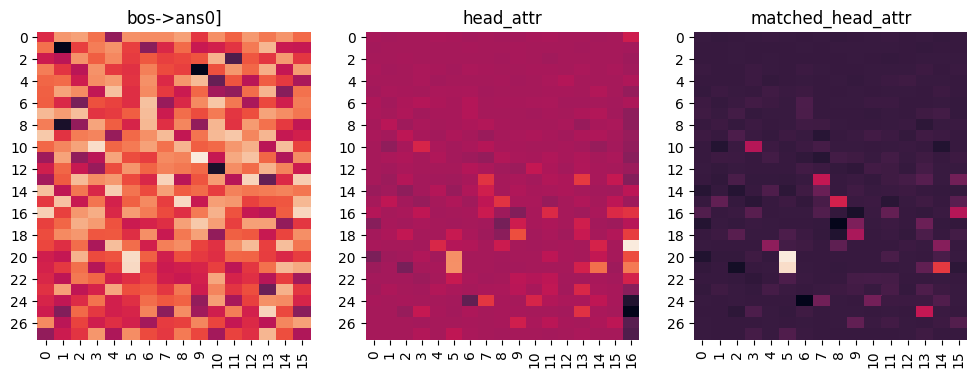

(array([11, 10, 20, 15, 21, 16, 13, 25, 13, 16]),
 array([ 9,  3,  5,  8,  5, 15, 12, 13,  7,  0]),
 array([-1.2674766, -1.6482041, -1.7172701, -1.7815722, -1.8076308,
       -1.8884598, -1.933879 , -1.9424105, -1.9547232, -2.0370746],
      dtype=float32))
(array([19, 21, 20, 21, 21, 18, 20, 18, 13, 24]),
 array([16,  5,  5, 16, 14,  9, 16, 16, 13,  7]),
 array([1.1065601 , 0.6738789 , 0.6702883 , 0.58036315, 0.5375647 ,
       0.41118476, 0.4067158 , 0.34230423, 0.32954222, 0.3187341 ],
      dtype=float32))
(array([20, 21, 21, 15, 13, 25, 10, 16, 18, 19]),
 array([ 5,  5, 14,  8,  7, 13,  3, 15,  9,  4]),
 array([0.390322  , 0.37279677, 0.20106155, 0.17056097, 0.1526186 ,
       0.15236934, 0.13750218, 0.13642497, 0.12428343, 0.09571555],
      dtype=float32))
[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels


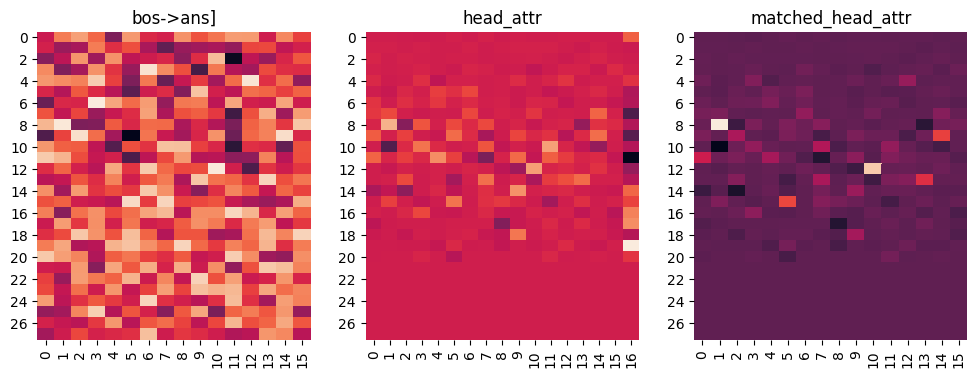

(array([ 6, 12,  8,  4,  3,  9,  9, 15, 16, 24]),
 array([ 3, 10,  1, 12,  6,  2, 14,  5, 11,  6]),
 array([-2.1202505, -2.1813905, -2.2281203, -2.3211892, -2.4319775,
       -2.5134633, -2.528109 , -2.6391044, -2.7577412, -2.7972775],
      dtype=float32))
(array([19,  8, 10, 12, 14, 17, 11, 16, 18, 15]),
 array([16,  1, 11, 10,  9, 16,  4, 16,  9,  5]),
 array([0.6698531 , 0.45983768, 0.40328616, 0.39848846, 0.35765412,
       0.3453579 , 0.34316713, 0.30421916, 0.27467614, 0.26424968],
      dtype=float32))
(array([ 8, 12, 15,  9, 13, 11, 10,  9, 13, 11]),
 array([ 1, 10,  5, 14, 13,  0,  7,  2,  7,  4]),
 array([0.20637919, 0.18267635, 0.10012855, 0.09701532, 0.08507187,
       0.07069803, 0.05257459, 0.04743757, 0.04717468, 0.04504041],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


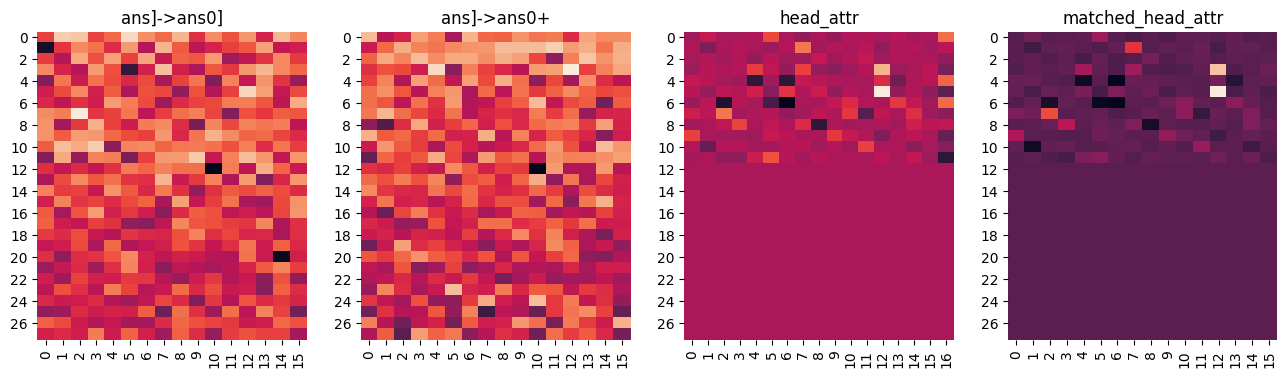

(array([ 7,  0,  5,  0, 10, 11,  0,  3, 10, 11]),
 array([ 2,  5, 12,  1,  3,  9,  2,  7,  1, 12]),
 array([-0.8029821, -1.3519015, -1.4143901, -1.6527418, -1.654027 ,
       -1.7690463, -1.8784103, -2.040913 , -2.0806189, -2.134634 ],
      dtype=float32))
(array([ 3,  3,  1,  2, 24, 23,  1,  2, 10,  1]),
 array([12,  4, 11, 13, 10,  5,  8,  3, 14,  9]),
 array([-0.7665804, -1.2390473, -1.479734 , -1.749217 , -1.8781241,
       -1.8878758, -1.9278226, -1.9299415, -1.9315186, -1.9402082],
      dtype=float32))
(array([ 5,  3,  7,  1,  0,  6,  4, 11,  0,  8]),
 array([12, 12,  2,  7, 16, 16, 16,  5,  5,  3]),
 array([0.86935115, 0.65089214, 0.43882847, 0.4347899 , 0.40814888,
       0.39541632, 0.37949353, 0.32751548, 0.29330683, 0.28055373],
      dtype=float32))
(array([ 5,  3,  7,  1,  8,  9,  3,  3,  0, 10]),
 array([12, 12,  2,  7,  3,  0,  4,  7,  5, 11]),
 array([0.38553452, 0.33191723, 0.19622234, 0.1699038 , 0.11536194,
       0.09843516, 0.08393712, 0.08256423, 0.07644407, 0.0

In [205]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [206]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                 │                                                  └[1] top[0, 1] 8-1,12-10┐
                 │                                                                          └[2] top[0, 1, 3] 5-12,3-12,7-2
 [-1] root labels┤
                 ├[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └[1] top[0, 1] 8-1,12-10┐
                 │                                                                   └*[2] top[0, 1, 2] 5-12,3-12,7-2...
                 └[0] 11-9 attn_labels┐
                                      └[1] top[0] 8-1┐
                                                     └[2] top[0, 1] 3-12,7-2


pmapped batch_predict ... done 0:00:00.000024
 Ġjacket 0.002 {'ĠJonathan': 0.043, 'ĠRaven': 0.036, 'Ċ': 0.014} 	 Kate beetle, Raven microwave, Jonathan jacket. Jonathan -> jacket
*Ġcherry 0.498 {'Ġcherry': 0.498, 'Ġbomb': 0.217, 'Ġspan': 0.125} 	 Walker cherry, Anne bomb, Eric spanner. Walker -> cherry
*Ġtaxi 0.701 {'Ġtaxi': 0.701, 'Ġtiger': 0.05, 'Ġjacket': 0.038} 	 Max taxi, Justice tiger, London jacket. Max -> taxi
 Ġcat 0.081 {'Ġant': 0.807, 'Ġcat': 0.081, 'ĠDream': 0.038} 	 Dream ant, John cat, James train. John -> cat
*Ġpap 0.988 {'Ġpap': 0.988, 'Ċ': 0.002, 'Ġcherry': 0.001} 	 Danny papaya, Paris helicopter, India cherry. Danny -> papaya
*Ġelephant 0.831 {'Ġelephant': 0.831, 'Ġsaw': 0.093, 'Ċ': 0.007} 	 Danny saw, Rose elephant, Matthew goose. Rose -> elephant
 Ġcat 0.038 {'Ġwater': 0.556, 'Ġgoose': 0.358, 'Ġcat': 0.038} 	 Virginia watermelon, Brian goose, Jennifer cat. Jennifer -> cat
*Ġlime 0.994 {'Ġlime': 0.994, 'ĠLime': 0.001, 'Ġlemon': 0.001} 	 Ocean lime, Robin sunflower, J

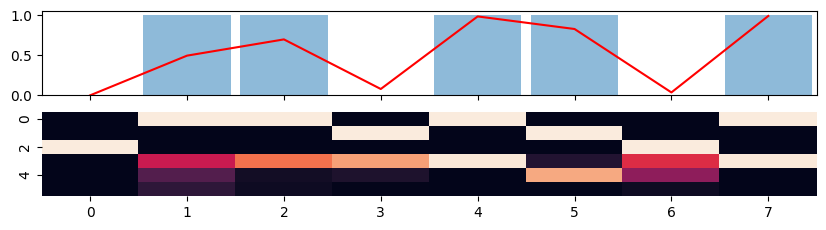

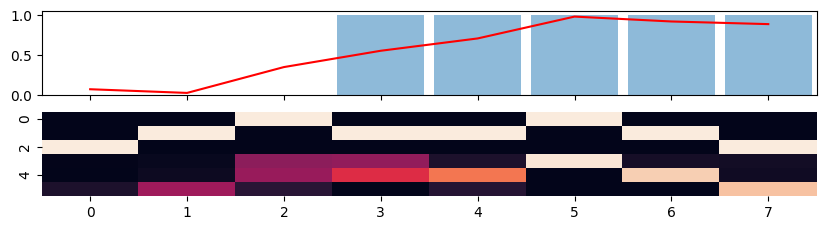

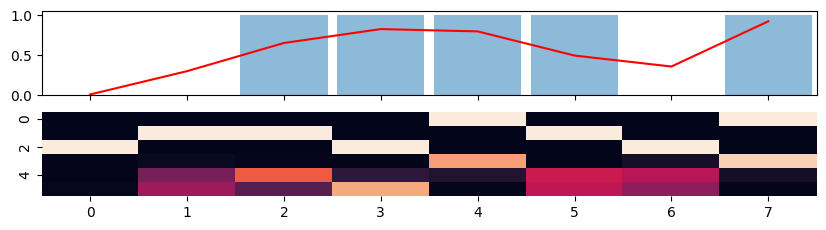

In [334]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [156]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B/cpu 0.4444444444444444
accuracies EleutherAI/gpt-neox-20b 0.5555555555555556
accuracies text-curie-001 0.3333333333333333
losses EleutherAI/gpt-j-6B/cpu 3.0475401878356934
losses EleutherAI/gpt-neox-20b 2.3752387364705405
losses text-curie-001 5.4890399882962955


In [129]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [47]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

 ... done 0:00:02.348918
 ... done 0:00:01.659792
 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.626 {'ĠA': 0.626, 'ĠI': 0.225, 'ĠY': 0.11} 	 Y A I -> A


 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.62

In [176]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B 0.4976851851851852
accuracies EleutherAI/gpt-neox-20b 0.5023148148148148
accuracies text-davinci-001 0.48148148148148145
accuracies text-davinci-002 0.9675925925925926
losses EleutherAI/gpt-j-6B 1.3536101162543572
losses EleutherAI/gpt-neox-20b 1.1634638377252957
losses text-davinci-001 1.687816629922939
losses text-davinci-002 0.1085046497381794


In [136]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

accuracies EleutherAI/gpt-j-6B 0.6203703703703703
accuracies EleutherAI/gpt-neox-20b 0.7083333333333334
accuracies text-curie-001 0.5879629629629629
losses EleutherAI/gpt-j-6B 1.5619440356433054
losses EleutherAI/gpt-neox-20b 1.0779137232247094
losses text-curie-001 3.1073556870623844


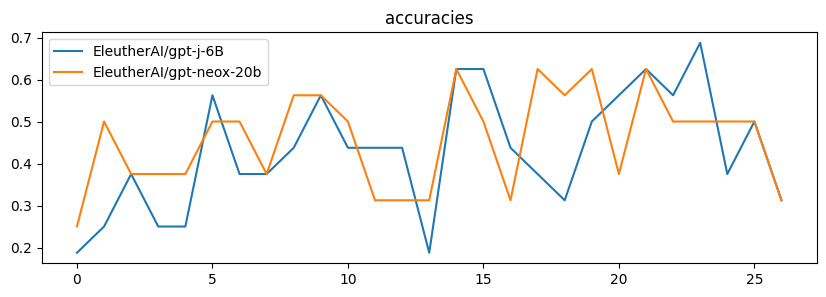

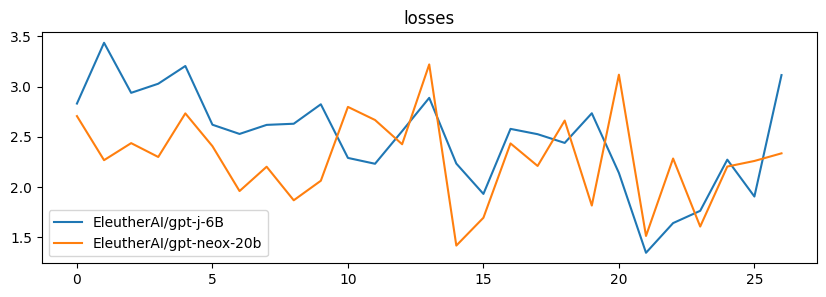

In [191]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [11]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [81]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [80]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'Yes': 0.35, 'No': 0.226, 'Yeah': 0.078, 'I': 0.078, 'Y': 0.021}

In [75]:
get_prob_dist(logits.top_logprobs[-1], 5)

{'No': 0.824, 'Yes': 0.115, 'I': 0.04, 'What': 0.006, ' No': 0.003}

In [155]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

[('▁The', 37),
 ('▁capital', 1784),
 ('▁of', 13),
 ('▁Canada', 1894),
 ('▁is', 19),
 ('</s>', 1)]

'Ottawa. It is the largest city in Canada'

In [478]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [197]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

EleutherAI/gpt-j-6B ... done 0:00:01
* C 0.842 {' C': 0.842, ' A': 0.041, ' B': 0.04} 	 D -> C
* Thursday 0.778 {' Thursday': 0.778, ' Wednesday': 0.064, ' Friday': 0.063} 	 Friday -> Thursday
* a 0.742 {' a': 0.742, ' c': 0.051, ' A': 0.036} 	 b -> a
* four 0.472 {' four': 0.472, ' three': 0.246, ' one': 0.105} 	 five -> four
tensor(0.3677, grad_fn=<NllLossBackward>) True 

0.3677041530609131


In [24]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [385]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

Instruction: replace with the other. For example:
G H G G G -> H G H H H
I I I I M -> M M M M I
A A F A A -> F F A F F
9 9 9 I I -> I I I 9 9

Instruction: replace with the other. For example:
V Q Q V V -> Q V V Q Q
G L L G L -> L G G L G
G 2 2 2 G -> 2 G G G 2
I I Z Z Z -> Z Z I I I

Instruction: replace with the other. For example:
R H H H R -> H R R R H
B 9 9 B B -> 9 B B 9 9
D 2 2 2 D -> 2 D D D 2
A A A A W -> W W W W A



In [368]:
sum(s.count('Yes') for s in input_strs)

370

In [322]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [121]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [329]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [330]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [333]:
trainer.place_model_on_device

True

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [6]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])